In [1]:
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import glob
import splat
from popsims.relations import polynomial_relation
from splat.photometry import filterMag
import splat.empirical as spe
from tqdm import tqdm
import popsims
from popsims.plot_style import  plot_style
plot_style()
%matplotlib inline



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
#plot overlap of filters



In [3]:
#add WISE 
WISE_MAGS={'i': (23.8, 0.1),
          'z': (20.147, 0.08),
          'y': (18.942, 0.13),
          'J': (17.291, 0.044)}

wise_df=pd.Series()
wise_df['spt']=38
wise_df['teff']=800
wise_df['names']='WISE1810−1010.'
for p in ['LSST', 'SDSS', 'PANSTARRS']:
    wise_df[p+'_G']=np.nan
    wise_df[p+'_G_er']=np.nan
    wise_df[p+'_R']=np.nan
    wise_df[p+'_R_er']=np.nan
    wise_df[p+'_I']=WISE_MAGS['i'][0]-5*np.log10(8.9/10)
    wise_df[p+'_I_er']=0.1
    wise_df[p+'_Z']=WISE_MAGS['z'][0]-5*np.log10(8.9/10)
    wise_df[p+'_Z_er']=0.1
    wise_df[p+'_Y']=WISE_MAGS['y'][0]-5*np.log10(8.9/10)
    wise_df[p+'_Y_er']=0.15

In [4]:
#compute conversions from Gaia to LSST
def compute_lsst_mags(gaia_id, gmag):
    #read spectrum
    vals={'source_id':gaia_id}
    try:
        sp=read_gaia_spec(gaia_id)
        for m in ['LSST_G', 'LSST_R', 'LSST_I', 'LSST_Y', 'LSST_Z']:
            color= get_colors(s, 'GAIA_G', m)
            vals.update({m:(color[0]+gmag, color[1])})
    except:
        pass
        
    return vals


def get_correct_filter_name(flt):
    #reformat from by 
    f= flt.split('_')
    if f[-1]=='ps1':
        return 'PANSTARRS_'+(f[0]).upper()
    else:
        return  flt
    

def spt_to_teff(spt, sd=True):
    if sd:
        if spt >25:  
            return  spe.typeToTeff(spt,  reverse=False, ref='pecaut')[0].value
        else:
            return spe.typeToTeff(spt, reverse=False, ref='gonzales18')[0].value
    if not sd:
        return spe.typeToTeff(teff,  reverse=False, ref='pecaut')[0].value
    
def teff_to_spt(teff, sd=True):
    if sd:
        if teff <1600: #use dwarfs for higher teff 
            return  spe.typeToTeff(teff,  reverse=True, ref='pecaut')[0]
        else:
            return spe.typeToTeff(teff, reverse=True, ref='gonzales18')[0]
    if not sd:
        return  spe.typeToTeff(teff,  reverse=True, ref='pecaut')[0]
    
def compute_mags_from_reference(spt, mag_key, ref):
    vals, unc= polynomial_relation(spt, 'spt', mag_key, ref, nsample=1000, xerr=0.0)
    return vals, unc

#functions
def k_clip_fit(x, y, sigma_y, sigma = 5, n=6):
    
    '''Fit a polynomial to y vs. x, and k-sigma clip until convergence
    hard-coded, returns mask array
    '''
    
    not_clipped = np.ones_like(y).astype(bool)
    n_remove = 1
    
    while n_remove > 0:

        best_fit = np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
        
        norm_res = (np.abs(y - best_fit(x)))/(sigma_y)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = sum(remove)
        not_clipped[remove] = 0   
        
    return  not_clipped

def fit_with_nsigma_clipping(x, y, y_unc, n, sigma=4.):
    not_clipped = k_clip_fit(x, y, y_unc, sigma = sigma)
    return not_clipped, np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))

#label sd, usd and esd
def get_sd_type(spt):
    for c in ['sd', 'esd', 'usd']:
        if spt.startswith(c):
            return c
        
def compute_colors(s, xkey, ykey):
    xmag= filterMag(s ,xkey)
    ymag= filterMag(s, ykey)
    return xmag[0]-ymag[0], (xmag[1]**2+ymag[1]**2)**0.5

In [5]:
filterMag?

In [6]:
filterMag

<function splat.photometry.filterMag(sp, filt, *args, **kwargs)>

In [7]:
#spectroscopic data for color information

In [8]:
zhang_tpls= np.load('/Volumes/LaCie/popsimsdata/zhang_subdwarfs_templates.npy',  allow_pickle=True)[0]

lodieu_tpls= np.load('/Volumes/LaCie/popsimsdata/lodieu_templates.npy',  allow_pickle=True)[0]

lepine_tpls= np.load('/Volumes/LaCie/popsimsdata/lepinelpsm_subdwarfs_templates.npy',  allow_pickle=True)[0]

kesseli_tpls= np.load('/Volumes/LaCie/popsimsdata/kesseli_subdwarfs_templates.npy',  allow_pickle=True)[0]

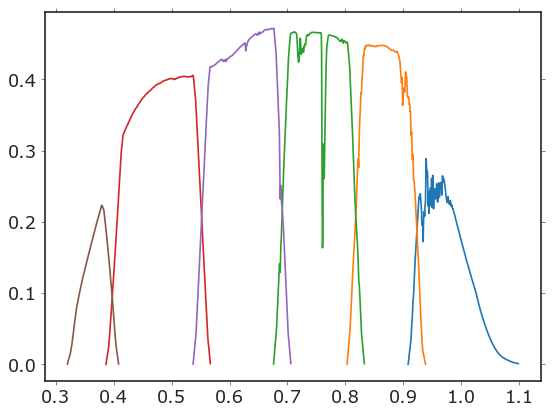

In [9]:
#PUTTING NEW FILTERS ON THE MICRON WAVELENGTH SCALE
for f in glob.glob('/users/caganze/research/splat/resources/filters/*.dat'):

        d=pd.read_csv(f, names=['LAM', 'TRANSMISSION'], delim_whitespace=True).astype(float)
        d['LAM']= d['LAM']/10_000
        #print (f)
        d.to_csv(f.replace('.dat', '.txt'), sep=' ', index=False)
        plt.plot(d.LAM, d.TRANSMISSION)
        #print (d)

In [10]:
#define all color terms to compute
COLOR_TERMS=['Gaia_GandLSST_G',
             'Gaia_RandLSST_R',
             
            'SDSS_GandLSST_G',
            'SDSS_RandLSST_G',
            'SDSS_RandLSST_R',
            'SDSS_IandLSST_I',
            'SDSS_ZandLSST_Z',
             
            'PANSTARRS_RandLSST_R',
            'PANSTARRS_IandLSST_I',
            'PANSTARRS_ZandLSST_Z',
            'PANSTARRS_YandLSST_Y',
             
            'LSST_GandLSST_R',
            'LSST_RandLSST_Z',
            'LSST_IandLSST_Z']

zhang_sd_corrections={}
for c in COLOR_TERMS:
    zhang_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(zhang_tpls['spectra'])]})
    
lodieu_sd_corrections={}
for c in COLOR_TERMS:
    lodieu_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(lodieu_tpls['spectra'])]})
    
lepine_sd_corrections={}
for c in COLOR_TERMS:
    lepine_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(lepine_tpls['spectra'])]})

 18%|███████▏                                 | 20/114 [00:00<00:00, 191.80it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 35%|██████████████▋                           | 40/114 [00:00<00:01, 62.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 45%|██████████████████▊                       | 51/114 [00:00<00:01, 44.78it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 51%|█████████████████████▎                    | 58/114 [00:01<00:01, 37.99it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 56%|███████████████████████▌                  | 64/114 [00:01<00:01, 34.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 64%|██████████████████████████▉               | 73/114 [00:01<00:01, 32.10it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 68%|████████████████████████████▎             | 77/114 [00:02<00:01, 29.00it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 74%|██████████████████████████████▉           | 84/114 [00:02<00:01, 25.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 80%|█████████████████████████████████▌        | 91/114 [00:02<00:00, 27.44it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 82%|██████████████████████████████████▋       | 94/114 [00:02<00:00, 25.78it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 89%|████████████████████████████████████▎    | 101/114 [00:02<00:00, 28.03it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 94%|██████████████████████████████████████▍  | 107/114 [00:03<00:00, 24.92it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|█████████████████████████████████████████| 114/114 [00:03<00:00, 33.60it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|████████▎                                | 23/114 [00:00<00:00, 227.94it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 41%|████████████████▉                        | 47/114 [00:00<00:00, 232.23it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 62%|█████████████████████████▌               | 71/114 [00:00<00:00, 234.36it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 83%|██████████████████████████████████▏      | 95/114 [00:00<00:00, 232.55it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


100%|████████████████████████████████████████| 114/114 [00:00<00:00, 232.81it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  0%|                                                   | 0/114 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 35%|██████████████▍                          | 40/114 [00:00<00:00, 393.34it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 70%|████████████████████████████▊            | 80/114 [00:00<00:00, 209.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 93%|█████████████████████████████████████▏  | 106/114 [00:00<00:00, 187.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|████████████████████████████████████████| 114/114 [00:00<00:00, 204.08it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  0%|                                                   | 0/114 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 34%|██████████████                           | 39/114 [00:00<00:00, 387.90it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 68%|████████████████████████████             | 78/114 [00:00<00:00, 209.07it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 91%|████████████████████████████████████▍   | 104/114 [00:00<00:00, 184.97it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|████████████████████████████████████████| 114/114 [00:00<00:00, 200.66it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  0%|                                                   | 0/114 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 35%|██████████████▍                          | 40/114 [00:00<00:00, 393.05it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 70%|████████████████████████████▊            | 80/114 [00:00<00:00, 214.61it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 93%|█████████████████████████████████████▏  | 106/114 [00:00<00:00, 192.87it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


100%|████████████████████████████████████████| 114/114 [00:00<00:00, 209.85it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  0%|                                                   | 0/114 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 35%|██████████████▍                          | 40/114 [00:00<00:00, 379.45it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 68%|████████████████████████████             | 78/114 [00:00<00:00, 207.14it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 90%|████████████████████████████████████▏   | 103/114 [00:00<00:00, 183.44it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


100%|████████████████████████████████████████| 114/114 [00:00<00:00, 197.83it/s]



SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  0%|                                                   | 0/114 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 34%|██████████████                           | 39/114 [00:00<00:00, 363.60it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 67%|███████████████████████████▎             | 76/114 [00:00<00:00, 144.62it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 85%|██████████████████████████████████▉      | 97/114 [00:00<00:00, 142.23it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


100%|████████████████████████████████████████| 114/114 [00:00<00:00, 156.07it/s]



SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  0%|                                                   | 0/114 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 33%|█████████████▋                           | 38/114 [00:00<00:00, 366.65it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 66%|██████████████████████████▉              | 75/114 [00:00<00:00, 195.30it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 87%|███████████████████████████████████▌     | 99/114 [00:00<00:00, 167.63it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


100%|████████████████████████████████████████| 114/114 [00:00<00:00, 184.06it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  0%|                                                   | 0/114 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 34%|██████████████                           | 39/114 [00:00<00:00, 363.08it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 67%|███████████████████████████▎             | 76/114 [00:00<00:00, 194.32it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 88%|███████████████████████████████████     | 100/114 [00:00<00:00, 174.83it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


100%|████████████████████████████████████████| 114/114 [00:00<00:00, 189.56it/s]



SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  0%|                                                   | 0/114 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 33%|█████████████▋                           | 38/114 [00:00<00:00, 376.78it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 67%|███████████████████████████▎             | 76/114 [00:00<00:00, 180.94it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 88%|███████████████████████████████████     | 100/114 [00:00<00:00, 164.83it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


100%|████████████████████████████████████████| 114/114 [00:00<00:00, 177.43it/s]



SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  0%|                                                   | 0/114 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 33%|█████████████▋                           | 38/114 [00:00<00:00, 349.13it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 64%|██████████████████████████▎              | 73/114 [00:00<00:00, 194.11it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 84%|██████████████████████████████████▌      | 96/114 [00:00<00:00, 166.14it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

100%|████████████████████████████████████████| 114/114 [00:00<00:00, 182.63it/s]




SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y


  0%|                                                   | 0/114 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

100%|███████████████████████████████████████| 114/114 [00:00<00:00, 4157.83it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

100%|███████████████████████████████████████| 114/114 [00:00<00:00, 4399.50it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

100%|███████████████████████████████████████| 114/114 [00:00<00:00, 4269.66it/s]



SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|███▏                                        | 3/41 [00:00<00:01, 26.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|██████▍                                     | 6/41 [00:00<00:01, 26.47it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|█████████▋                                  | 9/41 [00:00<00:01, 26.78it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|████████████▌                              | 12/41 [00:00<00:01, 26.83it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 37%|███████████████▋                           | 15/41 [00:00<00:00, 26.59it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 44%|██████████████████▉                        | 18/41 [00:00<00:00, 26.41it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 51%|██████████████████████                     | 21/41 [00:00<00:00, 26.57it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 59%|█████████████████████████▏                 | 24/41 [00:00<00:00, 26.75it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 66%|████████████████████████████▎              | 27/41 [00:01<00:00, 26.79it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 73%|███████████████████████████████▍           | 30/41 [00:01<00:00, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 80%|██████████████████████████████████▌        | 33/41 [00:01<00:00, 27.49it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 88%|█████████████████████████████████████▊     | 36/41 [00:01<00:00, 27.73it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 95%|████████████████████████████████████████▉  | 39/41 [00:01<00:00, 27.87it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|███████████████████████████████████████████| 41/41 [00:01<00:00, 27.15it/s]



SPLAT does not contain the filter LSST_G


  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 63%|██████████████████████████▋               | 26/41 [00:00<00:00, 250.72it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 250.99it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R



  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|████████████▎                             | 12/41 [00:00<00:00, 110.35it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 59%|████████████████████████▌                 | 24/41 [00:00<00:00, 111.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 88%|████████████████████████████████████▉     | 36/41 [00:00<00:00, 111.97it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 111.21it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|███████████▎                              | 11/41 [00:00<00:00, 106.59it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 56%|███████████████████████▌                  | 23/41 [00:00<00:00, 108.68it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 83%|██████████████████████████████████▊       | 34/41 [00:00<00:00, 108.68it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 108.79it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G



  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 27%|███████████▎                              | 11/41 [00:00<00:00, 107.10it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 54%|██████████████████████▌                   | 22/41 [00:00<00:00, 108.75it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 83%|██████████████████████████████████▊       | 34/41 [00:00<00:00, 109.46it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 108.81it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R



  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 27%|███████████▎                              | 11/41 [00:00<00:00, 104.68it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 54%|██████████████████████▌                   | 22/41 [00:00<00:00, 106.97it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 80%|█████████████████████████████████▊        | 33/41 [00:00<00:00, 107.19it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 106.87it/s]



SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 27%|███████████▎                              | 11/41 [00:00<00:00, 100.34it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 54%|██████████████████████▌                   | 22/41 [00:00<00:00, 101.95it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 80%|█████████████████████████████████▊        | 33/41 [00:00<00:00, 102.17it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 101.99it/s]



SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 27%|███████████▎                              | 11/41 [00:00<00:00, 100.46it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 54%|██████████████████████▌                   | 22/41 [00:00<00:00, 100.18it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 80%|█████████████████████████████████▊        | 33/41 [00:00<00:00, 100.35it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 100.36it/s]



SPLAT does not contain the filter LSST_R


  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 24%|██████████▍                                | 10/41 [00:00<00:00, 99.65it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 49%|████████████████████▉                      | 20/41 [00:00<00:00, 97.98it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 73%|███████████████████████████████▍           | 30/41 [00:00<00:00, 97.52it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 98.14it/s]



SPLAT does not contain the filter LSST_I


  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 24%|██████████▍                                | 10/41 [00:00<00:00, 98.02it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 51%|█████████████████████▌                    | 21/41 [00:00<00:00, 100.58it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 78%|████████████████████████████████▊         | 32/41 [00:00<00:00, 100.76it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 100.84it/s]



SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y


 24%|██████████▍                                | 10/41 [00:00<00:00, 99.15it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y


 51%|█████████████████████▌                    | 21/41 [00:00<00:00, 100.10it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y


 78%|█████████████████████████████████▌         | 32/41 [00:00<00:00, 99.20it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y


100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 98.62it/s]



SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y


  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 3803.73it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 3898.49it/s]



SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z


  0%|                                                    | 0/41 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 4016.13it/s]



SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  0%|                                                  | 0/3137 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G


  0%|                                          | 3/3137 [00:00<01:52, 27.81it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  0%|                                          | 6/3137 [00:00<01:53, 27.64it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  0%|                                          | 9/3137 [00:00<01:53, 27.49it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  0%|▏                                        | 12/3137 [00:00<01:52, 27.67it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  0%|▏                                        | 15/3137 [00:00<01:52, 27.82it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  1%|▏                                        | 18/3137 [00:00<01:52, 27.79it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  1%|▎                                        | 21/3137 [00:00<01:52, 27.79it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  1%|▎                                        | 24/3137 [00:00<01:52, 27.76it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  1%|▎                                        | 27/3137 [00:00<01:51, 27.77it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  1%|▍                                        | 30/3137 [00:01<01:52, 27.68it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  1%|▍                                        | 33/3137 [00:01<01:51, 27.72it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  1%|▍                                        | 36/3137 [00:01<01:53, 27.39it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  1%|▌                                        | 39/3137 [00:01<01:53, 27.41it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  1%|▌                                        | 42/3137 [00:01<01:52, 27.44it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  1%|▌                                        | 45/3137 [00:01<01:53, 27.31it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|▋                                        | 48/3137 [00:01<01:53, 27.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|▋                                        | 51/3137 [00:01<01:52, 27.46it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|▋                                        | 54/3137 [00:01<01:52, 27.40it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|▋                                        | 57/3137 [00:02<01:52, 27.49it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|▊                                        | 60/3137 [00:02<01:51, 27.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|▊                                        | 63/3137 [00:02<01:51, 27.57it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|▊                                        | 66/3137 [00:02<01:51, 27.58it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|▉                                        | 69/3137 [00:02<01:51, 27.56it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|▉                                        | 72/3137 [00:02<01:51, 27.45it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|▉                                        | 75/3137 [00:02<01:51, 27.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|█                                        | 78/3137 [00:02<01:51, 27.54it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  3%|█                                        | 81/3137 [00:02<01:50, 27.54it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  3%|█                                        | 84/3137 [00:03<01:51, 27.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  3%|█▏                                       | 87/3137 [00:03<01:51, 27.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  3%|█▏                                       | 90/3137 [00:03<01:51, 27.38it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  3%|█▏                                       | 93/3137 [00:03<01:50, 27.43it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  3%|█▎                                       | 96/3137 [00:03<01:50, 27.44it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  3%|█▎                                       | 99/3137 [00:03<01:51, 27.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  3%|█▎                                      | 102/3137 [00:03<01:51, 27.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  3%|█▎                                      | 105/3137 [00:03<01:50, 27.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  3%|█▍                                      | 108/3137 [00:03<01:50, 27.39it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▍                                      | 111/3137 [00:04<01:50, 27.45it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▍                                      | 114/3137 [00:04<01:49, 27.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▍                                      | 117/3137 [00:04<01:49, 27.55it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▌                                      | 120/3137 [00:04<01:49, 27.54it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▌                                      | 123/3137 [00:04<01:49, 27.63it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▌                                      | 126/3137 [00:04<01:49, 27.57it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▋                                      | 129/3137 [00:04<01:48, 27.63it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▋                                      | 132/3137 [00:04<01:48, 27.62it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▋                                      | 135/3137 [00:04<01:48, 27.60it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▊                                      | 138/3137 [00:05<01:49, 27.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▊                                      | 141/3137 [00:05<01:50, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  5%|█▊                                      | 144/3137 [00:05<01:50, 27.10it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  5%|█▊                                      | 147/3137 [00:05<01:49, 27.34it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  5%|█▉                                      | 150/3137 [00:05<01:49, 27.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  5%|█▉                                      | 153/3137 [00:05<01:49, 27.34it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  5%|█▉                                      | 156/3137 [00:05<01:48, 27.43it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  5%|██                                      | 159/3137 [00:05<01:47, 27.60it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  5%|██                                      | 162/3137 [00:05<01:47, 27.57it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  5%|██                                      | 165/3137 [00:06<01:47, 27.57it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  5%|██▏                                     | 168/3137 [00:06<01:47, 27.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  5%|██▏                                     | 171/3137 [00:06<01:47, 27.63it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  6%|██▏                                     | 174/3137 [00:06<01:47, 27.66it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  6%|██▎                                     | 177/3137 [00:06<01:46, 27.66it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  6%|██▎                                     | 180/3137 [00:06<01:47, 27.59it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  6%|██▎                                     | 183/3137 [00:06<01:47, 27.54it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  6%|██▎                                     | 186/3137 [00:06<01:47, 27.41it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  6%|██▍                                     | 189/3137 [00:06<01:47, 27.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  6%|██▍                                     | 192/3137 [00:06<01:47, 27.47it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  6%|██▍                                     | 195/3137 [00:07<01:48, 27.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  6%|██▌                                     | 198/3137 [00:07<01:47, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  6%|██▌                                     | 201/3137 [00:07<01:47, 27.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▌                                     | 204/3137 [00:07<01:47, 27.35it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▋                                     | 207/3137 [00:07<01:46, 27.46it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▋                                     | 210/3137 [00:07<01:46, 27.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▋                                     | 213/3137 [00:07<01:46, 27.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▊                                     | 216/3137 [00:07<01:46, 27.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▊                                     | 219/3137 [00:07<01:46, 27.47it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▊                                     | 222/3137 [00:08<01:46, 27.49it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▊                                     | 225/3137 [00:08<01:46, 27.46it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▉                                     | 228/3137 [00:08<01:49, 26.54it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▉                                     | 231/3137 [00:08<01:49, 26.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▉                                     | 234/3137 [00:08<01:47, 26.90it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|███                                     | 237/3137 [00:08<01:46, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|███                                     | 240/3137 [00:08<01:45, 27.52it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|███                                     | 243/3137 [00:08<01:44, 27.74it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|███▏                                    | 246/3137 [00:08<01:43, 27.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|███▏                                    | 249/3137 [00:09<01:43, 27.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|███▏                                    | 252/3137 [00:09<01:43, 27.94it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|███▎                                    | 255/3137 [00:09<01:42, 27.99it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|███▎                                    | 258/3137 [00:09<01:42, 28.00it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|███▎                                    | 261/3137 [00:09<01:43, 27.80it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|███▎                                    | 264/3137 [00:09<01:44, 27.50it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▍                                    | 267/3137 [00:09<01:45, 27.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▍                                    | 270/3137 [00:09<01:45, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▍                                    | 273/3137 [00:09<01:45, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▌                                    | 276/3137 [00:10<01:44, 27.39it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▌                                    | 279/3137 [00:10<01:43, 27.54it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▌                                    | 282/3137 [00:10<01:43, 27.56it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▋                                    | 285/3137 [00:10<01:43, 27.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▋                                    | 288/3137 [00:10<01:43, 27.44it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▋                                    | 291/3137 [00:10<01:43, 27.53it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▋                                    | 294/3137 [00:10<01:44, 27.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▊                                    | 297/3137 [00:10<01:43, 27.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 10%|███▊                                    | 300/3137 [00:10<01:43, 27.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 10%|███▊                                    | 303/3137 [00:11<01:43, 27.46it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 10%|███▉                                    | 306/3137 [00:11<01:43, 27.31it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 10%|███▉                                    | 309/3137 [00:11<01:43, 27.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 10%|███▉                                    | 312/3137 [00:11<01:43, 27.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 10%|████                                    | 315/3137 [00:11<01:43, 27.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 10%|████                                    | 318/3137 [00:11<01:43, 27.31it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 10%|████                                    | 321/3137 [00:11<01:43, 27.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 10%|████▏                                   | 324/3137 [00:11<01:42, 27.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 10%|████▏                                   | 327/3137 [00:11<01:42, 27.42it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▏                                   | 330/3137 [00:12<01:42, 27.45it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▏                                   | 333/3137 [00:12<01:42, 27.44it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▎                                   | 336/3137 [00:12<01:42, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▎                                   | 339/3137 [00:12<01:42, 27.35it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▎                                   | 342/3137 [00:12<01:42, 27.40it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▍                                   | 345/3137 [00:12<01:41, 27.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▍                                   | 348/3137 [00:12<01:41, 27.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▍                                   | 351/3137 [00:12<01:41, 27.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▌                                   | 354/3137 [00:12<01:41, 27.46it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▌                                   | 357/3137 [00:13<01:41, 27.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▌                                   | 360/3137 [00:13<01:41, 27.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 12%|████▋                                   | 363/3137 [00:13<01:41, 27.42it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 12%|████▋                                   | 366/3137 [00:13<01:40, 27.45it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 12%|████▋                                   | 369/3137 [00:13<01:40, 27.52it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 12%|████▋                                   | 372/3137 [00:13<01:40, 27.49it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 12%|████▊                                   | 375/3137 [00:13<01:40, 27.50it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 12%|████▊                                   | 378/3137 [00:13<01:41, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 12%|████▊                                   | 381/3137 [00:13<01:40, 27.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 12%|████▉                                   | 384/3137 [00:13<01:40, 27.40it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 12%|████▉                                   | 387/3137 [00:14<01:40, 27.44it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 12%|████▉                                   | 390/3137 [00:14<01:40, 27.43it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████                                   | 393/3137 [00:14<01:39, 27.50it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████                                   | 396/3137 [00:14<01:40, 27.32it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████                                   | 399/3137 [00:14<01:40, 27.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████▏                                  | 402/3137 [00:14<01:39, 27.45it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████▏                                  | 405/3137 [00:14<01:39, 27.47it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████▏                                  | 408/3137 [00:14<01:39, 27.53it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████▏                                  | 411/3137 [00:14<01:39, 27.53it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████▎                                  | 414/3137 [00:15<01:39, 27.47it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████▎                                  | 417/3137 [00:15<01:38, 27.54it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████▎                                  | 420/3137 [00:15<01:39, 27.41it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████▍                                  | 423/3137 [00:15<01:38, 27.47it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 14%|█████▍                                  | 426/3137 [00:15<01:38, 27.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 14%|█████▍                                  | 429/3137 [00:15<01:38, 27.45it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 14%|█████▌                                  | 432/3137 [00:15<01:38, 27.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 14%|█████▌                                  | 435/3137 [00:15<01:38, 27.47it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 14%|█████▌                                  | 438/3137 [00:15<01:38, 27.49it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 14%|█████▌                                  | 441/3137 [00:16<01:37, 27.54it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 14%|█████▋                                  | 444/3137 [00:16<01:38, 27.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 14%|█████▋                                  | 447/3137 [00:16<01:38, 27.32it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 14%|█████▋                                  | 450/3137 [00:16<01:38, 27.38it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 14%|█████▊                                  | 453/3137 [00:16<01:37, 27.43it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|█████▊                                  | 456/3137 [00:16<01:37, 27.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|█████▊                                  | 459/3137 [00:16<01:36, 27.65it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|█████▉                                  | 462/3137 [00:16<01:37, 27.50it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|█████▉                                  | 465/3137 [00:16<01:36, 27.57it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|█████▉                                  | 468/3137 [00:17<01:36, 27.73it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|██████                                  | 471/3137 [00:17<01:35, 27.89it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|██████                                  | 474/3137 [00:17<01:35, 27.94it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|██████                                  | 477/3137 [00:17<01:34, 28.02it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|██████                                  | 480/3137 [00:17<01:35, 27.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|██████▏                                 | 483/3137 [00:17<01:34, 28.01it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|██████▏                                 | 486/3137 [00:17<01:34, 28.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 16%|██████▏                                 | 489/3137 [00:17<01:34, 28.09it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 16%|██████▎                                 | 492/3137 [00:17<01:34, 28.10it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 16%|██████▎                                 | 495/3137 [00:18<01:33, 28.13it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 16%|██████▎                                 | 498/3137 [00:18<01:34, 28.03it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 16%|██████▍                                 | 501/3137 [00:18<01:34, 27.83it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 16%|██████▍                                 | 504/3137 [00:18<01:35, 27.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 16%|██████▍                                 | 507/3137 [00:18<01:35, 27.60it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 16%|██████▌                                 | 510/3137 [00:18<01:35, 27.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 16%|██████▌                                 | 513/3137 [00:18<01:35, 27.50it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 16%|██████▌                                 | 516/3137 [00:18<01:35, 27.42it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 17%|██████▌                                 | 519/3137 [00:18<01:35, 27.46it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 17%|██████▋                                 | 522/3137 [00:18<01:35, 27.45it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 17%|██████▋                                 | 525/3137 [00:19<01:35, 27.46it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 17%|██████▋                                 | 528/3137 [00:19<01:35, 27.35it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 17%|██████▊                                 | 531/3137 [00:19<01:35, 27.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 17%|██████▊                                 | 534/3137 [00:19<01:35, 27.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 17%|██████▊                                 | 537/3137 [00:19<01:35, 27.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 17%|██████▉                                 | 540/3137 [00:19<01:34, 27.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 17%|██████▉                                 | 543/3137 [00:19<01:34, 27.39it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 17%|██████▉                                 | 546/3137 [00:19<01:34, 27.39it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████                                 | 549/3137 [00:19<01:34, 27.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████                                 | 552/3137 [00:20<01:35, 27.05it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████                                 | 555/3137 [00:20<01:34, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████                                 | 558/3137 [00:20<01:34, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████▏                                | 561/3137 [00:20<01:34, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████▏                                | 564/3137 [00:20<01:34, 27.32it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████▏                                | 567/3137 [00:20<01:35, 26.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████▎                                | 570/3137 [00:20<01:35, 26.93it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████▎                                | 573/3137 [00:20<01:35, 26.97it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████▎                                | 576/3137 [00:20<01:34, 27.12it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████▍                                | 579/3137 [00:21<01:34, 27.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 19%|███████▍                                | 582/3137 [00:21<01:33, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 19%|███████▍                                | 585/3137 [00:21<01:33, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 19%|███████▍                                | 588/3137 [00:21<01:33, 27.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 19%|███████▌                                | 591/3137 [00:21<01:33, 27.09it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 19%|███████▌                                | 594/3137 [00:21<01:33, 27.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 19%|███████▌                                | 597/3137 [00:21<01:33, 27.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 19%|███████▋                                | 600/3137 [00:21<01:33, 27.04it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 19%|███████▋                                | 603/3137 [00:21<01:32, 27.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 19%|███████▋                                | 606/3137 [00:22<01:32, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 19%|███████▊                                | 609/3137 [00:22<01:32, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|███████▊                                | 612/3137 [00:22<01:32, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|███████▊                                | 615/3137 [00:22<01:31, 27.42it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|███████▉                                | 618/3137 [00:22<01:32, 27.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|███████▉                                | 621/3137 [00:22<01:31, 27.43it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|███████▉                                | 624/3137 [00:22<01:32, 27.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|███████▉                                | 627/3137 [00:22<01:32, 27.12it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|████████                                | 630/3137 [00:22<01:32, 27.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|████████                                | 633/3137 [00:23<01:31, 27.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|████████                                | 636/3137 [00:23<01:31, 27.32it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|████████▏                               | 639/3137 [00:23<01:31, 27.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|████████▏                               | 642/3137 [00:23<01:31, 27.38it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|████████▏                               | 645/3137 [00:23<01:31, 27.15it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|████████▎                               | 648/3137 [00:23<01:31, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|████████▎                               | 651/3137 [00:23<01:31, 27.10it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|████████▎                               | 654/3137 [00:23<01:31, 27.02it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|████████▍                               | 657/3137 [00:23<01:31, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|████████▍                               | 660/3137 [00:24<01:30, 27.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|████████▍                               | 663/3137 [00:24<01:31, 27.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|████████▍                               | 666/3137 [00:24<01:30, 27.34it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|████████▌                               | 669/3137 [00:24<01:29, 27.43it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|████████▌                               | 672/3137 [00:24<01:30, 27.32it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▌                               | 675/3137 [00:24<01:30, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▋                               | 678/3137 [00:24<01:32, 26.63it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▋                               | 681/3137 [00:24<01:33, 26.41it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▋                               | 684/3137 [00:24<01:32, 26.53it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▊                               | 687/3137 [00:25<01:32, 26.55it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▊                               | 690/3137 [00:25<01:31, 26.67it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▊                               | 693/3137 [00:25<01:31, 26.78it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▊                               | 696/3137 [00:25<01:30, 26.87it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▉                               | 699/3137 [00:25<01:30, 26.91it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▉                               | 702/3137 [00:25<01:30, 26.90it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▉                               | 705/3137 [00:25<01:30, 26.93it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 23%|█████████                               | 708/3137 [00:25<01:30, 26.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 23%|█████████                               | 711/3137 [00:25<01:30, 26.70it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 23%|█████████                               | 714/3137 [00:26<01:31, 26.62it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 23%|█████████▏                              | 717/3137 [00:26<01:30, 26.72it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 23%|█████████▏                              | 720/3137 [00:26<01:30, 26.75it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 23%|█████████▏                              | 723/3137 [00:26<01:29, 26.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 23%|█████████▎                              | 726/3137 [00:26<01:29, 26.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 23%|█████████▎                              | 729/3137 [00:26<01:30, 26.62it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 23%|█████████▎                              | 732/3137 [00:26<01:30, 26.70it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 23%|█████████▎                              | 735/3137 [00:26<01:29, 26.77it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▍                              | 738/3137 [00:26<01:29, 26.78it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▍                              | 741/3137 [00:27<01:29, 26.76it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▍                              | 744/3137 [00:27<01:29, 26.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▌                              | 747/3137 [00:27<01:29, 26.84it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▌                              | 750/3137 [00:27<01:28, 26.88it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▌                              | 753/3137 [00:27<01:28, 26.88it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▋                              | 756/3137 [00:27<01:28, 26.91it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▋                              | 759/3137 [00:27<01:28, 26.93it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▋                              | 762/3137 [00:27<01:28, 26.92it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▊                              | 765/3137 [00:27<01:28, 26.91it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▊                              | 768/3137 [00:28<01:28, 26.91it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 25%|█████████▊                              | 771/3137 [00:28<01:27, 26.95it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 25%|█████████▊                              | 774/3137 [00:28<01:28, 26.72it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 25%|█████████▉                              | 777/3137 [00:28<01:28, 26.70it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 25%|█████████▉                              | 780/3137 [00:28<01:28, 26.77it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 25%|█████████▉                              | 783/3137 [00:28<01:27, 26.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 25%|██████████                              | 786/3137 [00:28<01:28, 26.67it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 25%|██████████                              | 789/3137 [00:28<01:28, 26.39it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 25%|██████████                              | 792/3137 [00:28<01:29, 26.31it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 25%|██████████▏                             | 795/3137 [00:29<01:28, 26.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 25%|██████████▏                             | 798/3137 [00:29<01:28, 26.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▏                             | 801/3137 [00:29<01:27, 26.67it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▎                             | 804/3137 [00:29<01:27, 26.72it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▎                             | 807/3137 [00:29<01:27, 26.53it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▎                             | 810/3137 [00:29<01:27, 26.62it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▎                             | 813/3137 [00:29<01:27, 26.71it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▍                             | 816/3137 [00:29<01:26, 26.69it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▍                             | 819/3137 [00:29<01:26, 26.66it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▍                             | 822/3137 [00:30<01:26, 26.67it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▌                             | 825/3137 [00:30<01:26, 26.72it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▌                             | 828/3137 [00:30<01:27, 26.41it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▌                             | 831/3137 [00:30<01:26, 26.55it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▋                             | 834/3137 [00:30<01:26, 26.70it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▋                             | 837/3137 [00:30<01:25, 26.79it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▋                             | 840/3137 [00:30<01:25, 26.73it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▋                             | 843/3137 [00:30<01:25, 26.72it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▊                             | 846/3137 [00:31<01:25, 26.81it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▊                             | 849/3137 [00:31<01:25, 26.82it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▊                             | 852/3137 [00:31<01:24, 26.90it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▉                             | 855/3137 [00:31<01:24, 26.97it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▉                             | 858/3137 [00:31<01:24, 26.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▉                             | 861/3137 [00:31<01:24, 26.91it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████                             | 864/3137 [00:31<01:24, 26.94it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████                             | 867/3137 [00:31<01:24, 26.89it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████                             | 870/3137 [00:31<01:23, 27.02it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████▏                            | 873/3137 [00:32<01:23, 27.03it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████▏                            | 876/3137 [00:32<01:23, 27.01it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████▏                            | 879/3137 [00:32<01:23, 26.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████▏                            | 882/3137 [00:32<01:24, 26.71it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████▎                            | 885/3137 [00:32<01:25, 26.42it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████▎                            | 888/3137 [00:32<01:25, 26.34it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████▎                            | 891/3137 [00:32<01:24, 26.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████▍                            | 894/3137 [00:32<01:24, 26.69it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▍                            | 897/3137 [00:32<01:23, 26.77it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▍                            | 900/3137 [00:33<01:23, 26.76it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▌                            | 903/3137 [00:33<01:23, 26.83it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▌                            | 906/3137 [00:33<01:23, 26.84it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▌                            | 909/3137 [00:33<01:23, 26.72it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▋                            | 912/3137 [00:33<01:23, 26.76it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▋                            | 915/3137 [00:33<01:22, 26.83it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▋                            | 918/3137 [00:33<01:22, 26.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▋                            | 921/3137 [00:33<01:22, 26.83it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▊                            | 924/3137 [00:33<01:23, 26.61it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|███████████▊                            | 927/3137 [00:34<01:24, 26.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|███████████▊                            | 930/3137 [00:34<01:24, 26.04it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|███████████▉                            | 933/3137 [00:34<01:24, 26.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|███████████▉                            | 936/3137 [00:34<01:23, 26.47it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|███████████▉                            | 939/3137 [00:34<01:23, 26.44it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|████████████                            | 942/3137 [00:34<01:22, 26.65it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|████████████                            | 945/3137 [00:34<01:21, 26.75it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|████████████                            | 948/3137 [00:34<01:21, 26.78it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|████████████▏                           | 951/3137 [00:34<01:21, 26.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|████████████▏                           | 954/3137 [00:35<01:21, 26.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|████████████▏                           | 957/3137 [00:35<01:21, 26.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|████████████▏                           | 960/3137 [00:35<01:21, 26.87it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|████████████▎                           | 963/3137 [00:35<01:21, 26.64it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|████████████▎                           | 966/3137 [00:35<01:21, 26.74it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|████████████▎                           | 969/3137 [00:35<01:20, 26.82it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|████████████▍                           | 972/3137 [00:35<01:20, 26.81it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|████████████▍                           | 975/3137 [00:35<01:20, 26.88it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|████████████▍                           | 978/3137 [00:35<01:20, 26.87it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|████████████▌                           | 981/3137 [00:36<01:20, 26.89it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|████████████▌                           | 984/3137 [00:36<01:20, 26.89it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|████████████▌                           | 987/3137 [00:36<01:19, 26.90it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|████████████▌                           | 990/3137 [00:36<01:19, 26.95it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|████████████▋                           | 993/3137 [00:36<01:19, 26.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|████████████▋                           | 996/3137 [00:36<01:19, 26.94it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|████████████▋                           | 999/3137 [00:36<01:19, 26.91it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|████████████▍                          | 1002/3137 [00:36<01:19, 26.91it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|████████████▍                          | 1005/3137 [00:36<01:19, 26.97it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|████████████▌                          | 1008/3137 [00:37<01:18, 26.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|████████████▌                          | 1011/3137 [00:37<01:18, 26.94it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|████████████▌                          | 1014/3137 [00:37<01:18, 26.88it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|████████████▋                          | 1017/3137 [00:37<01:18, 26.87it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|████████████▋                          | 1020/3137 [00:37<01:18, 26.89it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|████████████▋                          | 1023/3137 [00:37<01:18, 26.88it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|████████████▊                          | 1026/3137 [00:37<01:18, 26.95it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|████████████▊                          | 1029/3137 [00:37<01:18, 26.92it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|████████████▊                          | 1032/3137 [00:37<01:18, 26.88it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|████████████▊                          | 1035/3137 [00:38<01:18, 26.93it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|████████████▉                          | 1038/3137 [00:38<01:17, 26.95it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|████████████▉                          | 1044/3137 [00:38<01:37, 21.56it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|█████████████                          | 1050/3137 [00:38<01:26, 24.09it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 34%|█████████████▏                         | 1056/3137 [00:38<01:21, 25.59it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 34%|█████████████▏                         | 1062/3137 [00:39<01:18, 26.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 34%|█████████████▎                         | 1068/3137 [00:39<01:17, 26.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 34%|█████████████▎                         | 1074/3137 [00:39<01:16, 27.07it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 34%|█████████████▍                         | 1080/3137 [00:39<01:15, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 35%|█████████████▌                         | 1086/3137 [00:40<01:15, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 35%|█████████████▌                         | 1092/3137 [00:40<01:15, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 35%|█████████████▋                         | 1098/3137 [00:40<01:14, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 35%|█████████████▋                         | 1104/3137 [00:40<01:14, 27.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 35%|█████████████▊                         | 1110/3137 [00:40<01:14, 27.32it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 36%|█████████████▊                         | 1116/3137 [00:41<01:14, 27.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 36%|█████████████▉                         | 1122/3137 [00:41<01:14, 26.93it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 36%|██████████████                         | 1128/3137 [00:41<01:13, 27.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 36%|██████████████                         | 1134/3137 [00:41<01:13, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 36%|██████████████▏                        | 1140/3137 [00:42<01:13, 27.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 37%|██████████████▏                        | 1146/3137 [00:42<01:12, 27.31it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 37%|██████████████▎                        | 1152/3137 [00:42<01:12, 27.34it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 37%|██████████████▍                        | 1158/3137 [00:42<01:12, 27.32it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 37%|██████████████▍                        | 1164/3137 [00:42<01:12, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 37%|██████████████▌                        | 1170/3137 [00:43<01:12, 27.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 37%|██████████████▌                        | 1176/3137 [00:43<01:11, 27.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 38%|██████████████▋                        | 1182/3137 [00:43<01:11, 27.31it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 38%|██████████████▊                        | 1188/3137 [00:43<01:11, 27.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 38%|██████████████▊                        | 1194/3137 [00:44<01:11, 27.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 38%|██████████████▉                        | 1200/3137 [00:44<01:10, 27.31it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 38%|██████████████▉                        | 1206/3137 [00:44<01:11, 27.10it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 39%|███████████████                        | 1212/3137 [00:44<01:10, 27.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 39%|███████████████▏                       | 1218/3137 [00:44<01:10, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 39%|███████████████▏                       | 1224/3137 [00:45<01:10, 27.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 39%|███████████████▎                       | 1230/3137 [00:45<01:10, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 39%|███████████████▎                       | 1236/3137 [00:45<01:09, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 40%|███████████████▍                       | 1242/3137 [00:45<01:09, 27.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 40%|███████████████▌                       | 1248/3137 [00:46<01:09, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 40%|███████████████▌                       | 1254/3137 [00:46<01:09, 27.13it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 40%|███████████████▋                       | 1260/3137 [00:46<01:08, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 40%|███████████████▋                       | 1266/3137 [00:46<01:08, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 41%|███████████████▊                       | 1272/3137 [00:46<01:08, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 41%|███████████████▉                       | 1278/3137 [00:47<01:07, 27.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 41%|███████████████▉                       | 1284/3137 [00:47<01:08, 27.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 41%|████████████████                       | 1290/3137 [00:47<01:08, 27.08it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 41%|████████████████                       | 1296/3137 [00:47<01:07, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 42%|████████████████▏                      | 1302/3137 [00:48<01:07, 27.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 42%|████████████████▎                      | 1308/3137 [00:48<01:07, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 42%|████████████████▎                      | 1314/3137 [00:48<01:06, 27.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 42%|████████████████▍                      | 1320/3137 [00:48<01:06, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 42%|████████████████▍                      | 1326/3137 [00:48<01:06, 27.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 42%|████████████████▌                      | 1332/3137 [00:49<01:06, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 43%|████████████████▋                      | 1338/3137 [00:49<01:06, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 43%|████████████████▋                      | 1344/3137 [00:49<01:05, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 43%|████████████████▊                      | 1350/3137 [00:49<01:05, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 43%|████████████████▊                      | 1356/3137 [00:49<01:05, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 43%|████████████████▉                      | 1362/3137 [00:50<01:05, 27.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 44%|█████████████████                      | 1368/3137 [00:50<01:05, 27.07it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 44%|█████████████████                      | 1374/3137 [00:50<01:04, 27.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 44%|█████████████████▏                     | 1380/3137 [00:50<01:04, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 44%|█████████████████▏                     | 1386/3137 [00:51<01:04, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 44%|█████████████████▎                     | 1392/3137 [00:51<01:04, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 45%|█████████████████▍                     | 1398/3137 [00:51<01:03, 27.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 45%|█████████████████▍                     | 1404/3137 [00:51<01:03, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 45%|█████████████████▌                     | 1410/3137 [00:51<01:03, 27.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 45%|█████████████████▌                     | 1416/3137 [00:52<01:03, 27.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 45%|█████████████████▋                     | 1422/3137 [00:52<01:02, 27.32it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 46%|█████████████████▊                     | 1428/3137 [00:52<01:02, 27.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 46%|█████████████████▊                     | 1434/3137 [00:52<01:02, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 46%|█████████████████▉                     | 1440/3137 [00:53<01:02, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 46%|█████████████████▉                     | 1446/3137 [00:53<01:03, 26.82it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 46%|██████████████████                     | 1452/3137 [00:53<01:02, 27.03it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 46%|██████████████████▏                    | 1458/3137 [00:53<01:01, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 47%|██████████████████▏                    | 1464/3137 [00:53<01:01, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 47%|██████████████████▎                    | 1470/3137 [00:54<01:01, 27.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 47%|██████████████████▎                    | 1476/3137 [00:54<01:01, 27.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 47%|██████████████████▍                    | 1482/3137 [00:54<01:00, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 47%|██████████████████▍                    | 1488/3137 [00:54<01:00, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 48%|██████████████████▌                    | 1494/3137 [00:55<01:00, 27.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 48%|██████████████████▋                    | 1500/3137 [00:55<01:00, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 48%|██████████████████▋                    | 1506/3137 [00:55<00:59, 27.35it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 48%|██████████████████▊                    | 1512/3137 [00:55<00:59, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 48%|██████████████████▊                    | 1518/3137 [00:55<00:59, 27.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 49%|██████████████████▉                    | 1524/3137 [00:56<00:59, 27.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 49%|███████████████████                    | 1530/3137 [00:56<00:59, 27.12it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 49%|███████████████████                    | 1536/3137 [00:56<00:58, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 49%|███████████████████▏                   | 1542/3137 [00:56<00:58, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 49%|███████████████████▏                   | 1548/3137 [00:57<00:58, 27.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 50%|███████████████████▎                   | 1554/3137 [00:57<00:58, 26.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 50%|███████████████████▍                   | 1560/3137 [00:57<00:58, 27.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 50%|███████████████████▍                   | 1566/3137 [00:57<00:57, 27.11it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 50%|███████████████████▌                   | 1572/3137 [00:57<00:57, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 50%|███████████████████▌                   | 1578/3137 [00:58<00:57, 27.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 50%|███████████████████▋                   | 1584/3137 [00:58<00:57, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 51%|███████████████████▊                   | 1590/3137 [00:58<00:56, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 51%|███████████████████▊                   | 1596/3137 [00:58<00:56, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 51%|███████████████████▉                   | 1602/3137 [00:59<00:56, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 51%|███████████████████▉                   | 1608/3137 [00:59<00:56, 27.11it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 51%|████████████████████                   | 1614/3137 [00:59<00:56, 27.05it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 52%|████████████████████▏                  | 1620/3137 [00:59<00:55, 27.15it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 52%|████████████████████▏                  | 1626/3137 [00:59<00:55, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 52%|████████████████████▎                  | 1632/3137 [01:00<00:55, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 52%|████████████████████▎                  | 1638/3137 [01:00<00:55, 27.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 52%|████████████████████▍                  | 1644/3137 [01:00<00:55, 27.10it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 53%|████████████████████▌                  | 1650/3137 [01:00<00:54, 27.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 53%|████████████████████▌                  | 1656/3137 [01:01<00:54, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 53%|████████████████████▋                  | 1662/3137 [01:01<00:54, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 53%|████████████████████▋                  | 1668/3137 [01:01<00:53, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 53%|████████████████████▊                  | 1674/3137 [01:01<00:53, 27.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 54%|████████████████████▉                  | 1680/3137 [01:01<00:53, 27.38it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 54%|████████████████████▉                  | 1686/3137 [01:02<00:53, 27.32it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 54%|█████████████████████                  | 1692/3137 [01:02<00:53, 27.08it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 54%|█████████████████████                  | 1698/3137 [01:02<00:53, 27.11it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 54%|█████████████████████▏                 | 1704/3137 [01:02<00:52, 27.15it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 55%|█████████████████████▎                 | 1710/3137 [01:03<00:52, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 55%|█████████████████████▎                 | 1716/3137 [01:03<00:52, 27.10it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 55%|█████████████████████▍                 | 1722/3137 [01:03<00:52, 27.02it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 55%|█████████████████████▍                 | 1728/3137 [01:03<00:51, 27.15it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 55%|█████████████████████▌                 | 1734/3137 [01:03<00:51, 27.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 55%|█████████████████████▋                 | 1740/3137 [01:04<00:51, 27.08it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 56%|█████████████████████▋                 | 1746/3137 [01:04<00:51, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 56%|█████████████████████▊                 | 1752/3137 [01:04<00:50, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 56%|█████████████████████▊                 | 1758/3137 [01:04<00:50, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 56%|█████████████████████▉                 | 1764/3137 [01:05<00:50, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 56%|██████████████████████                 | 1770/3137 [01:05<00:50, 27.11it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 57%|██████████████████████                 | 1776/3137 [01:05<00:50, 27.02it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 57%|██████████████████████▏                | 1782/3137 [01:05<00:50, 27.00it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 57%|██████████████████████▏                | 1788/3137 [01:05<00:49, 27.08it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 57%|██████████████████████▎                | 1794/3137 [01:06<00:49, 26.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 57%|██████████████████████▍                | 1800/3137 [01:06<00:49, 27.04it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 58%|██████████████████████▍                | 1806/3137 [01:06<00:49, 27.05it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 58%|██████████████████████▌                | 1812/3137 [01:06<00:48, 27.14it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 58%|██████████████████████▌                | 1818/3137 [01:07<00:48, 27.07it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 58%|██████████████████████▋                | 1824/3137 [01:07<00:48, 27.11it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 58%|██████████████████████▊                | 1830/3137 [01:07<00:48, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 59%|██████████████████████▊                | 1836/3137 [01:07<00:47, 27.14it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 59%|██████████████████████▉                | 1842/3137 [01:07<00:47, 27.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 59%|██████████████████████▉                | 1848/3137 [01:08<00:47, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 59%|███████████████████████                | 1854/3137 [01:08<00:47, 26.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 59%|███████████████████████                | 1860/3137 [01:08<00:47, 26.97it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 59%|███████████████████████▏               | 1866/3137 [01:08<00:46, 27.11it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 60%|███████████████████████▎               | 1872/3137 [01:09<00:46, 27.09it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 60%|███████████████████████▎               | 1878/3137 [01:09<00:46, 27.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 60%|███████████████████████▍               | 1884/3137 [01:09<00:46, 27.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 60%|███████████████████████▍               | 1890/3137 [01:09<00:45, 27.15it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 60%|███████████████████████▌               | 1896/3137 [01:09<00:45, 27.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 61%|███████████████████████▋               | 1902/3137 [01:10<00:45, 27.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 61%|███████████████████████▋               | 1908/3137 [01:10<00:45, 27.02it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 61%|███████████████████████▊               | 1914/3137 [01:10<00:45, 27.13it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 61%|███████████████████████▊               | 1920/3137 [01:10<00:44, 27.14it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 61%|███████████████████████▉               | 1926/3137 [01:11<00:44, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 62%|████████████████████████               | 1932/3137 [01:11<00:44, 26.80it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 62%|████████████████████████               | 1938/3137 [01:11<00:44, 26.99it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 62%|████████████████████████▏              | 1944/3137 [01:11<00:44, 27.11it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 62%|████████████████████████▏              | 1950/3137 [01:11<00:43, 27.12it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 62%|████████████████████████▎              | 1956/3137 [01:12<00:43, 27.13it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 63%|████████████████████████▍              | 1962/3137 [01:12<00:43, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 63%|████████████████████████▍              | 1968/3137 [01:12<00:43, 27.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 63%|████████████████████████▌              | 1974/3137 [01:12<00:42, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 63%|████████████████████████▌              | 1980/3137 [01:13<00:42, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 63%|████████████████████████▋              | 1986/3137 [01:13<00:42, 27.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 64%|████████████████████████▊              | 1992/3137 [01:13<00:42, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 64%|████████████████████████▊              | 1998/3137 [01:13<00:41, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 64%|████████████████████████▉              | 2004/3137 [01:13<00:41, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 64%|████████████████████████▉              | 2010/3137 [01:14<00:41, 26.99it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 64%|█████████████████████████              | 2016/3137 [01:14<00:42, 26.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 64%|█████████████████████████▏             | 2022/3137 [01:14<00:42, 26.14it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 65%|█████████████████████████▏             | 2028/3137 [01:14<00:42, 26.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 65%|█████████████████████████▎             | 2034/3137 [01:15<00:41, 26.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 65%|█████████████████████████▎             | 2040/3137 [01:15<00:40, 27.04it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 65%|█████████████████████████▍             | 2046/3137 [01:15<00:39, 27.43it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 65%|█████████████████████████▌             | 2052/3137 [01:15<00:39, 27.56it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 66%|█████████████████████████▌             | 2058/3137 [01:15<00:38, 27.71it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 66%|█████████████████████████▋             | 2064/3137 [01:16<00:38, 27.82it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 66%|█████████████████████████▋             | 2070/3137 [01:16<00:38, 27.84it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 66%|█████████████████████████▊             | 2076/3137 [01:16<00:38, 27.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 66%|█████████████████████████▉             | 2082/3137 [01:16<00:38, 27.44it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 67%|█████████████████████████▉             | 2088/3137 [01:16<00:37, 27.67it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 67%|██████████████████████████             | 2094/3137 [01:17<00:37, 27.76it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 67%|██████████████████████████             | 2100/3137 [01:17<00:37, 27.83it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 67%|██████████████████████████▏            | 2106/3137 [01:17<00:37, 27.82it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 67%|██████████████████████████▎            | 2112/3137 [01:17<00:36, 27.82it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 68%|██████████████████████████▎            | 2118/3137 [01:18<00:36, 27.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 68%|██████████████████████████▍            | 2124/3137 [01:18<00:36, 27.88it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 68%|██████████████████████████▍            | 2130/3137 [01:18<00:36, 27.84it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 68%|██████████████████████████▌            | 2136/3137 [01:18<00:35, 27.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 68%|██████████████████████████▋            | 2142/3137 [01:18<00:35, 27.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 68%|██████████████████████████▋            | 2148/3137 [01:19<00:35, 27.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 69%|██████████████████████████▊            | 2154/3137 [01:19<00:35, 27.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 69%|██████████████████████████▊            | 2160/3137 [01:19<00:35, 27.41it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 69%|██████████████████████████▉            | 2166/3137 [01:19<00:35, 27.62it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 69%|███████████████████████████            | 2172/3137 [01:20<00:34, 27.74it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 69%|███████████████████████████            | 2178/3137 [01:20<00:34, 27.62it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 70%|███████████████████████████▏           | 2184/3137 [01:20<00:34, 27.46it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 70%|███████████████████████████▏           | 2190/3137 [01:20<00:34, 27.31it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 70%|███████████████████████████▎           | 2196/3137 [01:20<00:34, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 70%|███████████████████████████▍           | 2202/3137 [01:21<00:34, 27.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 70%|███████████████████████████▍           | 2208/3137 [01:21<00:34, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 71%|███████████████████████████▌           | 2214/3137 [01:21<00:33, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 71%|███████████████████████████▌           | 2220/3137 [01:21<00:33, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 71%|███████████████████████████▋           | 2226/3137 [01:22<00:33, 26.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 71%|███████████████████████████▋           | 2232/3137 [01:22<00:33, 26.70it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 71%|███████████████████████████▊           | 2238/3137 [01:22<00:33, 26.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 72%|███████████████████████████▉           | 2244/3137 [01:22<00:33, 26.95it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 72%|███████████████████████████▉           | 2250/3137 [01:22<00:33, 26.38it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 72%|████████████████████████████           | 2256/3137 [01:23<00:33, 26.58it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 72%|████████████████████████████           | 2262/3137 [01:23<00:32, 26.65it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 72%|████████████████████████████▏          | 2268/3137 [01:23<00:32, 26.70it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 72%|████████████████████████████▎          | 2274/3137 [01:23<00:32, 26.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 73%|████████████████████████████▎          | 2280/3137 [01:24<00:31, 27.05it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 73%|████████████████████████████▍          | 2286/3137 [01:24<00:31, 27.11it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 73%|████████████████████████████▍          | 2292/3137 [01:24<00:31, 27.09it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 73%|████████████████████████████▌          | 2298/3137 [01:24<00:30, 27.11it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 73%|████████████████████████████▋          | 2304/3137 [01:24<00:30, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 74%|████████████████████████████▋          | 2310/3137 [01:25<00:30, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 74%|████████████████████████████▊          | 2316/3137 [01:25<00:30, 27.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 74%|████████████████████████████▊          | 2319/3137 [01:25<00:30, 27.09it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 74%|████████████████████████████▉          | 2325/3137 [01:25<00:36, 22.00it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 74%|████████████████████████████▉          | 2331/3137 [01:26<00:33, 24.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 74%|█████████████████████████████          | 2337/3137 [01:26<00:31, 25.59it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 75%|█████████████████████████████▏         | 2343/3137 [01:26<00:30, 26.41it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 75%|█████████████████████████████▏         | 2349/3137 [01:26<00:29, 26.57it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 75%|█████████████████████████████▎         | 2355/3137 [01:26<00:29, 26.92it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 75%|█████████████████████████████▎         | 2361/3137 [01:27<00:28, 27.05it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 75%|█████████████████████████████▍         | 2367/3137 [01:27<00:28, 27.08it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 76%|█████████████████████████████▌         | 2373/3137 [01:27<00:28, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 76%|█████████████████████████████▌         | 2379/3137 [01:27<00:27, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 76%|█████████████████████████████▋         | 2385/3137 [01:28<00:27, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 76%|█████████████████████████████▋         | 2391/3137 [01:28<00:27, 26.89it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 76%|█████████████████████████████▊         | 2397/3137 [01:28<00:27, 26.72it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 77%|█████████████████████████████▊         | 2403/3137 [01:28<00:27, 26.49it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 77%|█████████████████████████████▉         | 2409/3137 [01:28<00:27, 26.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 77%|██████████████████████████████         | 2415/3137 [01:29<00:27, 26.65it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 77%|██████████████████████████████         | 2421/3137 [01:29<00:26, 26.90it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 77%|██████████████████████████████▏        | 2427/3137 [01:29<00:26, 26.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 78%|██████████████████████████████▏        | 2433/3137 [01:29<00:26, 26.79it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 78%|██████████████████████████████▎        | 2439/3137 [01:30<00:25, 26.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 78%|██████████████████████████████▍        | 2445/3137 [01:30<00:25, 27.09it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 78%|██████████████████████████████▍        | 2451/3137 [01:30<00:25, 27.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 78%|██████████████████████████████▌        | 2457/3137 [01:30<00:24, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 79%|██████████████████████████████▌        | 2463/3137 [01:30<00:24, 27.05it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 79%|██████████████████████████████▋        | 2469/3137 [01:31<00:24, 27.13it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 79%|██████████████████████████████▊        | 2475/3137 [01:31<00:24, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 79%|██████████████████████████████▊        | 2481/3137 [01:31<00:24, 26.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 79%|██████████████████████████████▉        | 2487/3137 [01:31<00:24, 26.68it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 79%|██████████████████████████████▉        | 2493/3137 [01:32<00:23, 27.01it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 80%|███████████████████████████████        | 2499/3137 [01:32<00:23, 27.15it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 80%|███████████████████████████████▏       | 2505/3137 [01:32<00:23, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 80%|███████████████████████████████▏       | 2511/3137 [01:32<00:23, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 80%|███████████████████████████████▎       | 2517/3137 [01:32<00:22, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 80%|███████████████████████████████▎       | 2523/3137 [01:33<00:22, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 81%|███████████████████████████████▍       | 2529/3137 [01:33<00:22, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 81%|███████████████████████████████▌       | 2535/3137 [01:33<00:22, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 81%|███████████████████████████████▌       | 2541/3137 [01:33<00:21, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 81%|███████████████████████████████▋       | 2547/3137 [01:34<00:21, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 81%|███████████████████████████████▋       | 2553/3137 [01:34<00:21, 27.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 82%|███████████████████████████████▊       | 2559/3137 [01:34<00:21, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 82%|███████████████████████████████▉       | 2565/3137 [01:34<00:21, 26.99it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 82%|███████████████████████████████▉       | 2571/3137 [01:34<00:20, 27.05it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 82%|████████████████████████████████       | 2577/3137 [01:35<00:20, 27.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 82%|████████████████████████████████       | 2583/3137 [01:35<00:20, 27.11it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 83%|████████████████████████████████▏      | 2589/3137 [01:35<00:20, 27.09it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 83%|████████████████████████████████▎      | 2595/3137 [01:35<00:19, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 83%|████████████████████████████████▎      | 2601/3137 [01:36<00:19, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 83%|████████████████████████████████▍      | 2607/3137 [01:36<00:19, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 83%|████████████████████████████████▍      | 2613/3137 [01:36<00:19, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 83%|████████████████████████████████▌      | 2619/3137 [01:36<00:19, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 84%|████████████████████████████████▋      | 2625/3137 [01:36<00:18, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 84%|████████████████████████████████▋      | 2631/3137 [01:37<00:18, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 84%|████████████████████████████████▊      | 2637/3137 [01:37<00:18, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 84%|████████████████████████████████▊      | 2643/3137 [01:37<00:18, 27.12it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 84%|████████████████████████████████▉      | 2649/3137 [01:37<00:18, 27.01it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 85%|█████████████████████████████████      | 2655/3137 [01:38<00:17, 27.00it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 85%|█████████████████████████████████      | 2661/3137 [01:38<00:17, 27.14it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 85%|█████████████████████████████████▏     | 2667/3137 [01:38<00:17, 27.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 85%|█████████████████████████████████▏     | 2673/3137 [01:38<00:17, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 85%|█████████████████████████████████▎     | 2679/3137 [01:38<00:16, 27.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 86%|█████████████████████████████████▍     | 2685/3137 [01:39<00:16, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 86%|█████████████████████████████████▍     | 2691/3137 [01:39<00:16, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 86%|█████████████████████████████████▌     | 2697/3137 [01:39<00:16, 27.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 86%|█████████████████████████████████▌     | 2703/3137 [01:39<00:15, 27.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 86%|█████████████████████████████████▋     | 2709/3137 [01:39<00:15, 27.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 87%|█████████████████████████████████▊     | 2715/3137 [01:40<00:15, 27.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 87%|█████████████████████████████████▊     | 2721/3137 [01:40<00:15, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 87%|█████████████████████████████████▉     | 2727/3137 [01:40<00:15, 27.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 87%|█████████████████████████████████▉     | 2733/3137 [01:40<00:14, 27.07it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 87%|██████████████████████████████████     | 2739/3137 [01:41<00:14, 27.09it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 88%|██████████████████████████████████▏    | 2745/3137 [01:41<00:14, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 88%|██████████████████████████████████▏    | 2751/3137 [01:41<00:14, 27.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 88%|██████████████████████████████████▎    | 2757/3137 [01:41<00:13, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 88%|██████████████████████████████████▎    | 2763/3137 [01:41<00:13, 27.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 88%|██████████████████████████████████▍    | 2769/3137 [01:42<00:13, 27.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 88%|██████████████████████████████████▍    | 2775/3137 [01:42<00:13, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 89%|██████████████████████████████████▌    | 2781/3137 [01:42<00:13, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 89%|██████████████████████████████████▋    | 2787/3137 [01:42<00:12, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 89%|██████████████████████████████████▋    | 2793/3137 [01:43<00:12, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 89%|██████████████████████████████████▊    | 2799/3137 [01:43<00:12, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 89%|██████████████████████████████████▊    | 2805/3137 [01:43<00:12, 27.13it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 90%|██████████████████████████████████▉    | 2811/3137 [01:43<00:12, 26.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 90%|███████████████████████████████████    | 2817/3137 [01:43<00:11, 27.02it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 90%|███████████████████████████████████    | 2823/3137 [01:44<00:11, 27.13it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 90%|███████████████████████████████████▏   | 2829/3137 [01:44<00:11, 27.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 90%|███████████████████████████████████▏   | 2835/3137 [01:44<00:11, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 91%|███████████████████████████████████▎   | 2841/3137 [01:44<00:10, 27.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 91%|███████████████████████████████████▍   | 2847/3137 [01:45<00:10, 27.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 91%|███████████████████████████████████▍   | 2853/3137 [01:45<00:10, 27.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 91%|███████████████████████████████████▌   | 2859/3137 [01:45<00:10, 27.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 91%|███████████████████████████████████▌   | 2865/3137 [01:45<00:09, 27.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 92%|███████████████████████████████████▋   | 2871/3137 [01:45<00:09, 27.14it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 92%|███████████████████████████████████▊   | 2877/3137 [01:46<00:09, 27.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 92%|███████████████████████████████████▊   | 2883/3137 [01:46<00:09, 27.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 92%|███████████████████████████████████▉   | 2889/3137 [01:46<00:09, 26.95it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 92%|███████████████████████████████████▉   | 2895/3137 [01:46<00:08, 26.94it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 92%|████████████████████████████████████   | 2901/3137 [01:47<00:08, 26.96it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 93%|████████████████████████████████████▏  | 2907/3137 [01:47<00:08, 27.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 93%|████████████████████████████████████▏  | 2913/3137 [01:47<00:08, 27.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 93%|████████████████████████████████████▎  | 2919/3137 [01:47<00:07, 27.66it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 93%|████████████████████████████████████▎  | 2925/3137 [01:47<00:07, 27.77it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 93%|████████████████████████████████████▍  | 2931/3137 [01:48<00:07, 27.88it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 94%|████████████████████████████████████▌  | 2937/3137 [01:48<00:07, 27.93it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 94%|████████████████████████████████████▌  | 2943/3137 [01:48<00:06, 27.73it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 94%|████████████████████████████████████▋  | 2949/3137 [01:48<00:06, 27.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 94%|████████████████████████████████████▋  | 2955/3137 [01:49<00:06, 27.93it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 94%|████████████████████████████████████▊  | 2961/3137 [01:49<00:06, 27.97it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 95%|████████████████████████████████████▉  | 2967/3137 [01:49<00:06, 27.63it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 95%|████████████████████████████████████▉  | 2973/3137 [01:49<00:05, 27.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 95%|█████████████████████████████████████  | 2979/3137 [01:49<00:05, 27.59it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 95%|█████████████████████████████████████  | 2985/3137 [01:50<00:05, 27.77it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 95%|█████████████████████████████████████▏ | 2991/3137 [01:50<00:05, 27.87it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 96%|█████████████████████████████████████▎ | 2997/3137 [01:50<00:05, 27.74it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 96%|█████████████████████████████████████▎ | 3003/3137 [01:50<00:04, 27.63it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 96%|█████████████████████████████████████▍ | 3009/3137 [01:50<00:04, 27.79it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 96%|█████████████████████████████████████▍ | 3015/3137 [01:51<00:04, 27.83it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 96%|█████████████████████████████████████▌ | 3021/3137 [01:51<00:04, 27.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 96%|█████████████████████████████████████▋ | 3027/3137 [01:51<00:03, 27.73it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 97%|█████████████████████████████████████▋ | 3033/3137 [01:51<00:03, 27.55it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 97%|█████████████████████████████████████▊ | 3039/3137 [01:52<00:03, 27.68it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 97%|█████████████████████████████████████▊ | 3045/3137 [01:52<00:03, 27.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 97%|█████████████████████████████████████▉ | 3051/3137 [01:52<00:03, 27.53it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 97%|██████████████████████████████████████ | 3057/3137 [01:52<00:02, 27.56it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 98%|██████████████████████████████████████ | 3063/3137 [01:52<00:02, 27.39it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 98%|██████████████████████████████████████▏| 3069/3137 [01:53<00:02, 27.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 98%|██████████████████████████████████████▏| 3075/3137 [01:53<00:02, 27.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 98%|██████████████████████████████████████▎| 3081/3137 [01:53<00:02, 27.41it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 98%|██████████████████████████████████████▍| 3087/3137 [01:53<00:01, 27.52it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 99%|██████████████████████████████████████▍| 3093/3137 [01:54<00:01, 27.29it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 99%|██████████████████████████████████████▌| 3099/3137 [01:54<00:01, 27.50it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 99%|██████████████████████████████████████▌| 3105/3137 [01:54<00:01, 27.69it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 99%|██████████████████████████████████████▋| 3111/3137 [01:54<00:00, 28.02it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 99%|██████████████████████████████████████▊| 3117/3137 [01:54<00:00, 28.21it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|██████████████████████████████████████▊| 3123/3137 [01:55<00:00, 28.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|██████████████████████████████████████▉| 3129/3137 [01:55<00:00, 28.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|██████████████████████████████████████▉| 3135/3137 [01:55<00:00, 28.34it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|███████████████████████████████████████| 3137/3137 [01:55<00:00, 27.14it/s]



SPLAT does not contain the filter LSST_G


  1%|▎                                       | 26/3137 [00:00<00:12, 256.52it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  2%|▋                                       | 52/3137 [00:00<00:11, 257.23it/s]


SPLAT does not contain the filter LSST_R

  2%|▉                                       | 78/3137 [00:00<00:11, 257.38it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filte

  3%|█▎                                     | 105/3137 [00:00<00:11, 258.46it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  4%|█▋                                     | 131/3137 [00:00<00:11, 258.12it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  5%|█▉                                     | 158/3137 [00:00<00:11, 259.36it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  7%|██▌                                    | 211/3137 [00:00<00:11, 259.58it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  8%|██▉                                    | 238/3137 [00:00<00:11, 260.12it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  8%|███▎                                   | 265/3137 [00:01<00:11, 259.78it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 10%|███▉                                   | 317/3137 [00:01<00:10, 257.76it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 11%|████▎                                  | 343/3137 [00:01<00:10, 258.35it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 12%|████▌                                  | 369/3137 [00:01<00:10, 257.57it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 13%|████▉                                  | 395/3137 [00:01<00:10, 257.73it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 13%|█████▏                                 | 421/3137 [00:01<00:10, 258.30it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 14%|█████▌                                 | 447/3137 [00:01<00:10, 258.28it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 15%|█████▉                                 | 474/3137 [00:01<00:10, 259.22it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 17%|██████▌                                | 527/3137 [00:02<00:10, 259.73it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 18%|██████▉                                | 553/3137 [00:02<00:09, 258.61it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 18%|███████▏                               | 580/3137 [00:02<00:09, 259.41it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 20%|███████▊                               | 633/3137 [00:02<00:09, 259.40it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 22%|████████▌                              | 686/3137 [00:02<00:09, 259.10it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 23%|████████▊                              | 713/3137 [00:02<00:09, 259.54it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 24%|█████████▌                             | 765/3137 [00:02<00:09, 258.58it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 25%|█████████▊                             | 791/3137 [00:03<00:09, 258.01it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 26%|██████████▏                            | 817/3137 [00:03<00:09, 257.34it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 27%|██████████▍                            | 843/3137 [00:03<00:08, 257.56it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 28%|██████████▊                            | 869/3137 [00:03<00:08, 257.20it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 29%|███████████▏                           | 895/3137 [00:03<00:08, 257.60it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 29%|███████████▍                           | 921/3137 [00:03<00:08, 258.11it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 30%|███████████▊                           | 947/3137 [00:03<00:08, 257.82it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 31%|████████████                           | 973/3137 [00:03<00:08, 258.22it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 32%|████████████▍                          | 999/3137 [00:03<00:08, 257.86it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 33%|████████████▍                         | 1025/3137 [00:03<00:08, 257.08it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 34%|████████████▋                         | 1052/3137 [00:04<00:08, 257.97it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 35%|█████████████▎                        | 1104/3137 [00:04<00:07, 258.59it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 36%|█████████████▋                        | 1131/3137 [00:04<00:07, 259.09it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 37%|██████████████                        | 1157/3137 [00:04<00:07, 259.23it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 38%|██████████████▎                       | 1184/3137 [00:04<00:07, 259.56it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 39%|██████████████▋                       | 1210/3137 [00:04<00:07, 258.70it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 39%|██████████████▉                       | 1236/3137 [00:04<00:07, 258.57it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 40%|███████████████▎                      | 1262/3137 [00:04<00:07, 258.75it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 41%|███████████████▌                      | 1288/3137 [00:04<00:07, 257.78it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 42%|███████████████▉                      | 1314/3137 [00:05<00:07, 258.17it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 43%|████████████████▏                     | 1340/3137 [00:05<00:06, 258.42it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 44%|████████████████▌                     | 1366/3137 [00:05<00:06, 258.52it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 45%|█████████████████▏                    | 1418/3137 [00:05<00:06, 258.94it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 46%|█████████████████▍                    | 1444/3137 [00:05<00:06, 257.15it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 47%|█████████████████▊                    | 1470/3137 [00:05<00:06, 254.65it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 49%|██████████████████▍                   | 1522/3137 [00:05<00:06, 254.76it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 49%|██████████████████▊                   | 1548/3137 [00:05<00:06, 255.83it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 50%|███████████████████                   | 1574/3137 [00:06<00:06, 256.30it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 51%|███████████████████▍                  | 1600/3137 [00:06<00:05, 257.09it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 52%|███████████████████▋                  | 1626/3137 [00:06<00:05, 256.81it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 53%|████████████████████                  | 1652/3137 [00:06<00:05, 257.02it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 53%|████████████████████▎                 | 1678/3137 [00:06<00:05, 257.59it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 54%|████████████████████▋                 | 1704/3137 [00:06<00:05, 257.72it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 55%|████████████████████▉                 | 1730/3137 [00:06<00:05, 256.04it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 56%|█████████████████████▎                | 1756/3137 [00:06<00:05, 254.89it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 57%|█████████████████████▌                | 1782/3137 [00:06<00:05, 255.31it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 58%|█████████████████████▉                | 1808/3137 [00:07<00:05, 256.21it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 58%|██████████████████████▏               | 1834/3137 [00:07<00:05, 256.47it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 59%|██████████████████████▌               | 1860/3137 [00:07<00:04, 256.66it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 60%|██████████████████████▊               | 1886/3137 [00:07<00:04, 256.82it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 61%|███████████████████████▏              | 1912/3137 [00:07<00:04, 256.02it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 62%|███████████████████████▍              | 1938/3137 [00:07<00:04, 256.15it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 63%|███████████████████████▊              | 1964/3137 [00:07<00:04, 255.76it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 63%|████████████████████████              | 1990/3137 [00:07<00:04, 256.23it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 64%|████████████████████████▍             | 2016/3137 [00:07<00:04, 256.53it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 65%|████████████████████████▋             | 2042/3137 [00:07<00:04, 253.87it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 66%|█████████████████████████             | 2068/3137 [00:08<00:04, 254.13it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 67%|█████████████████████████▎            | 2094/3137 [00:08<00:04, 253.31it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 68%|█████████████████████████▋            | 2120/3137 [00:08<00:04, 253.82it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 68%|█████████████████████████▉            | 2146/3137 [00:08<00:03, 252.25it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 69%|██████████████████████████▎           | 2172/3137 [00:08<00:03, 253.91it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 70%|██████████████████████████▋           | 2198/3137 [00:08<00:03, 255.16it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 71%|██████████████████████████▉           | 2225/3137 [00:08<00:03, 256.59it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 72%|███████████████████████████▎          | 2251/3137 [00:08<00:03, 256.22it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 73%|███████████████████████████▌          | 2277/3137 [00:08<00:03, 255.87it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 73%|███████████████████████████▉          | 2303/3137 [00:08<00:03, 255.87it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 74%|████████████████████████████▏         | 2330/3137 [00:09<00:03, 257.21it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 76%|████████████████████████████▊         | 2382/3137 [00:09<00:02, 257.98it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 78%|█████████████████████████████▍        | 2434/3137 [00:09<00:02, 256.77it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 78%|█████████████████████████████▊        | 2460/3137 [00:09<00:02, 257.20it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 79%|██████████████████████████████        | 2486/3137 [00:09<00:02, 257.68it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 80%|██████████████████████████████▍       | 2512/3137 [00:09<00:02, 256.79it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 81%|██████████████████████████████▋       | 2538/3137 [00:09<00:02, 256.81it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 82%|███████████████████████████████       | 2565/3137 [00:09<00:02, 257.59it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 83%|███████████████████████████████▍      | 2591/3137 [00:10<00:02, 257.43it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 83%|███████████████████████████████▋      | 2617/3137 [00:10<00:02, 258.08it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 85%|████████████████████████████████▎     | 2669/3137 [00:10<00:01, 257.65it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 87%|████████████████████████████████▉     | 2721/3137 [00:10<00:01, 257.35it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 88%|█████████████████████████████████▌    | 2773/3137 [00:10<00:01, 257.89it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 90%|██████████████████████████████████▏   | 2825/3137 [00:10<00:01, 257.37it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 92%|██████████████████████████████████▊   | 2877/3137 [00:11<00:01, 257.08it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filte

 94%|███████████████████████████████████▊  | 2956/3137 [00:11<00:00, 256.98it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 96%|████████████████████████████████████▍ | 3008/3137 [00:11<00:00, 255.88it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 98%|█████████████████████████████████████ | 3061/3137 [00:11<00:00, 256.89it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

100%|██████████████████████████████████████| 3137/3137 [00:12<00:00, 257.32it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  0%|                                                  | 0/3137 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|███                                   | 249/3137 [00:00<00:02, 1244.73it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 16%|██████                                | 502/3137 [00:00<00:02, 1253.76it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 24%|█████████▏                            | 756/3137 [00:00<00:01, 1257.78it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 32%|███████████▉                         | 1009/3137 [00:00<00:01, 1256.92it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 40%|██████████████▉                      | 1262/3137 [00:01<00:01, 1252.84it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 44%|████████████████▎                    | 1388/3137 [00:01<00:01, 1246.41it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 48%|█████████████████▊                   | 1515/3137 [00:01<00:01, 1251.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 52%|███████████████████▎                 | 1642/3137 [00:01<00:01, 1256.18it/s]


SPLAT does not contain the filter LSST_G


 60%|██████████████████████▎              | 1896/3137 [00:01<00:00, 1255.13it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 69%|█████████████████████████▎           | 2149/3137 [00:01<00:00, 1258.73it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 77%|████████████████████████████▎        | 2402/3137 [00:01<00:00, 1256.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_G


 85%|███████████████████████████████▎     | 2655/3137 [00:02<00:00, 1253.87it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_G


 93%|██████████████████████████████████▎  | 2907/3137 [00:02<00:00, 1247.48it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

100%|█████████████████████████████████████| 3137/3137 [00:02<00:00, 1250.48it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  0%|                                                  | 0/3137 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  0%|▏                                       | 15/3137 [00:00<00:21, 144.59it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  1%|▍                                       | 30/3137 [00:00<00:21, 145.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  1%|▌                                       | 45/3137 [00:00<00:21, 145.43it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  2%|▊                                       | 60/3137 [00:00<00:21, 145.66it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  2%|▉                                       | 75/3137 [00:00<00:21, 145.53it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  3%|█▏                                      | 90/3137 [00:00<00:20, 146.01it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  3%|█▎                                     | 105/3137 [00:00<00:20, 145.63it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  4%|█▍                                     | 120/3137 [00:00<00:20, 146.13it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  4%|█▋                                     | 135/3137 [00:00<00:20, 145.31it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  5%|█▊                                     | 150/3137 [00:01<00:20, 145.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  5%|██                                     | 165/3137 [00:01<00:20, 145.74it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  6%|██▏                                    | 180/3137 [00:01<00:20, 146.03it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  6%|██▍                                    | 195/3137 [00:01<00:20, 146.12it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  7%|██▌                                    | 210/3137 [00:01<00:20, 146.14it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  7%|██▊                                    | 225/3137 [00:01<00:19, 145.98it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  8%|██▉                                    | 240/3137 [00:01<00:19, 146.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  8%|███▏                                   | 255/3137 [00:01<00:19, 146.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  9%|███▎                                   | 270/3137 [00:01<00:19, 146.41it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  9%|███▌                                   | 285/3137 [00:01<00:19, 146.27it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 10%|███▋                                   | 300/3137 [00:02<00:19, 146.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 10%|███▉                                   | 315/3137 [00:02<00:19, 146.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████                                   | 330/3137 [00:02<00:19, 146.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 11%|████▎                                  | 345/3137 [00:02<00:19, 146.23it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▍                                  | 360/3137 [00:02<00:18, 146.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 12%|████▋                                  | 375/3137 [00:02<00:18, 146.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 12%|████▊                                  | 390/3137 [00:02<00:18, 145.97it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 13%|█████                                  | 405/3137 [00:02<00:18, 146.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 13%|█████▏                                 | 420/3137 [00:02<00:18, 146.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 14%|█████▍                                 | 435/3137 [00:02<00:18, 145.84it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 14%|█████▌                                 | 450/3137 [00:03<00:18, 146.09it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 15%|█████▊                                 | 465/3137 [00:03<00:18, 145.99it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 15%|█████▉                                 | 480/3137 [00:03<00:18, 146.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 16%|██████▏                                | 495/3137 [00:03<00:18, 146.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 16%|██████▎                                | 510/3137 [00:03<00:17, 146.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 17%|██████▌                                | 525/3137 [00:03<00:17, 146.17it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 17%|██████▋                                | 540/3137 [00:03<00:17, 146.18it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 18%|██████▉                                | 555/3137 [00:03<00:17, 146.08it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 18%|███████                                | 570/3137 [00:03<00:17, 146.34it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 19%|███████▎                               | 585/3137 [00:04<00:17, 146.38it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 19%|███████▍                               | 600/3137 [00:04<00:17, 146.45it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 20%|███████▋                               | 615/3137 [00:04<00:17, 146.55it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 20%|███████▊                               | 630/3137 [00:04<00:17, 146.63it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 21%|████████                               | 645/3137 [00:04<00:17, 146.26it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|████████▏                              | 660/3137 [00:04<00:16, 146.39it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 22%|████████▍                              | 675/3137 [00:04<00:16, 145.97it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 22%|████████▌                              | 690/3137 [00:04<00:16, 146.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 22%|████████▊                              | 705/3137 [00:04<00:16, 146.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 23%|████████▉                              | 720/3137 [00:04<00:16, 146.42it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 23%|█████████▏                             | 735/3137 [00:05<00:16, 146.37it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 24%|█████████▎                             | 750/3137 [00:05<00:16, 146.39it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 24%|█████████▌                             | 765/3137 [00:05<00:16, 146.39it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 25%|█████████▋                             | 780/3137 [00:05<00:16, 146.69it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 25%|█████████▉                             | 795/3137 [00:05<00:15, 146.66it/s]


SPLAT does not contain the filter LSST_G


 26%|██████████                             | 810/3137 [00:05<00:15, 146.52it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 26%|██████████▎                            | 825/3137 [00:05<00:15, 146.71it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▍                            | 840/3137 [00:05<00:15, 146.30it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 27%|██████████▋                            | 855/3137 [00:05<00:15, 146.40it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|██████████▊                            | 870/3137 [00:05<00:15, 146.38it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 28%|███████████                            | 885/3137 [00:06<00:15, 146.63it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▏                           | 900/3137 [00:06<00:15, 146.42it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 29%|███████████▍                           | 915/3137 [00:06<00:15, 146.43it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|███████████▌                           | 930/3137 [00:06<00:15, 146.42it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 30%|███████████▋                           | 945/3137 [00:06<00:14, 146.69it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 31%|███████████▉                           | 960/3137 [00:06<00:14, 146.65it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 32%|████████████▎                          | 990/3137 [00:06<00:14, 145.15it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|████████████▏                         | 1005/3137 [00:06<00:14, 145.73it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|████████████▎                         | 1020/3137 [00:06<00:14, 145.88it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|████████████▌                         | 1035/3137 [00:07<00:14, 146.31it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 33%|████████████▋                         | 1050/3137 [00:07<00:14, 146.45it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 34%|████████████▉                         | 1065/3137 [00:07<00:14, 146.54it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 34%|█████████████                         | 1080/3137 [00:07<00:14, 146.67it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 35%|█████████████▎                        | 1095/3137 [00:07<00:13, 146.68it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 35%|█████████████▍                        | 1110/3137 [00:07<00:13, 146.95it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 36%|█████████████▋                        | 1125/3137 [00:07<00:13, 147.08it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 36%|█████████████▊                        | 1140/3137 [00:07<00:13, 146.82it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 37%|█████████████▉                        | 1155/3137 [00:07<00:13, 146.81it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 37%|██████████████▏                       | 1170/3137 [00:08<00:13, 146.92it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 38%|██████████████▎                       | 1185/3137 [00:08<00:13, 147.07it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 38%|██████████████▌                       | 1200/3137 [00:08<00:13, 147.13it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 39%|██████████████▋                       | 1215/3137 [00:08<00:13, 146.99it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 39%|██████████████▉                       | 1230/3137 [00:08<00:12, 146.79it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 40%|███████████████                       | 1245/3137 [00:08<00:12, 146.64it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 40%|███████████████▎                      | 1260/3137 [00:08<00:12, 146.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 41%|███████████████▍                      | 1275/3137 [00:08<00:12, 146.79it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 41%|███████████████▋                      | 1290/3137 [00:08<00:12, 146.72it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 42%|███████████████▊                      | 1305/3137 [00:08<00:12, 146.69it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 42%|███████████████▉                      | 1320/3137 [00:09<00:12, 146.77it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 43%|████████████████▏                     | 1335/3137 [00:09<00:12, 147.12it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 43%|████████████████▎                     | 1350/3137 [00:09<00:12, 146.97it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 44%|████████████████▌                     | 1365/3137 [00:09<00:12, 147.04it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 44%|████████████████▋                     | 1380/3137 [00:09<00:11, 147.16it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 44%|████████████████▉                     | 1395/3137 [00:09<00:11, 147.05it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 45%|█████████████████                     | 1410/3137 [00:09<00:11, 147.28it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 45%|█████████████████▎                    | 1425/3137 [00:09<00:11, 146.55it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 46%|█████████████████▍                    | 1440/3137 [00:09<00:11, 146.53it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 46%|█████████████████▋                    | 1455/3137 [00:09<00:11, 146.51it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 47%|█████████████████▊                    | 1470/3137 [00:10<00:11, 146.56it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 47%|█████████████████▉                    | 1485/3137 [00:10<00:11, 146.72it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 48%|██████████████████▏                   | 1500/3137 [00:10<00:11, 146.74it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 48%|██████████████████▎                   | 1515/3137 [00:10<00:11, 146.79it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 49%|██████████████████▌                   | 1530/3137 [00:10<00:10, 146.80it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 49%|██████████████████▋                   | 1545/3137 [00:10<00:10, 146.66it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 50%|██████████████████▉                   | 1560/3137 [00:10<00:10, 146.76it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 50%|███████████████████                   | 1575/3137 [00:10<00:10, 146.73it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 51%|███████████████████▎                  | 1590/3137 [00:10<00:10, 146.60it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 51%|███████████████████▍                  | 1605/3137 [00:10<00:10, 146.57it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 52%|███████████████████▌                  | 1620/3137 [00:11<00:10, 146.35it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 52%|███████████████████▊                  | 1635/3137 [00:11<00:10, 146.71it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 53%|███████████████████▉                  | 1650/3137 [00:11<00:10, 146.55it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 53%|████████████████████▏                 | 1665/3137 [00:11<00:10, 146.50it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 54%|█████████████████████                  | 1695/3137 [00:12<00:24, 58.59it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 55%|█████████████████████▍                 | 1725/3137 [00:12<00:16, 84.60it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 56%|█████████████████████▎                | 1755/3137 [00:12<00:12, 108.19it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 57%|█████████████████████▌                | 1785/3137 [00:12<00:10, 125.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 58%|█████████████████████▉                | 1815/3137 [00:13<00:09, 135.92it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 59%|██████████████████████▎               | 1845/3137 [00:13<00:09, 141.81it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 60%|██████████████████████▋               | 1875/3137 [00:13<00:08, 144.90it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 61%|███████████████████████               | 1905/3137 [00:13<00:08, 146.50it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 62%|███████████████████████▍              | 1935/3137 [00:13<00:08, 147.25it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 63%|███████████████████████▊              | 1965/3137 [00:14<00:07, 147.36it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 64%|████████████████████████▏             | 1995/3137 [00:14<00:07, 147.56it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 65%|████████████████████████▌             | 2025/3137 [00:14<00:07, 147.59it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 66%|████████████████████████▉             | 2055/3137 [00:14<00:07, 148.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 66%|█████████████████████████▎            | 2085/3137 [00:14<00:07, 147.85it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 67%|█████████████████████████▌            | 2115/3137 [00:15<00:06, 146.49it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 68%|█████████████████████████▉            | 2145/3137 [00:15<00:06, 147.03it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 69%|██████████████████████████▎           | 2175/3137 [00:15<00:06, 147.64it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 70%|██████████████████████████▋           | 2205/3137 [00:15<00:06, 146.05it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 71%|███████████████████████████           | 2235/3137 [00:15<00:06, 146.79it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 72%|███████████████████████████▍          | 2265/3137 [00:16<00:05, 146.90it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 73%|███████████████████████████▊          | 2295/3137 [00:16<00:05, 147.01it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 74%|████████████████████████████▏         | 2325/3137 [00:16<00:05, 147.54it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 75%|████████████████████████████▌         | 2355/3137 [00:16<00:05, 147.57it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 76%|████████████████████████████▉         | 2385/3137 [00:16<00:05, 147.24it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 77%|█████████████████████████████▎        | 2415/3137 [00:17<00:04, 147.34it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 78%|█████████████████████████████▌        | 2445/3137 [00:17<00:04, 147.40it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 79%|█████████████████████████████▉        | 2475/3137 [00:17<00:04, 147.10it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 80%|██████████████████████████████▎       | 2505/3137 [00:17<00:04, 147.20it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 81%|██████████████████████████████▋       | 2535/3137 [00:18<00:04, 147.63it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 82%|███████████████████████████████       | 2565/3137 [00:18<00:03, 147.46it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 83%|███████████████████████████████▍      | 2595/3137 [00:18<00:03, 147.15it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 84%|███████████████████████████████▊      | 2625/3137 [00:18<00:03, 146.84it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 85%|████████████████████████████████▏     | 2655/3137 [00:18<00:03, 146.98it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 86%|████████████████████████████████▌     | 2685/3137 [00:19<00:03, 147.47it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 87%|████████████████████████████████▉     | 2715/3137 [00:19<00:02, 147.75it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 88%|█████████████████████████████████▎    | 2745/3137 [00:19<00:02, 148.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 88%|█████████████████████████████████▌    | 2775/3137 [00:19<00:02, 147.15it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 89%|█████████████████████████████████▉    | 2805/3137 [00:19<00:02, 146.13it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 90%|██████████████████████████████████▎   | 2835/3137 [00:20<00:02, 146.83it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 91%|██████████████████████████████████▋   | 2865/3137 [00:20<00:01, 147.52it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 92%|███████████████████████████████████   | 2895/3137 [00:20<00:01, 147.80it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 93%|███████████████████████████████████▍  | 2925/3137 [00:20<00:01, 145.35it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 94%|███████████████████████████████████▊  | 2955/3137 [00:20<00:01, 146.50it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 95%|████████████████████████████████████▏ | 2985/3137 [00:21<00:01, 146.97it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 96%|████████████████████████████████████▌ | 3015/3137 [00:21<00:00, 147.33it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 97%|████████████████████████████████████▉ | 3045/3137 [00:21<00:00, 147.42it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 98%|█████████████████████████████████████▏| 3075/3137 [00:21<00:00, 147.86it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 99%|█████████████████████████████████████▌| 3105/3137 [00:21<00:00, 147.31it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

100%|██████████████████████████████████████| 3137/3137 [00:22<00:00, 141.91it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  0%|                                                  | 0/3137 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  1%|▍                                       | 30/3137 [00:00<00:21, 146.72it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  2%|▊                                       | 60/3137 [00:00<00:20, 146.75it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  3%|█▏                                      | 90/3137 [00:00<00:20, 146.53it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  4%|█▍                                     | 120/3137 [00:00<00:20, 146.69it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  5%|█▊                                     | 150/3137 [00:01<00:20, 147.07it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  6%|██▏                                    | 180/3137 [00:01<00:20, 147.29it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  7%|██▌                                    | 210/3137 [00:01<00:19, 147.23it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  7%|██▊                                    | 225/3137 [00:01<00:20, 144.57it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  8%|██▉                                    | 240/3137 [00:01<00:20, 142.53it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  8%|███▏                                   | 255/3137 [00:01<00:20, 142.27it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  9%|███▎                                   | 270/3137 [00:01<00:19, 143.63it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  9%|███▌                                   | 285/3137 [00:01<00:19, 144.56it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 10%|███▋                                   | 300/3137 [00:02<00:19, 145.58it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 10%|███▉                                   | 315/3137 [00:02<00:19, 145.77it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 11%|████                                   | 330/3137 [00:02<00:19, 146.31it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 11%|████▎                                  | 345/3137 [00:02<00:19, 146.04it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 11%|████▍                                  | 360/3137 [00:02<00:18, 146.47it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 12%|████▋                                  | 375/3137 [00:02<00:18, 146.83it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 12%|████▊                                  | 390/3137 [00:02<00:18, 146.70it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 13%|█████                                  | 405/3137 [00:02<00:18, 146.88it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 13%|█████▏                                 | 420/3137 [00:02<00:18, 147.14it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 14%|█████▌                                 | 450/3137 [00:03<00:18, 147.24it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 15%|█████▉                                 | 480/3137 [00:03<00:18, 147.01it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 16%|██████▎                                | 510/3137 [00:03<00:17, 147.22it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 17%|██████▋                                | 540/3137 [00:03<00:17, 146.72it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 18%|███████                                | 570/3137 [00:03<00:17, 147.10it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 19%|███████▍                               | 600/3137 [00:04<00:17, 146.13it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 20%|███████▊                               | 630/3137 [00:04<00:17, 146.27it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 21%|████████▏                              | 660/3137 [00:04<00:16, 146.59it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 22%|████████▌                              | 690/3137 [00:04<00:16, 147.08it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 23%|████████▉                              | 720/3137 [00:04<00:16, 147.30it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 24%|█████████▎                             | 750/3137 [00:05<00:16, 147.00it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 25%|█████████▋                             | 780/3137 [00:05<00:16, 146.85it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 26%|██████████                             | 810/3137 [00:05<00:15, 146.95it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 27%|██████████▍                            | 840/3137 [00:05<00:15, 147.14it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 28%|██████████▊                            | 870/3137 [00:05<00:15, 147.20it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 29%|███████████▏                           | 900/3137 [00:06<00:15, 147.39it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 30%|███████████▌                           | 930/3137 [00:06<00:14, 147.47it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 31%|███████████▉                           | 960/3137 [00:06<00:14, 147.25it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 31%|████████████                           | 975/3137 [00:06<00:14, 147.21it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 32%|████████████▎                          | 990/3137 [00:06<00:14, 146.96it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 32%|████████████▏                         | 1005/3137 [00:06<00:14, 146.82it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 33%|████████████▎                         | 1020/3137 [00:06<00:14, 146.94it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 33%|████████████▌                         | 1035/3137 [00:07<00:14, 146.80it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 33%|████████████▋                         | 1050/3137 [00:07<00:14, 146.97it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 34%|████████████▉                         | 1065/3137 [00:07<00:14, 147.03it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 34%|█████████████                         | 1080/3137 [00:07<00:13, 146.94it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 35%|█████████████▎                        | 1095/3137 [00:07<00:13, 146.75it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 35%|█████████████▍                        | 1110/3137 [00:07<00:13, 146.68it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 36%|█████████████▋                        | 1125/3137 [00:07<00:13, 146.66it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 36%|█████████████▊                        | 1140/3137 [00:07<00:13, 146.75it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 37%|█████████████▉                        | 1155/3137 [00:07<00:13, 146.79it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 37%|██████████████▏                       | 1170/3137 [00:07<00:13, 146.97it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 38%|██████████████▎                       | 1185/3137 [00:08<00:13, 146.82it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 38%|██████████████▌                       | 1200/3137 [00:08<00:13, 147.09it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 39%|██████████████▋                       | 1215/3137 [00:08<00:13, 147.09it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 39%|██████████████▉                       | 1230/3137 [00:08<00:12, 147.20it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 40%|███████████████                       | 1245/3137 [00:08<00:12, 147.10it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 40%|███████████████▎                      | 1260/3137 [00:08<00:12, 146.32it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 41%|███████████████▍                      | 1275/3137 [00:08<00:12, 146.34it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 41%|███████████████▋                      | 1290/3137 [00:08<00:12, 146.59it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 42%|███████████████▊                      | 1305/3137 [00:08<00:12, 146.75it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 42%|███████████████▉                      | 1320/3137 [00:09<00:12, 146.93it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 43%|████████████████▏                     | 1335/3137 [00:09<00:12, 146.88it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 43%|████████████████▎                     | 1350/3137 [00:09<00:12, 146.83it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 44%|████████████████▌                     | 1365/3137 [00:09<00:12, 146.70it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 44%|████████████████▋                     | 1380/3137 [00:09<00:11, 146.51it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 44%|████████████████▉                     | 1395/3137 [00:09<00:11, 146.72it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 45%|█████████████████                     | 1410/3137 [00:09<00:11, 146.76it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 45%|█████████████████▎                    | 1425/3137 [00:09<00:11, 146.89it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 46%|█████████████████▍                    | 1440/3137 [00:09<00:11, 147.04it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 46%|█████████████████▋                    | 1455/3137 [00:09<00:11, 147.13it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 47%|█████████████████▊                    | 1470/3137 [00:10<00:11, 146.90it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 47%|█████████████████▉                    | 1485/3137 [00:10<00:11, 146.92it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 48%|██████████████████▏                   | 1500/3137 [00:10<00:11, 147.01it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 48%|██████████████████▎                   | 1515/3137 [00:10<00:11, 147.19it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 49%|██████████████████▌                   | 1530/3137 [00:10<00:10, 147.37it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 49%|██████████████████▋                   | 1545/3137 [00:10<00:10, 147.31it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 50%|██████████████████▉                   | 1560/3137 [00:10<00:10, 147.15it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 50%|███████████████████                   | 1575/3137 [00:10<00:10, 144.36it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 51%|███████████████████▎                  | 1590/3137 [00:10<00:10, 145.03it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 51%|███████████████████▍                  | 1605/3137 [00:10<00:10, 145.49it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 52%|███████████████████▌                  | 1620/3137 [00:11<00:10, 146.13it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 52%|███████████████████▊                  | 1635/3137 [00:11<00:10, 146.62it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 53%|███████████████████▉                  | 1650/3137 [00:11<00:10, 146.73it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 53%|████████████████████▏                 | 1665/3137 [00:11<00:10, 146.53it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 54%|████████████████████▎                 | 1680/3137 [00:11<00:09, 146.66it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 54%|████████████████████▌                 | 1695/3137 [00:11<00:09, 146.67it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 55%|████████████████████▋                 | 1710/3137 [00:11<00:09, 146.72it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 55%|████████████████████▉                 | 1725/3137 [00:11<00:09, 146.73it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 55%|█████████████████████                 | 1740/3137 [00:11<00:09, 146.61it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 56%|█████████████████████▎                | 1755/3137 [00:11<00:09, 146.97it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 56%|█████████████████████▍                | 1770/3137 [00:12<00:09, 147.26it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 57%|█████████████████████▌                | 1785/3137 [00:12<00:09, 147.33it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 57%|█████████████████████▊                | 1800/3137 [00:12<00:09, 147.49it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 58%|█████████████████████▉                | 1815/3137 [00:12<00:08, 147.32it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 58%|██████████████████████▏               | 1830/3137 [00:12<00:08, 147.35it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 59%|██████████████████████▎               | 1845/3137 [00:12<00:08, 147.11it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 59%|██████████████████████▌               | 1860/3137 [00:12<00:08, 146.51it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 60%|██████████████████████▋               | 1875/3137 [00:12<00:08, 146.29it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 60%|██████████████████████▉               | 1890/3137 [00:12<00:08, 146.58it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 61%|███████████████████████               | 1905/3137 [00:12<00:08, 146.64it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 61%|███████████████████████▎              | 1920/3137 [00:13<00:08, 146.55it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 62%|███████████████████████▍              | 1935/3137 [00:13<00:08, 146.60it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 62%|███████████████████████▌              | 1950/3137 [00:13<00:08, 146.80it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 63%|███████████████████████▊              | 1965/3137 [00:13<00:07, 147.16it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 63%|███████████████████████▉              | 1980/3137 [00:13<00:07, 147.10it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 64%|████████████████████████▏             | 1995/3137 [00:13<00:07, 147.00it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 64%|████████████████████████▎             | 2010/3137 [00:13<00:07, 147.08it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 65%|████████████████████████▌             | 2025/3137 [00:13<00:07, 147.01it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 65%|████████████████████████▋             | 2040/3137 [00:13<00:07, 146.79it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 66%|████████████████████████▉             | 2055/3137 [00:14<00:07, 146.97it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 66%|█████████████████████████             | 2070/3137 [00:14<00:07, 146.90it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 66%|█████████████████████████▎            | 2085/3137 [00:14<00:07, 147.19it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 67%|█████████████████████████▍            | 2100/3137 [00:14<00:07, 147.45it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 67%|█████████████████████████▌            | 2115/3137 [00:14<00:06, 147.21it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 68%|█████████████████████████▊            | 2130/3137 [00:14<00:06, 147.23it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 68%|█████████████████████████▉            | 2145/3137 [00:14<00:06, 147.40it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 69%|██████████████████████████▏           | 2160/3137 [00:14<00:06, 146.60it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 69%|██████████████████████████▎           | 2175/3137 [00:14<00:06, 145.93it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 70%|██████████████████████████▌           | 2190/3137 [00:14<00:06, 146.06it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 70%|██████████████████████████▋           | 2205/3137 [00:15<00:06, 145.99it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 71%|██████████████████████████▉           | 2220/3137 [00:15<00:06, 146.34it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 71%|███████████████████████████           | 2235/3137 [00:15<00:06, 146.55it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 72%|███████████████████████████▎          | 2250/3137 [00:15<00:06, 146.54it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 72%|███████████████████████████▍          | 2265/3137 [00:15<00:05, 146.68it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 73%|███████████████████████████▌          | 2280/3137 [00:15<00:05, 146.84it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 73%|███████████████████████████▊          | 2295/3137 [00:15<00:05, 147.08it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 74%|███████████████████████████▉          | 2310/3137 [00:15<00:05, 147.14it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 74%|████████████████████████████▏         | 2325/3137 [00:15<00:05, 144.90it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 75%|████████████████████████████▎         | 2340/3137 [00:15<00:05, 145.46it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 75%|████████████████████████████▌         | 2355/3137 [00:16<00:05, 145.90it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 76%|████████████████████████████▋         | 2370/3137 [00:16<00:05, 146.40it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 76%|████████████████████████████▉         | 2385/3137 [00:16<00:05, 146.56it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 77%|█████████████████████████████         | 2400/3137 [00:16<00:05, 146.98it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 77%|█████████████████████████████▎        | 2415/3137 [00:16<00:04, 146.90it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 77%|█████████████████████████████▍        | 2430/3137 [00:16<00:04, 147.02it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 78%|█████████████████████████████▌        | 2445/3137 [00:16<00:04, 146.98it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 78%|█████████████████████████████▊        | 2460/3137 [00:16<00:04, 146.86it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 79%|█████████████████████████████▉        | 2475/3137 [00:16<00:04, 147.11it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 79%|██████████████████████████████▏       | 2490/3137 [00:16<00:04, 147.12it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 80%|██████████████████████████████▎       | 2505/3137 [00:17<00:04, 147.19it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 80%|██████████████████████████████▌       | 2520/3137 [00:17<00:04, 146.99it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 81%|██████████████████████████████▋       | 2535/3137 [00:17<00:04, 146.82it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 81%|██████████████████████████████▉       | 2550/3137 [00:17<00:03, 146.91it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 82%|███████████████████████████████       | 2565/3137 [00:17<00:03, 146.37it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 82%|███████████████████████████████▎      | 2580/3137 [00:17<00:03, 146.56it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 83%|███████████████████████████████▍      | 2595/3137 [00:17<00:03, 146.54it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 83%|███████████████████████████████▌      | 2610/3137 [00:17<00:03, 146.77it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 84%|███████████████████████████████▊      | 2625/3137 [00:17<00:03, 147.04it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 84%|███████████████████████████████▉      | 2640/3137 [00:17<00:03, 147.20it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 85%|████████████████████████████████▏     | 2655/3137 [00:18<00:03, 147.18it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 85%|████████████████████████████████▎     | 2670/3137 [00:18<00:03, 146.96it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 86%|████████████████████████████████▌     | 2685/3137 [00:18<00:03, 146.92it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 86%|████████████████████████████████▋     | 2700/3137 [00:18<00:02, 146.87it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 87%|████████████████████████████████▉     | 2715/3137 [00:18<00:02, 147.18it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 87%|█████████████████████████████████     | 2730/3137 [00:18<00:02, 147.20it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 88%|█████████████████████████████████▎    | 2745/3137 [00:18<00:02, 147.15it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 88%|█████████████████████████████████▍    | 2760/3137 [00:18<00:02, 147.35it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 88%|█████████████████████████████████▌    | 2775/3137 [00:18<00:02, 147.45it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 89%|█████████████████████████████████▊    | 2790/3137 [00:19<00:02, 147.56it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 89%|█████████████████████████████████▉    | 2805/3137 [00:19<00:02, 147.34it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 90%|██████████████████████████████████▏   | 2820/3137 [00:19<00:02, 147.27it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 90%|██████████████████████████████████▎   | 2835/3137 [00:19<00:02, 147.22it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 91%|██████████████████████████████████▌   | 2850/3137 [00:19<00:01, 147.10it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 91%|██████████████████████████████████▋   | 2865/3137 [00:19<00:01, 147.00it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 92%|██████████████████████████████████▉   | 2880/3137 [00:19<00:01, 147.25it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 92%|███████████████████████████████████   | 2895/3137 [00:19<00:01, 147.13it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 93%|███████████████████████████████████▎  | 2910/3137 [00:19<00:01, 147.07it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 93%|███████████████████████████████████▍  | 2925/3137 [00:19<00:01, 147.12it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 94%|███████████████████████████████████▌  | 2940/3137 [00:20<00:01, 147.22it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 94%|███████████████████████████████████▊  | 2955/3137 [00:20<00:01, 147.08it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 95%|███████████████████████████████████▉  | 2970/3137 [00:20<00:01, 147.15it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 95%|████████████████████████████████████▏ | 2985/3137 [00:20<00:01, 147.13it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 96%|████████████████████████████████████▎ | 3000/3137 [00:20<00:00, 147.25it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 96%|████████████████████████████████████▌ | 3015/3137 [00:20<00:00, 147.19it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 97%|████████████████████████████████████▋ | 3030/3137 [00:20<00:00, 146.99it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 97%|████████████████████████████████████▉ | 3045/3137 [00:20<00:00, 147.00it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 98%|█████████████████████████████████████ | 3060/3137 [00:20<00:00, 146.77it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 98%|█████████████████████████████████████▏| 3075/3137 [00:20<00:00, 146.74it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 99%|█████████████████████████████████████▍| 3090/3137 [00:21<00:00, 146.63it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 99%|█████████████████████████████████████▌| 3105/3137 [00:21<00:00, 146.69it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 99%|█████████████████████████████████████▊| 3120/3137 [00:21<00:00, 146.58it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


100%|██████████████████████████████████████| 3137/3137 [00:21<00:00, 146.72it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  0%|                                                  | 0/3137 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  0%|▏                                       | 14/3137 [00:00<00:22, 139.44it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  1%|▎                                       | 29/3137 [00:00<00:22, 140.48it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  1%|▌                                       | 44/3137 [00:00<00:22, 140.03it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  2%|▊                                       | 59/3137 [00:00<00:21, 140.09it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  2%|▉                                       | 74/3137 [00:00<00:21, 140.49it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  3%|█▏                                      | 89/3137 [00:00<00:21, 140.47it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  3%|█▎                                     | 104/3137 [00:00<00:21, 140.81it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  4%|█▍                                     | 119/3137 [00:00<00:21, 140.59it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  4%|█▋                                     | 134/3137 [00:00<00:21, 140.95it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  5%|█▊                                     | 149/3137 [00:01<00:21, 140.85it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  5%|██                                     | 164/3137 [00:01<00:21, 140.89it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  6%|██▏                                    | 179/3137 [00:01<00:21, 140.23it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  6%|██▍                                    | 194/3137 [00:01<00:20, 140.67it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  7%|██▌                                    | 209/3137 [00:01<00:20, 140.64it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  7%|██▊                                    | 224/3137 [00:01<00:20, 140.99it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  8%|███▏                                   | 254/3137 [00:01<00:20, 140.72it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  9%|███▌                                   | 284/3137 [00:02<00:20, 141.03it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 10%|███▉                                   | 314/3137 [00:02<00:19, 141.23it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 10%|████                                   | 329/3137 [00:02<00:19, 140.54it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 11%|████▎                                  | 344/3137 [00:02<00:19, 140.71it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 11%|████▍                                  | 359/3137 [00:02<00:19, 140.68it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 12%|████▋                                  | 374/3137 [00:02<00:19, 141.09it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 12%|████▊                                  | 389/3137 [00:02<00:19, 140.52it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 13%|█████                                  | 404/3137 [00:02<00:19, 140.92it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 13%|█████▏                                 | 419/3137 [00:02<00:19, 140.78it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 14%|█████▍                                 | 434/3137 [00:03<00:19, 140.99it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 14%|█████▌                                 | 449/3137 [00:03<00:19, 140.76it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 15%|█████▊                                 | 464/3137 [00:03<00:18, 141.12it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 15%|█████▉                                 | 479/3137 [00:03<00:18, 140.73it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 16%|██████▏                                | 494/3137 [00:03<00:18, 141.02it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 16%|██████▎                                | 509/3137 [00:03<00:18, 140.92it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 17%|██████▌                                | 524/3137 [00:03<00:18, 140.86it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 17%|██████▋                                | 539/3137 [00:03<00:18, 140.83it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 18%|██████▉                                | 554/3137 [00:03<00:18, 140.74it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 18%|███████                                | 569/3137 [00:04<00:18, 140.93it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 19%|███████▎                               | 584/3137 [00:04<00:18, 140.90it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 19%|███████▍                               | 599/3137 [00:04<00:17, 141.09it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 20%|███████▋                               | 614/3137 [00:04<00:17, 140.90it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 20%|███████▊                               | 629/3137 [00:04<00:17, 140.61it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 21%|████████                               | 644/3137 [00:04<00:17, 139.77it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 21%|████████▏                              | 659/3137 [00:04<00:17, 140.23it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 21%|████████▍                              | 674/3137 [00:04<00:17, 140.29it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 22%|████████▌                              | 689/3137 [00:04<00:17, 140.71it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 23%|████████▉                              | 719/3137 [00:05<00:17, 141.05it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 24%|█████████▎                             | 749/3137 [00:05<00:16, 141.23it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 25%|█████████▋                             | 779/3137 [00:05<00:16, 141.28it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 25%|█████████▊                             | 794/3137 [00:05<00:16, 140.64it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 26%|██████████                             | 809/3137 [00:05<00:16, 141.22it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 26%|██████████▏                            | 824/3137 [00:05<00:16, 140.90it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 27%|██████████▍                            | 839/3137 [00:05<00:16, 140.63it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 27%|██████████▌                            | 854/3137 [00:06<00:16, 140.36it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 28%|██████████▊                            | 869/3137 [00:06<00:16, 140.63it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 28%|██████████▉                            | 884/3137 [00:06<00:16, 140.20it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 29%|███████████▏                           | 899/3137 [00:06<00:15, 140.53it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 29%|███████████▎                           | 914/3137 [00:06<00:15, 140.43it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 30%|███████████▌                           | 929/3137 [00:06<00:15, 140.94it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 30%|███████████▋                           | 944/3137 [00:06<00:15, 140.81it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 31%|███████████▉                           | 959/3137 [00:06<00:15, 140.74it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 31%|████████████                           | 974/3137 [00:06<00:15, 140.74it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 32%|████████████▎                          | 989/3137 [00:07<00:15, 140.72it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 32%|████████████▏                         | 1004/3137 [00:07<00:15, 141.02it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 32%|████████████▎                         | 1019/3137 [00:07<00:15, 140.67it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 33%|████████████▌                         | 1034/3137 [00:07<00:14, 140.89it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 33%|████████████▋                         | 1049/3137 [00:07<00:14, 140.74it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 34%|████████████▉                         | 1064/3137 [00:07<00:14, 140.96it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 34%|█████████████                         | 1079/3137 [00:07<00:14, 140.50it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 35%|█████████████▎                        | 1094/3137 [00:07<00:14, 140.78it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 35%|█████████████▍                        | 1109/3137 [00:07<00:14, 140.59it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 36%|█████████████▌                        | 1124/3137 [00:07<00:14, 140.95it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 37%|█████████████▉                        | 1154/3137 [00:08<00:14, 141.30it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 38%|██████████████▎                       | 1184/3137 [00:08<00:13, 141.09it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 39%|██████████████▋                       | 1214/3137 [00:08<00:13, 141.24it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 40%|███████████████                       | 1244/3137 [00:08<00:13, 140.82it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 40%|███████████████▎                      | 1259/3137 [00:08<00:13, 140.31it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 41%|███████████████▍                      | 1274/3137 [00:09<00:13, 140.88it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 41%|███████████████▌                      | 1289/3137 [00:09<00:13, 140.57it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 42%|███████████████▊                      | 1304/3137 [00:09<00:13, 140.92it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 42%|███████████████▉                      | 1319/3137 [00:09<00:12, 140.72it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 43%|████████████████▏                     | 1334/3137 [00:09<00:12, 140.89it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 43%|████████████████▎                     | 1349/3137 [00:09<00:12, 140.90it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 43%|████████████████▌                     | 1364/3137 [00:09<00:12, 140.81it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 44%|████████████████▋                     | 1379/3137 [00:09<00:12, 140.83it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 44%|████████████████▉                     | 1394/3137 [00:09<00:12, 140.79it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 45%|█████████████████                     | 1409/3137 [00:10<00:12, 140.90it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 45%|█████████████████▏                    | 1424/3137 [00:10<00:12, 140.67it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 46%|█████████████████▍                    | 1439/3137 [00:10<00:12, 141.04it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 46%|█████████████████▌                    | 1454/3137 [00:10<00:11, 140.79it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 47%|█████████████████▊                    | 1469/3137 [00:10<00:11, 140.97it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 47%|█████████████████▉                    | 1484/3137 [00:10<00:11, 140.79it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 48%|██████████████████▏                   | 1499/3137 [00:10<00:11, 140.44it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 48%|██████████████████▎                   | 1514/3137 [00:10<00:11, 140.36it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 49%|██████████████████▌                   | 1529/3137 [00:10<00:11, 139.25it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 49%|██████████████████▋                   | 1543/3137 [00:10<00:11, 139.23it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 50%|██████████████████▊                   | 1558/3137 [00:11<00:11, 139.77it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 50%|███████████████████                   | 1572/3137 [00:11<00:11, 139.64it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 51%|███████████████████▏                  | 1587/3137 [00:11<00:11, 140.26it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 52%|███████████████████▌                  | 1617/3137 [00:11<00:10, 140.77it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 53%|███████████████████▉                  | 1647/3137 [00:11<00:10, 141.04it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 53%|████████████████████▎                 | 1677/3137 [00:11<00:10, 141.02it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 54%|████████████████████▋                 | 1707/3137 [00:12<00:10, 141.11it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 55%|█████████████████████                 | 1737/3137 [00:12<00:09, 141.19it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 56%|█████████████████████▏                | 1752/3137 [00:12<00:09, 140.45it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 56%|█████████████████████▍                | 1767/3137 [00:12<00:09, 141.00it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 57%|█████████████████████▌                | 1782/3137 [00:12<00:09, 140.60it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 57%|█████████████████████▊                | 1797/3137 [00:12<00:09, 141.11it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 58%|█████████████████████▉                | 1812/3137 [00:12<00:09, 140.75it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 58%|██████████████████████▏               | 1827/3137 [00:12<00:09, 141.01it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 59%|██████████████████████▎               | 1842/3137 [00:13<00:09, 140.95it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 59%|██████████████████████▍               | 1857/3137 [00:13<00:09, 141.04it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 60%|██████████████████████▋               | 1872/3137 [00:13<00:08, 140.94it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 60%|██████████████████████▊               | 1887/3137 [00:13<00:08, 140.58it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 61%|███████████████████████               | 1902/3137 [00:13<00:08, 140.79it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 61%|███████████████████████▏              | 1917/3137 [00:13<00:08, 140.71it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 62%|███████████████████████▍              | 1932/3137 [00:13<00:08, 140.76it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 62%|███████████████████████▌              | 1947/3137 [00:13<00:08, 140.88it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 63%|███████████████████████▊              | 1962/3137 [00:13<00:08, 141.19it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 63%|███████████████████████▉              | 1977/3137 [00:14<00:08, 140.66it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 64%|████████████████████████▏             | 1992/3137 [00:14<00:08, 140.87it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 64%|████████████████████████▎             | 2007/3137 [00:14<00:08, 140.78it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 64%|████████████████████████▍             | 2022/3137 [00:14<00:07, 140.95it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 65%|████████████████████████▋             | 2037/3137 [00:14<00:07, 140.90it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 65%|████████████████████████▊             | 2052/3137 [00:14<00:07, 141.10it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 66%|█████████████████████████▏            | 2082/3137 [00:14<00:07, 141.25it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 67%|█████████████████████████▌            | 2112/3137 [00:15<00:07, 140.73it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 68%|█████████████████████████▉            | 2142/3137 [00:15<00:07, 140.71it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 69%|██████████████████████████▎           | 2172/3137 [00:15<00:06, 140.87it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 70%|██████████████████████████▋           | 2202/3137 [00:15<00:06, 140.68it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 71%|██████████████████████████▊           | 2217/3137 [00:15<00:06, 140.40it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 71%|███████████████████████████           | 2232/3137 [00:15<00:06, 140.97it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 72%|███████████████████████████▏          | 2247/3137 [00:15<00:06, 140.45it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 72%|███████████████████████████▍          | 2262/3137 [00:16<00:06, 140.89it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 73%|███████████████████████████▌          | 2277/3137 [00:16<00:06, 140.58it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 73%|███████████████████████████▊          | 2292/3137 [00:16<00:05, 140.96it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 74%|███████████████████████████▉          | 2307/3137 [00:16<00:05, 140.87it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 74%|████████████████████████████▏         | 2322/3137 [00:16<00:05, 140.79it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 74%|████████████████████████████▎         | 2337/3137 [00:16<00:05, 140.93it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 75%|████████████████████████████▍         | 2352/3137 [00:16<00:05, 140.92it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 75%|████████████████████████████▋         | 2367/3137 [00:16<00:05, 141.01it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 76%|████████████████████████████▊         | 2382/3137 [00:16<00:05, 140.78it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 76%|█████████████████████████████         | 2397/3137 [00:17<00:05, 140.81it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 77%|█████████████████████████████▏        | 2412/3137 [00:17<00:05, 140.69it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 77%|█████████████████████████████▍        | 2427/3137 [00:17<00:05, 140.97it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 78%|█████████████████████████████▌        | 2442/3137 [00:17<00:04, 140.75it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 78%|█████████████████████████████▊        | 2457/3137 [00:17<00:04, 140.91it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 79%|█████████████████████████████▉        | 2472/3137 [00:17<00:04, 140.46it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 79%|██████████████████████████████▏       | 2487/3137 [00:17<00:04, 140.72it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 80%|██████████████████████████████▎       | 2502/3137 [00:17<00:04, 140.43it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 80%|██████████████████████████████▍       | 2517/3137 [00:17<00:04, 140.80it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 81%|██████████████████████████████▊       | 2547/3137 [00:18<00:04, 141.14it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 82%|███████████████████████████████▏      | 2577/3137 [00:18<00:03, 141.22it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 83%|███████████████████████████████▌      | 2607/3137 [00:18<00:03, 141.10it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 84%|███████████████████████████████▊      | 2622/3137 [00:18<00:03, 138.75it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 84%|███████████████████████████████▉      | 2637/3137 [00:18<00:03, 139.40it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 85%|████████████████████████████████      | 2651/3137 [00:18<00:03, 139.35it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 85%|████████████████████████████████▎     | 2666/3137 [00:18<00:03, 140.12it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 85%|████████████████████████████████▍     | 2681/3137 [00:19<00:03, 140.10it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 86%|████████████████████████████████▋     | 2696/3137 [00:19<00:03, 140.32it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 86%|████████████████████████████████▊     | 2711/3137 [00:19<00:03, 140.12it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 87%|█████████████████████████████████     | 2726/3137 [00:19<00:02, 140.44it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 87%|█████████████████████████████████▏    | 2741/3137 [00:19<00:02, 140.25it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 88%|█████████████████████████████████▍    | 2756/3137 [00:19<00:02, 140.53it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 88%|█████████████████████████████████▌    | 2771/3137 [00:19<00:02, 140.67it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 89%|█████████████████████████████████▋    | 2786/3137 [00:19<00:02, 140.85it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 89%|█████████████████████████████████▉    | 2801/3137 [00:19<00:02, 140.48it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 90%|██████████████████████████████████    | 2816/3137 [00:20<00:02, 140.71it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 90%|██████████████████████████████████▎   | 2831/3137 [00:20<00:02, 140.68it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 91%|██████████████████████████████████▍   | 2846/3137 [00:20<00:02, 140.60it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 91%|██████████████████████████████████▋   | 2861/3137 [00:20<00:01, 140.68it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 92%|██████████████████████████████████▊   | 2876/3137 [00:20<00:01, 140.55it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 92%|███████████████████████████████████   | 2891/3137 [00:20<00:01, 140.99it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 93%|███████████████████████████████████▏  | 2906/3137 [00:20<00:01, 140.55it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 93%|███████████████████████████████████▍  | 2921/3137 [00:20<00:01, 140.71it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 94%|███████████████████████████████████▌  | 2936/3137 [00:20<00:01, 140.52it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 94%|███████████████████████████████████▋  | 2951/3137 [00:20<00:01, 140.82it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 95%|███████████████████████████████████▉  | 2966/3137 [00:21<00:01, 140.59it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 95%|████████████████████████████████████  | 2981/3137 [00:21<00:01, 140.92it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 96%|████████████████████████████████████▍ | 3011/3137 [00:21<00:00, 141.00it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 97%|████████████████████████████████████▊ | 3041/3137 [00:21<00:00, 137.37it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 98%|█████████████████████████████████████▏| 3070/3137 [00:21<00:00, 138.65it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 99%|█████████████████████████████████████▌| 3099/3137 [00:22<00:00, 138.47it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

100%|█████████████████████████████████████▉| 3127/3137 [00:22<00:00, 137.74it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


100%|██████████████████████████████████████| 3137/3137 [00:22<00:00, 140.53it/s]



SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  0%|                                                  | 0/3137 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_Z


  0%|▏                                       | 14/3137 [00:00<00:22, 138.49it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  1%|▎                                       | 28/3137 [00:00<00:22, 137.88it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  1%|▌                                       | 42/3137 [00:00<00:22, 136.78it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  2%|▋                                       | 56/3137 [00:00<00:22, 136.99it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  2%|▉                                       | 70/3137 [00:00<00:22, 137.98it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  3%|█                                       | 84/3137 [00:00<00:22, 138.07it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  3%|█▏                                      | 98/3137 [00:00<00:22, 138.01it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  4%|█▍                                     | 112/3137 [00:00<00:21, 137.60it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  4%|█▌                                     | 126/3137 [00:00<00:21, 137.69it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  4%|█▋                                     | 140/3137 [00:01<00:21, 137.95it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  5%|█▉                                     | 154/3137 [00:01<00:21, 138.54it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  5%|██                                     | 168/3137 [00:01<00:21, 138.66it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  6%|██▎                                    | 182/3137 [00:01<00:21, 138.62it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  6%|██▍                                    | 197/3137 [00:01<00:21, 139.13it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  7%|██▌                                    | 211/3137 [00:01<00:21, 138.92it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  7%|██▊                                    | 225/3137 [00:01<00:20, 139.12it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  8%|███▏                                   | 254/3137 [00:01<00:20, 139.40it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  9%|███▌                                   | 283/3137 [00:02<00:20, 139.56it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  9%|███▋                                   | 297/3137 [00:02<00:20, 138.86it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 10%|███▉                                   | 312/3137 [00:02<00:20, 139.36it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 11%|████▏                                  | 340/3137 [00:02<00:20, 139.00it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 12%|████▌                                  | 369/3137 [00:02<00:19, 139.37it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 13%|████▉                                  | 397/3137 [00:02<00:19, 139.12it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 14%|█████▎                                 | 426/3137 [00:03<00:19, 139.47it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 14%|█████▋                                 | 454/3137 [00:03<00:19, 139.13it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 15%|█████▉                                 | 482/3137 [00:03<00:19, 138.84it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 16%|██████▎                                | 511/3137 [00:03<00:18, 139.36it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 17%|██████▋                                | 539/3137 [00:03<00:18, 138.76it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 18%|██████▉                                | 553/3137 [00:03<00:18, 138.72it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 18%|███████                                | 567/3137 [00:04<00:18, 138.99it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 19%|███████▏                               | 581/3137 [00:04<00:18, 138.86it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 19%|███████▍                               | 595/3137 [00:04<00:18, 138.59it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 19%|███████▌                               | 609/3137 [00:04<00:18, 139.01it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 20%|███████▋                               | 623/3137 [00:04<00:18, 138.93it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 20%|███████▉                               | 637/3137 [00:04<00:18, 138.66it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 21%|████████                               | 651/3137 [00:04<00:17, 138.19it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 21%|████████▎                              | 665/3137 [00:04<00:17, 138.46it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 22%|████████▍                              | 679/3137 [00:04<00:17, 138.73it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 22%|████████▌                              | 693/3137 [00:04<00:17, 138.29it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 23%|████████▊                              | 707/3137 [00:05<00:17, 138.28it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 23%|████████▉                              | 721/3137 [00:05<00:17, 138.65it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 23%|█████████▏                             | 735/3137 [00:05<00:17, 138.20it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 24%|█████████▎                             | 750/3137 [00:05<00:17, 138.88it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 24%|█████████▍                             | 764/3137 [00:05<00:17, 138.49it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 25%|█████████▋                             | 778/3137 [00:05<00:17, 138.39it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 25%|█████████▊                             | 792/3137 [00:05<00:16, 138.57it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 26%|██████████                             | 807/3137 [00:05<00:16, 139.23it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 26%|██████████▏                            | 821/3137 [00:05<00:16, 138.91it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 27%|██████████▍                            | 836/3137 [00:06<00:16, 139.05it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 27%|██████████▌                            | 850/3137 [00:06<00:16, 138.79it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 28%|██████████▋                            | 864/3137 [00:06<00:16, 138.79it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 28%|██████████▉                            | 879/3137 [00:06<00:16, 139.01it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 29%|███████████▎                           | 908/3137 [00:06<00:16, 139.30it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 29%|███████████▍                           | 922/3137 [00:06<00:16, 137.99it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 30%|███████████▋                           | 937/3137 [00:06<00:15, 138.49it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 30%|███████████▊                           | 951/3137 [00:06<00:15, 138.17it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 31%|████████████                           | 966/3137 [00:06<00:15, 138.87it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 32%|████████████▎                          | 994/3137 [00:07<00:15, 138.60it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 33%|████████████▍                         | 1023/3137 [00:07<00:15, 139.19it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 33%|████████████▌                         | 1037/3137 [00:07<00:15, 139.20it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 34%|████████████▋                         | 1051/3137 [00:07<00:14, 139.09it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 34%|████████████▉                         | 1065/3137 [00:07<00:14, 139.02it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 34%|█████████████                         | 1079/3137 [00:07<00:14, 137.31it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 35%|█████████████▏                        | 1093/3137 [00:07<00:14, 137.41it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 35%|█████████████▍                        | 1107/3137 [00:07<00:14, 137.99it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 36%|█████████████▌                        | 1121/3137 [00:08<00:14, 138.29it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 36%|█████████████▋                        | 1135/3137 [00:08<00:14, 138.62it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 37%|█████████████▉                        | 1149/3137 [00:08<00:14, 138.55it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 37%|██████████████                        | 1163/3137 [00:08<00:14, 138.53it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 38%|██████████████▎                       | 1177/3137 [00:08<00:14, 138.56it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 38%|██████████████▍                       | 1192/3137 [00:08<00:13, 139.03it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 38%|██████████████▌                       | 1206/3137 [00:08<00:13, 138.76it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 39%|██████████████▊                       | 1220/3137 [00:08<00:13, 138.47it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 39%|██████████████▉                       | 1234/3137 [00:08<00:13, 138.40it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 40%|███████████████                       | 1248/3137 [00:08<00:13, 138.51it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 40%|███████████████▎                      | 1262/3137 [00:09<00:13, 138.56it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 41%|███████████████▍                      | 1276/3137 [00:09<00:13, 138.81it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 41%|███████████████▋                      | 1290/3137 [00:09<00:13, 139.00it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 42%|███████████████▊                      | 1304/3137 [00:09<00:13, 138.80it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 42%|███████████████▉                      | 1319/3137 [00:09<00:13, 139.41it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 42%|████████████████▏                     | 1333/3137 [00:09<00:12, 138.87it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 43%|████████████████▎                     | 1348/3137 [00:09<00:12, 139.41it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 44%|████████████████▋                     | 1376/3137 [00:09<00:12, 137.31it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 45%|█████████████████                     | 1405/3137 [00:10<00:12, 138.32it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 45%|█████████████████▏                    | 1419/3137 [00:10<00:12, 137.90it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 46%|█████████████████▎                    | 1434/3137 [00:10<00:12, 138.60it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 47%|█████████████████▋                    | 1462/3137 [00:10<00:12, 137.95it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 47%|██████████████████                    | 1490/3137 [00:10<00:11, 138.15it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 48%|██████████████████▍                   | 1519/3137 [00:10<00:11, 138.92it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 49%|██████████████████▊                   | 1548/3137 [00:11<00:11, 139.17it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 50%|███████████████████                   | 1577/3137 [00:11<00:11, 139.26it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 51%|███████████████████▍                  | 1605/3137 [00:11<00:11, 138.40it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 52%|███████████████████▊                  | 1634/3137 [00:11<00:10, 139.06it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 53%|████████████████████▏                 | 1662/3137 [00:11<00:10, 137.89it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 54%|████████████████████▍                 | 1690/3137 [00:12<00:10, 138.11it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 54%|████████████████████▋                 | 1704/3137 [00:12<00:10, 138.50it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 55%|████████████████████▊                 | 1718/3137 [00:12<00:10, 138.57it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 55%|████████████████████▉                 | 1732/3137 [00:12<00:10, 138.59it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 56%|█████████████████████▏                | 1747/3137 [00:12<00:09, 139.14it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 56%|█████████████████████▎                | 1761/3137 [00:12<00:10, 136.93it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 57%|█████████████████████▌                | 1775/3137 [00:12<00:09, 137.34it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 57%|█████████████████████▋                | 1789/3137 [00:12<00:09, 137.47it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 57%|█████████████████████▊                | 1803/3137 [00:13<00:09, 137.79it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 58%|██████████████████████                | 1817/3137 [00:13<00:09, 138.20it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 58%|██████████████████████▏               | 1831/3137 [00:13<00:09, 138.42it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 59%|██████████████████████▎               | 1845/3137 [00:13<00:09, 138.61it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 59%|██████████████████████▌               | 1859/3137 [00:13<00:09, 138.91it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 60%|██████████████████████▋               | 1873/3137 [00:13<00:09, 139.08it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 60%|██████████████████████▊               | 1887/3137 [00:13<00:08, 139.12it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 61%|███████████████████████               | 1901/3137 [00:13<00:08, 138.69it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 61%|███████████████████████▏              | 1915/3137 [00:13<00:08, 138.74it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 61%|███████████████████████▎              | 1929/3137 [00:13<00:08, 138.81it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 62%|███████████████████████▌              | 1943/3137 [00:14<00:08, 138.29it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 62%|███████████████████████▋              | 1957/3137 [00:14<00:08, 136.89it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 63%|███████████████████████▉              | 1971/3137 [00:14<00:08, 136.89it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 63%|████████████████████████              | 1985/3137 [00:14<00:08, 137.49it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 64%|████████████████████████▏             | 1999/3137 [00:14<00:08, 137.86it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 64%|████████████████████████▍             | 2013/3137 [00:14<00:08, 138.05it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 65%|████████████████████████▌             | 2027/3137 [00:14<00:08, 138.11it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 65%|████████████████████████▋             | 2041/3137 [00:14<00:07, 138.31it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 66%|████████████████████████▉             | 2055/3137 [00:14<00:07, 138.39it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 66%|█████████████████████████             | 2069/3137 [00:14<00:07, 138.43it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 67%|█████████████████████████▍            | 2097/3137 [00:15<00:07, 139.08it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 67%|█████████████████████████▌            | 2111/3137 [00:15<00:07, 139.29it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 68%|█████████████████████████▋            | 2125/3137 [00:15<00:07, 139.04it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 68%|█████████████████████████▉            | 2139/3137 [00:15<00:07, 138.88it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 69%|██████████████████████████            | 2153/3137 [00:15<00:07, 138.84it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 69%|██████████████████████████▏           | 2167/3137 [00:15<00:06, 138.88it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 70%|██████████████████████████▍           | 2181/3137 [00:15<00:06, 138.84it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 70%|██████████████████████████▌           | 2195/3137 [00:15<00:06, 138.56it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 70%|██████████████████████████▊           | 2209/3137 [00:15<00:06, 138.62it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 71%|██████████████████████████▉           | 2223/3137 [00:16<00:06, 138.46it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 71%|███████████████████████████           | 2237/3137 [00:16<00:06, 138.63it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 72%|███████████████████████████▎          | 2251/3137 [00:16<00:06, 138.92it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 72%|███████████████████████████▍          | 2265/3137 [00:16<00:06, 139.19it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 73%|███████████████████████████▌          | 2279/3137 [00:16<00:06, 139.03it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 73%|███████████████████████████▊          | 2293/3137 [00:16<00:06, 138.93it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 74%|███████████████████████████▉          | 2307/3137 [00:16<00:05, 139.14it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 74%|████████████████████████████          | 2321/3137 [00:16<00:05, 139.22it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 74%|████████████████████████████▎         | 2335/3137 [00:16<00:05, 139.22it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 75%|████████████████████████████▍         | 2349/3137 [00:16<00:05, 139.42it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 75%|████████████████████████████▌         | 2363/3137 [00:17<00:05, 139.13it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 76%|████████████████████████████▊         | 2378/3137 [00:17<00:05, 139.50it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 76%|████████████████████████████▉         | 2392/3137 [00:17<00:05, 139.13it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 77%|█████████████████████████████▏        | 2406/3137 [00:17<00:05, 139.01it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 78%|█████████████████████████████▍        | 2435/3137 [00:17<00:05, 139.34it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 79%|█████████████████████████████▊        | 2464/3137 [00:17<00:04, 139.30it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 79%|██████████████████████████████▏       | 2493/3137 [00:17<00:04, 139.47it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 80%|██████████████████████████████▎       | 2507/3137 [00:18<00:04, 138.51it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 80%|██████████████████████████████▌       | 2522/3137 [00:18<00:04, 139.06it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 81%|██████████████████████████████▉       | 2550/3137 [00:18<00:04, 138.87it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 82%|███████████████████████████████▏      | 2578/3137 [00:18<00:04, 138.90it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 83%|███████████████████████████████▌      | 2606/3137 [00:18<00:03, 139.11it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 84%|███████████████████████████████▋      | 2620/3137 [00:18<00:03, 138.94it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 84%|███████████████████████████████▉      | 2634/3137 [00:19<00:03, 138.71it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 84%|████████████████████████████████      | 2648/3137 [00:19<00:03, 138.71it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 85%|████████████████████████████████▏     | 2662/3137 [00:19<00:03, 138.91it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 85%|████████████████████████████████▍     | 2676/3137 [00:19<00:03, 138.92it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 86%|████████████████████████████████▌     | 2690/3137 [00:19<00:03, 138.77it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 86%|████████████████████████████████▊     | 2704/3137 [00:19<00:03, 138.89it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 87%|████████████████████████████████▉     | 2718/3137 [00:19<00:03, 138.91it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 87%|█████████████████████████████████     | 2732/3137 [00:19<00:02, 139.21it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 88%|█████████████████████████████████▎    | 2746/3137 [00:19<00:02, 138.34it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 88%|█████████████████████████████████▍    | 2760/3137 [00:19<00:02, 138.74it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 88%|█████████████████████████████████▌    | 2774/3137 [00:20<00:02, 138.80it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 89%|█████████████████████████████████▊    | 2788/3137 [00:20<00:02, 138.81it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 89%|█████████████████████████████████▉    | 2802/3137 [00:20<00:02, 138.84it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 90%|██████████████████████████████████    | 2816/3137 [00:20<00:02, 139.16it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 90%|██████████████████████████████████▎   | 2830/3137 [00:20<00:02, 139.29it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 91%|██████████████████████████████████▍   | 2844/3137 [00:20<00:02, 139.24it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 91%|██████████████████████████████████▌   | 2858/3137 [00:20<00:02, 138.74it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 92%|██████████████████████████████████▊   | 2872/3137 [00:20<00:01, 138.94it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 92%|██████████████████████████████████▉   | 2886/3137 [00:20<00:01, 138.73it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 92%|███████████████████████████████████▏  | 2901/3137 [00:20<00:01, 139.01it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 93%|███████████████████████████████████▎  | 2915/3137 [00:21<00:01, 138.64it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 93%|███████████████████████████████████▍  | 2930/3137 [00:21<00:01, 138.97it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 94%|███████████████████████████████████▊  | 2958/3137 [00:21<00:01, 138.70it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 95%|████████████████████████████████████▏ | 2987/3137 [00:21<00:01, 139.21it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 96%|████████████████████████████████████▌ | 3015/3137 [00:21<00:00, 138.68it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 97%|████████████████████████████████████▊ | 3044/3137 [00:21<00:00, 139.03it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 98%|█████████████████████████████████████▏| 3072/3137 [00:22<00:00, 139.21it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 99%|█████████████████████████████████████▌| 3101/3137 [00:22<00:00, 139.59it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 99%|█████████████████████████████████████▋| 3115/3137 [00:22<00:00, 139.25it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


100%|█████████████████████████████████████▉| 3129/3137 [00:22<00:00, 139.17it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


100%|██████████████████████████████████████| 3137/3137 [00:22<00:00, 138.66it/s]



SPLAT does not contain the filter LSST_Z


  0%|                                                  | 0/3137 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  0%|▏                                       | 14/3137 [00:00<00:22, 138.00it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  1%|▎                                       | 28/3137 [00:00<00:22, 138.98it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  1%|▌                                       | 42/3137 [00:00<00:22, 138.64it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  2%|▋                                       | 57/3137 [00:00<00:22, 139.32it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  2%|▉                                       | 71/3137 [00:00<00:22, 138.87it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  3%|█                                       | 86/3137 [00:00<00:21, 139.24it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  3%|█▏                                     | 100/3137 [00:00<00:21, 138.73it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  4%|█▍                                     | 115/3137 [00:00<00:21, 139.09it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  4%|█▌                                     | 129/3137 [00:00<00:21, 138.79it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  5%|█▉                                     | 158/3137 [00:01<00:26, 112.84it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  6%|██▎                                    | 186/3137 [00:01<00:23, 124.81it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  7%|██▋                                    | 215/3137 [00:01<00:22, 132.19it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  8%|███                                    | 244/3137 [00:01<00:21, 136.16it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  9%|███▍                                   | 273/3137 [00:02<00:20, 138.12it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 10%|███▋                                   | 301/3137 [00:02<00:20, 138.85it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 11%|████                                   | 330/3137 [00:02<00:20, 139.49it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 11%|████▍                                  | 359/3137 [00:02<00:19, 139.31it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 12%|████▊                                  | 388/3137 [00:02<00:19, 139.77it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 13%|█████▏                                 | 417/3137 [00:03<00:19, 139.66it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 14%|█████▌                                 | 446/3137 [00:03<00:19, 139.55it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 15%|█████▉                                 | 475/3137 [00:03<00:19, 139.70it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 16%|██████▎                                | 504/3137 [00:03<00:18, 139.29it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 17%|██████▋                                | 533/3137 [00:03<00:18, 139.45it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 18%|██████▉                                | 562/3137 [00:04<00:18, 139.61it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 19%|███████▎                               | 591/3137 [00:04<00:18, 139.64it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 20%|███████▋                               | 620/3137 [00:04<00:18, 139.72it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 21%|████████                               | 649/3137 [00:04<00:17, 139.83it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 22%|████████▍                              | 678/3137 [00:04<00:17, 139.98it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 23%|████████▊                              | 707/3137 [00:05<00:17, 139.83it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 23%|█████████▏                             | 736/3137 [00:05<00:17, 139.76it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 24%|█████████▍                             | 764/3137 [00:05<00:16, 139.69it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 25%|█████████▊                             | 793/3137 [00:05<00:16, 139.63it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 26%|██████████▏                            | 822/3137 [00:06<00:16, 139.88it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 27%|██████████▌                            | 850/3137 [00:06<00:16, 139.42it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 28%|██████████▉                            | 879/3137 [00:06<00:16, 139.54it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 29%|███████████▎                           | 909/3137 [00:06<00:15, 139.69it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 30%|███████████▋                           | 937/3137 [00:06<00:15, 139.32it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 31%|████████████                           | 966/3137 [00:07<00:15, 139.62it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 32%|████████████▎                          | 995/3137 [00:07<00:15, 139.11it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 33%|████████████▌                         | 1038/3137 [00:07<00:15, 139.56it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 34%|████████████▉                         | 1067/3137 [00:07<00:14, 139.89it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 35%|█████████████▎                        | 1096/3137 [00:07<00:14, 140.04it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 36%|█████████████▋                        | 1125/3137 [00:08<00:14, 139.63it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 37%|█████████████▉                        | 1154/3137 [00:08<00:14, 139.60it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 38%|██████████████▎                       | 1183/3137 [00:08<00:14, 139.51it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 39%|██████████████▋                       | 1212/3137 [00:08<00:13, 139.85it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 40%|███████████████                       | 1241/3137 [00:09<00:13, 139.93it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 40%|███████████████▍                      | 1270/3137 [00:09<00:13, 139.98it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 41%|███████████████▋                      | 1299/3137 [00:09<00:13, 139.72it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 42%|████████████████                      | 1329/3137 [00:09<00:12, 140.00it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 43%|████████████████▎                     | 1344/3137 [00:09<00:12, 140.08it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 44%|████████████████▋                     | 1373/3137 [00:09<00:12, 138.89it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 45%|████████████████▉                     | 1402/3137 [00:10<00:12, 139.26it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 46%|█████████████████▎                    | 1431/3137 [00:10<00:12, 139.28it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 47%|█████████████████▋                    | 1460/3137 [00:10<00:12, 139.30it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 48%|██████████████████▏                   | 1503/3137 [00:10<00:11, 139.61it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 49%|██████████████████▌                   | 1532/3137 [00:11<00:11, 139.83it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 50%|██████████████████▉                   | 1560/3137 [00:11<00:11, 139.52it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 51%|███████████████████▏                  | 1589/3137 [00:11<00:11, 139.79it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 52%|███████████████████▌                  | 1618/3137 [00:11<00:10, 139.80it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 53%|███████████████████▉                  | 1647/3137 [00:11<00:10, 139.88it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 53%|████████████████████▎                 | 1676/3137 [00:12<00:10, 139.89it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 54%|████████████████████▋                 | 1705/3137 [00:12<00:10, 139.78it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 55%|█████████████████████                 | 1734/3137 [00:12<00:10, 139.92it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 56%|█████████████████████▎                | 1763/3137 [00:12<00:09, 140.08it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 57%|█████████████████████▋                | 1793/3137 [00:12<00:09, 140.13it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 58%|██████████████████████                | 1823/3137 [00:13<00:09, 140.16it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 59%|██████████████████████▎               | 1838/3137 [00:13<00:09, 139.72it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 60%|██████████████████████▌               | 1867/3137 [00:13<00:09, 139.78it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 60%|██████████████████████▉               | 1897/3137 [00:13<00:08, 139.84it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 61%|███████████████████████▎              | 1926/3137 [00:13<00:08, 139.89it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 62%|███████████████████████▋              | 1954/3137 [00:14<00:08, 139.57it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 63%|████████████████████████              | 1983/3137 [00:14<00:08, 139.50it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 64%|████████████████████████▎             | 2012/3137 [00:14<00:08, 139.24it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 65%|████████████████████████▋             | 2042/3137 [00:14<00:07, 139.58it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 66%|█████████████████████████             | 2070/3137 [00:14<00:07, 138.74it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 67%|█████████████████████████▍            | 2098/3137 [00:15<00:07, 138.76it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 68%|█████████████████████████▉            | 2141/3137 [00:15<00:07, 139.56it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 69%|██████████████████████████▎           | 2170/3137 [00:15<00:06, 139.71it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 70%|██████████████████████████▋           | 2198/3137 [00:15<00:06, 139.26it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 71%|██████████████████████████▉           | 2226/3137 [00:16<00:06, 139.23it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 72%|███████████████████████████▎          | 2255/3137 [00:16<00:06, 139.74it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 73%|███████████████████████████▋          | 2284/3137 [00:16<00:06, 139.98it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 74%|████████████████████████████          | 2313/3137 [00:16<00:05, 139.73it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 75%|████████████████████████████▎         | 2342/3137 [00:16<00:05, 139.74it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 76%|████████████████████████████▋         | 2371/3137 [00:17<00:05, 139.65it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 77%|█████████████████████████████         | 2400/3137 [00:17<00:05, 139.75it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 77%|█████████████████████████████▍        | 2428/3137 [00:17<00:05, 139.31it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 78%|█████████████████████████████▊        | 2457/3137 [00:17<00:04, 139.89it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 79%|██████████████████████████████        | 2486/3137 [00:17<00:04, 139.87it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 80%|██████████████████████████████▍       | 2515/3137 [00:18<00:04, 139.87it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 81%|██████████████████████████████▊       | 2544/3137 [00:18<00:04, 139.57it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 82%|███████████████████████████████▏      | 2572/3137 [00:18<00:04, 139.51it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 83%|███████████████████████████████▍      | 2600/3137 [00:18<00:03, 139.45it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 84%|███████████████████████████████▊      | 2629/3137 [00:18<00:03, 139.78it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 85%|████████████████████████████████▏     | 2658/3137 [00:19<00:03, 139.73it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 86%|████████████████████████████████▌     | 2687/3137 [00:19<00:03, 139.94it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 87%|████████████████████████████████▉     | 2716/3137 [00:19<00:03, 140.08it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 88%|█████████████████████████████████▎    | 2746/3137 [00:19<00:02, 139.94it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 88%|█████████████████████████████████▌    | 2775/3137 [00:20<00:02, 139.92it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 89%|█████████████████████████████████▉    | 2804/3137 [00:20<00:02, 139.77it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 90%|██████████████████████████████████▎   | 2833/3137 [00:20<00:02, 139.66it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 91%|██████████████████████████████████▋   | 2862/3137 [00:20<00:01, 139.69it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 92%|███████████████████████████████████   | 2891/3137 [00:20<00:01, 140.03it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 93%|███████████████████████████████████▍  | 2921/3137 [00:21<00:01, 139.93it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 94%|███████████████████████████████████▋  | 2950/3137 [00:21<00:01, 139.82it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 95%|████████████████████████████████████  | 2979/3137 [00:21<00:01, 140.12it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 96%|████████████████████████████████████▍ | 3009/3137 [00:21<00:00, 139.90it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 97%|████████████████████████████████████▊ | 3038/3137 [00:21<00:00, 139.97it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 98%|█████████████████████████████████████▏| 3067/3137 [00:22<00:00, 139.96it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 99%|█████████████████████████████████████▌| 3096/3137 [00:22<00:00, 139.87it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

100%|█████████████████████████████████████▊| 3125/3137 [00:22<00:00, 139.73it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

100%|██████████████████████████████████████| 3137/3137 [00:22<00:00, 138.83it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  0%|▏                                       | 14/3137 [00:00<00:23, 135.06it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  1%|▎                                       | 28/3137 [00:00<00:23, 134.27it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  1%|▌                                       | 42/3137 [00:00<00:23, 134.30it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  2%|▋                                       | 56/3137 [00:00<00:22, 134.51it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  2%|▉                                       | 70/3137 [00:00<00:22, 134.74it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  3%|█                                       | 84/3137 [00:00<00:22, 134.56it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  3%|█▏                                      | 98/3137 [00:00<00:22, 134.61it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  4%|█▍                                     | 112/3137 [00:00<00:22, 134.67it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  4%|█▌                                     | 126/3137 [00:00<00:22, 134.83it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  4%|█▋                                     | 140/3137 [00:01<00:22, 134.73it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  5%|█▉                                     | 154/3137 [00:01<00:22, 134.69it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  5%|██                                     | 168/3137 [00:01<00:22, 134.36it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  6%|██▎                                    | 182/3137 [00:01<00:22, 134.26it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  6%|██▍                                    | 196/3137 [00:01<00:21, 134.22it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  7%|██▌                                    | 210/3137 [00:01<00:21, 134.18it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  7%|██▊                                    | 224/3137 [00:01<00:21, 134.39it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  8%|██▉                                    | 238/3137 [00:01<00:21, 134.53it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  8%|███▏                                   | 252/3137 [00:01<00:21, 134.64it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  8%|███▎                                   | 266/3137 [00:01<00:21, 134.41it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

  9%|███▍                                   | 280/3137 [00:02<00:21, 134.44it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  9%|███▋                                   | 294/3137 [00:02<00:21, 134.42it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 10%|███▊                                   | 308/3137 [00:02<00:21, 134.06it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 10%|████                                   | 322/3137 [00:02<00:21, 133.90it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 11%|████▏                                  | 336/3137 [00:02<00:20, 133.83it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 11%|████▎                                  | 350/3137 [00:02<00:20, 134.05it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 12%|████▌                                  | 364/3137 [00:02<00:20, 133.90it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 12%|████▋                                  | 378/3137 [00:02<00:20, 134.33it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 12%|████▊                                  | 392/3137 [00:02<00:20, 134.14it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 13%|█████                                  | 406/3137 [00:03<00:20, 134.05it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 13%|█████▏                                 | 420/3137 [00:03<00:20, 133.33it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 14%|█████▍                                 | 434/3137 [00:03<00:20, 133.57it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 14%|█████▌                                 | 448/3137 [00:03<00:20, 133.99it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 15%|█████▋                                 | 462/3137 [00:03<00:19, 134.26it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 15%|█████▉                                 | 476/3137 [00:03<00:19, 134.42it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 16%|██████                                 | 490/3137 [00:03<00:19, 134.13it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 16%|██████▎                                | 504/3137 [00:03<00:19, 134.16it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 17%|██████▍                                | 518/3137 [00:03<00:19, 134.24it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 17%|██████▌                                | 532/3137 [00:03<00:19, 134.32it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 17%|██████▊                                | 546/3137 [00:04<00:19, 134.36it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 18%|██████▉                                | 560/3137 [00:04<00:19, 134.36it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 18%|███████▏                               | 574/3137 [00:04<00:19, 134.59it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 19%|███████▎                               | 588/3137 [00:04<00:18, 134.49it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 19%|███████▍                               | 602/3137 [00:04<00:18, 134.58it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 20%|███████▋                               | 616/3137 [00:04<00:18, 134.30it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 20%|███████▊                               | 630/3137 [00:04<00:18, 134.13it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 21%|████████                               | 644/3137 [00:04<00:18, 134.44it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 21%|████████▏                              | 658/3137 [00:04<00:18, 134.66it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 21%|████████▎                              | 672/3137 [00:05<00:18, 134.67it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 22%|████████▌                              | 686/3137 [00:05<00:18, 134.36it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 22%|████████▋                              | 700/3137 [00:05<00:18, 134.47it/s]


SPLAT does not contain the filter LSST_I


 23%|████████▉                              | 714/3137 [00:05<00:18, 134.34it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 23%|█████████                              | 728/3137 [00:05<00:17, 134.37it/s]


SPLAT does not contain the filter LSST_I


 24%|█████████▏                             | 742/3137 [00:05<00:17, 134.38it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 24%|█████████▍                             | 756/3137 [00:05<00:17, 134.41it/s]


SPLAT does not contain the filter LSST_I


 25%|█████████▌                             | 770/3137 [00:05<00:17, 134.37it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 25%|█████████▋                             | 784/3137 [00:05<00:17, 134.42it/s]


SPLAT does not contain the filter LSST_I


 25%|█████████▉                             | 798/3137 [00:05<00:17, 134.64it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 26%|██████████                             | 812/3137 [00:06<00:17, 134.61it/s]


SPLAT does not contain the filter LSST_I


 26%|██████████▎                            | 826/3137 [00:06<00:17, 134.83it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 27%|██████████▍                            | 840/3137 [00:06<00:17, 135.00it/s]


SPLAT does not contain the filter LSST_I


 27%|██████████▌                            | 854/3137 [00:06<00:16, 134.90it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 28%|██████████▊                            | 868/3137 [00:06<00:16, 134.75it/s]


SPLAT does not contain the filter LSST_I


 28%|██████████▉                            | 882/3137 [00:06<00:16, 134.80it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 29%|███████████▏                           | 896/3137 [00:06<00:16, 134.96it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 29%|███████████▎                           | 910/3137 [00:06<00:16, 134.26it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 29%|███████████▍                           | 924/3137 [00:06<00:16, 134.45it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 30%|███████████▋                           | 938/3137 [00:06<00:16, 134.27it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 30%|███████████▊                           | 952/3137 [00:07<00:16, 134.24it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 31%|████████████                           | 966/3137 [00:07<00:16, 133.99it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 31%|████████████▏                          | 980/3137 [00:07<00:16, 134.08it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 32%|████████████▎                          | 994/3137 [00:07<00:16, 133.83it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 32%|████████████▏                         | 1008/3137 [00:07<00:15, 134.17it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 33%|████████████▍                         | 1022/3137 [00:07<00:15, 134.14it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 33%|████████████▌                         | 1036/3137 [00:07<00:15, 134.24it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 33%|████████████▋                         | 1050/3137 [00:07<00:15, 133.95it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 34%|████████████▉                         | 1064/3137 [00:07<00:15, 134.24it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 34%|█████████████                         | 1078/3137 [00:08<00:15, 134.36it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 35%|█████████████▏                        | 1092/3137 [00:08<00:15, 134.69it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 35%|█████████████▍                        | 1106/3137 [00:08<00:15, 134.65it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 36%|█████████████▌                        | 1120/3137 [00:08<00:14, 134.84it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 36%|█████████████▋                        | 1134/3137 [00:08<00:14, 134.53it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 37%|█████████████▉                        | 1148/3137 [00:08<00:14, 134.85it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 37%|██████████████                        | 1162/3137 [00:08<00:14, 134.62it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 37%|██████████████▏                       | 1176/3137 [00:08<00:14, 134.38it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 38%|██████████████▍                       | 1190/3137 [00:08<00:14, 134.28it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 38%|██████████████▌                       | 1204/3137 [00:08<00:14, 134.42it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 39%|██████████████▊                       | 1218/3137 [00:09<00:14, 134.12it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 39%|██████████████▉                       | 1232/3137 [00:09<00:14, 134.30it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 40%|███████████████                       | 1246/3137 [00:09<00:14, 133.89it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 40%|███████████████▎                      | 1260/3137 [00:09<00:13, 134.28it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 41%|███████████████▍                      | 1274/3137 [00:09<00:13, 134.08it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 41%|███████████████▌                      | 1288/3137 [00:09<00:13, 134.47it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 42%|███████████████▊                      | 1302/3137 [00:09<00:13, 134.18it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 42%|███████████████▉                      | 1316/3137 [00:09<00:13, 134.34it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 42%|████████████████                      | 1330/3137 [00:09<00:13, 134.12it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 43%|████████████████▎                     | 1344/3137 [00:10<00:13, 134.27it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 43%|████████████████▍                     | 1358/3137 [00:10<00:13, 134.16it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 44%|████████████████▌                     | 1372/3137 [00:10<00:13, 134.40it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 44%|████████████████▊                     | 1386/3137 [00:10<00:13, 134.24it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 45%|████████████████▉                     | 1400/3137 [00:10<00:12, 134.40it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 45%|█████████████████▏                    | 1414/3137 [00:10<00:12, 134.28it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 46%|█████████████████▎                    | 1428/3137 [00:10<00:12, 134.22it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 46%|█████████████████▍                    | 1442/3137 [00:10<00:12, 134.12it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 46%|█████████████████▋                    | 1456/3137 [00:10<00:12, 134.50it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 47%|█████████████████▊                    | 1470/3137 [00:10<00:12, 134.43it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 47%|█████████████████▉                    | 1484/3137 [00:11<00:12, 134.77it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 48%|██████████████████▏                   | 1498/3137 [00:11<00:12, 134.70it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 48%|██████████████████▎                   | 1512/3137 [00:11<00:12, 134.93it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 49%|██████████████████▍                   | 1526/3137 [00:11<00:11, 134.79it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 49%|██████████████████▋                   | 1540/3137 [00:11<00:11, 134.76it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 50%|██████████████████▊                   | 1554/3137 [00:11<00:11, 134.74it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 50%|██████████████████▉                   | 1568/3137 [00:11<00:11, 134.54it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 50%|███████████████████▏                  | 1582/3137 [00:11<00:11, 134.30it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 51%|███████████████████▎                  | 1596/3137 [00:11<00:11, 134.74it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 51%|███████████████████▌                  | 1610/3137 [00:11<00:11, 131.71it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 52%|███████████████████▋                  | 1624/3137 [00:12<00:11, 132.16it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 52%|███████████████████▊                  | 1638/3137 [00:12<00:11, 132.78it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 53%|████████████████████                  | 1652/3137 [00:12<00:11, 133.25it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 53%|████████████████████▏                 | 1666/3137 [00:12<00:11, 133.43it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 54%|████████████████████▎                 | 1680/3137 [00:12<00:10, 133.72it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 54%|████████████████████▌                 | 1694/3137 [00:12<00:10, 133.70it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 54%|████████████████████▋                 | 1708/3137 [00:12<00:10, 133.41it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 55%|████████████████████▊                 | 1722/3137 [00:12<00:10, 133.56it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 55%|█████████████████████                 | 1736/3137 [00:12<00:10, 133.65it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 56%|█████████████████████▏                | 1750/3137 [00:13<00:10, 134.02it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 56%|█████████████████████▎                | 1764/3137 [00:13<00:10, 134.35it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 57%|█████████████████████▌                | 1778/3137 [00:13<00:10, 134.51it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 57%|█████████████████████▋                | 1792/3137 [00:13<00:10, 134.41it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 58%|█████████████████████▉                | 1806/3137 [00:13<00:09, 134.63it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 58%|██████████████████████                | 1820/3137 [00:13<00:09, 134.39it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 58%|██████████████████████▏               | 1834/3137 [00:13<00:09, 134.43it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 59%|██████████████████████▍               | 1848/3137 [00:13<00:09, 134.38it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 59%|██████████████████████▌               | 1862/3137 [00:13<00:09, 134.09it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 60%|██████████████████████▋               | 1876/3137 [00:13<00:09, 134.00it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 60%|██████████████████████▉               | 1890/3137 [00:14<00:09, 133.94it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 61%|███████████████████████               | 1904/3137 [00:14<00:09, 128.55it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 61%|███████████████████████▏              | 1917/3137 [00:14<00:09, 127.50it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 62%|███████████████████████▍              | 1931/3137 [00:14<00:09, 129.31it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 62%|███████████████████████▌              | 1945/3137 [00:14<00:09, 130.46it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 62%|███████████████████████▋              | 1959/3137 [00:14<00:08, 131.54it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 63%|███████████████████████▉              | 1973/3137 [00:14<00:08, 132.27it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 63%|████████████████████████              | 1987/3137 [00:14<00:08, 132.77it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 64%|████████████████████████▏             | 2001/3137 [00:14<00:08, 133.34it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 64%|████████████████████████▍             | 2015/3137 [00:15<00:08, 133.59it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 65%|████████████████████████▌             | 2029/3137 [00:15<00:08, 133.79it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 65%|████████████████████████▋             | 2043/3137 [00:15<00:08, 133.61it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 66%|████████████████████████▉             | 2057/3137 [00:15<00:08, 133.95it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 66%|█████████████████████████             | 2071/3137 [00:15<00:07, 134.11it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 66%|█████████████████████████▎            | 2085/3137 [00:15<00:07, 134.35it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 67%|█████████████████████████▍            | 2099/3137 [00:15<00:07, 134.18it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 67%|█████████████████████████▌            | 2113/3137 [00:15<00:07, 133.55it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 68%|█████████████████████████▊            | 2127/3137 [00:15<00:07, 133.88it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 68%|█████████████████████████▉            | 2141/3137 [00:15<00:07, 133.95it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 69%|██████████████████████████            | 2155/3137 [00:16<00:07, 133.94it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 69%|██████████████████████████▎           | 2169/3137 [00:16<00:07, 134.18it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 70%|██████████████████████████▍           | 2183/3137 [00:16<00:07, 134.17it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 70%|██████████████████████████▌           | 2197/3137 [00:16<00:07, 134.27it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 70%|██████████████████████████▊           | 2211/3137 [00:16<00:06, 134.42it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 71%|██████████████████████████▉           | 2225/3137 [00:16<00:06, 134.34it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 71%|███████████████████████████           | 2239/3137 [00:16<00:06, 134.19it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 72%|███████████████████████████▎          | 2253/3137 [00:16<00:06, 134.33it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 72%|███████████████████████████▍          | 2267/3137 [00:16<00:06, 134.39it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 73%|███████████████████████████▋          | 2281/3137 [00:17<00:06, 134.56it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 73%|███████████████████████████▊          | 2295/3137 [00:17<00:06, 134.11it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 74%|███████████████████████████▉          | 2309/3137 [00:17<00:06, 133.87it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 74%|████████████████████████████▏         | 2323/3137 [00:17<00:06, 133.99it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 74%|████████████████████████████▎         | 2337/3137 [00:17<00:05, 134.11it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 75%|████████████████████████████▍         | 2351/3137 [00:17<00:05, 134.23it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 75%|████████████████████████████▋         | 2365/3137 [00:17<00:05, 134.22it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 76%|████████████████████████████▊         | 2379/3137 [00:17<00:05, 134.40it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 76%|████████████████████████████▉         | 2393/3137 [00:17<00:05, 134.29it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 77%|█████████████████████████████▏        | 2407/3137 [00:17<00:05, 134.31it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 77%|█████████████████████████████▎        | 2421/3137 [00:18<00:05, 134.65it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 78%|█████████████████████████████▍        | 2435/3137 [00:18<00:05, 134.60it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 78%|█████████████████████████████▋        | 2449/3137 [00:18<00:05, 134.76it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 79%|█████████████████████████████▊        | 2463/3137 [00:18<00:05, 134.75it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 79%|██████████████████████████████        | 2477/3137 [00:18<00:04, 134.56it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 79%|██████████████████████████████▏       | 2491/3137 [00:18<00:04, 134.61it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 80%|██████████████████████████████▎       | 2505/3137 [00:18<00:04, 134.39it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 80%|██████████████████████████████▌       | 2519/3137 [00:18<00:04, 134.37it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 81%|██████████████████████████████▋       | 2533/3137 [00:18<00:04, 134.42it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 81%|██████████████████████████████▊       | 2547/3137 [00:18<00:04, 134.29it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 82%|███████████████████████████████       | 2561/3137 [00:19<00:04, 134.66it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 82%|███████████████████████████████▏      | 2575/3137 [00:19<00:04, 134.56it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 83%|███████████████████████████████▎      | 2589/3137 [00:19<00:04, 134.65it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 83%|███████████████████████████████▌      | 2603/3137 [00:19<00:03, 134.46it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 83%|███████████████████████████████▋      | 2617/3137 [00:19<00:03, 134.70it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 84%|███████████████████████████████▊      | 2631/3137 [00:19<00:03, 134.64it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 84%|████████████████████████████████      | 2645/3137 [00:19<00:03, 134.92it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 85%|████████████████████████████████▏     | 2659/3137 [00:19<00:03, 134.58it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 85%|████████████████████████████████▍     | 2673/3137 [00:19<00:03, 134.06it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 86%|████████████████████████████████▌     | 2687/3137 [00:20<00:03, 134.21it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 86%|████████████████████████████████▋     | 2701/3137 [00:20<00:03, 134.39it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 87%|████████████████████████████████▉     | 2715/3137 [00:20<00:03, 134.47it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 87%|█████████████████████████████████     | 2729/3137 [00:20<00:03, 134.51it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 87%|█████████████████████████████████▏    | 2743/3137 [00:20<00:02, 134.23it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 88%|█████████████████████████████████▍    | 2757/3137 [00:20<00:02, 134.14it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 88%|█████████████████████████████████▌    | 2771/3137 [00:20<00:02, 134.19it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 89%|█████████████████████████████████▋    | 2785/3137 [00:20<00:02, 134.29it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 89%|█████████████████████████████████▉    | 2799/3137 [00:20<00:02, 134.21it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 90%|██████████████████████████████████    | 2813/3137 [00:20<00:02, 134.12it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 90%|██████████████████████████████████▏   | 2827/3137 [00:21<00:02, 134.23it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 91%|██████████████████████████████████▍   | 2841/3137 [00:21<00:02, 134.44it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 91%|██████████████████████████████████▌   | 2855/3137 [00:21<00:02, 134.60it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 91%|██████████████████████████████████▊   | 2869/3137 [00:21<00:02, 133.36it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 92%|██████████████████████████████████▉   | 2883/3137 [00:21<00:01, 133.84it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 92%|███████████████████████████████████   | 2897/3137 [00:21<00:01, 133.27it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 93%|███████████████████████████████████▎  | 2911/3137 [00:21<00:01, 133.47it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 93%|███████████████████████████████████▍  | 2925/3137 [00:21<00:01, 133.49it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 94%|███████████████████████████████████▌  | 2939/3137 [00:21<00:01, 133.59it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 94%|███████████████████████████████████▊  | 2953/3137 [00:22<00:01, 133.71it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 95%|███████████████████████████████████▉  | 2967/3137 [00:22<00:01, 133.79it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 95%|████████████████████████████████████  | 2981/3137 [00:22<00:01, 134.18it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 95%|████████████████████████████████████▎ | 2995/3137 [00:22<00:01, 133.43it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 96%|████████████████████████████████████▍ | 3009/3137 [00:22<00:00, 133.52it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 97%|████████████████████████████████████▊ | 3037/3137 [00:22<00:00, 134.07it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 97%|████████████████████████████████████▉ | 3051/3137 [00:22<00:00, 134.04it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 98%|█████████████████████████████████████▏| 3065/3137 [00:22<00:00, 134.03it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 98%|█████████████████████████████████████▎| 3079/3137 [00:22<00:00, 134.18it/s]


SPLAT does not contain the filter LSST_I


 99%|█████████████████████████████████████▍| 3093/3137 [00:23<00:00, 134.33it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 99%|█████████████████████████████████████▋| 3107/3137 [00:23<00:00, 134.69it/s]


SPLAT does not contain the filter LSST_I


 99%|█████████████████████████████████████▊| 3121/3137 [00:23<00:00, 134.79it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

100%|█████████████████████████████████████▉| 3135/3137 [00:23<00:00, 135.02it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


100%|██████████████████████████████████████| 3137/3137 [00:23<00:00, 134.12it/s]



SPLAT does not contain the filter LSST_I


  0%|▏                                       | 14/3137 [00:00<00:22, 138.03it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  1%|▎                                       | 28/3137 [00:00<00:22, 137.06it/s]


SPLAT does not contain the filter LSST_Z


  1%|▌                                       | 42/3137 [00:00<00:22, 136.90it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  2%|▉                                       | 70/3137 [00:00<00:22, 137.21it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  3%|█                                       | 84/3137 [00:00<00:22, 137.73it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  3%|█▏                                      | 98/3137 [00:00<00:22, 138.00it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  4%|█▍                                     | 112/3137 [00:00<00:21, 137.79it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  4%|█▌                                     | 126/3137 [00:00<00:21, 137.82it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  4%|█▋                                     | 140/3137 [00:01<00:21, 137.79it/s]


SPLAT does not contain the filter LSST_Z


  5%|█▉                                     | 154/3137 [00:01<00:21, 137.54it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  6%|██▍                                    | 196/3137 [00:01<00:21, 137.06it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  7%|██▊                                    | 224/3137 [00:01<00:21, 137.51it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  8%|███▏                                   | 252/3137 [00:01<00:20, 137.81it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  9%|███▍                                   | 280/3137 [00:02<00:20, 138.09it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 10%|███▊                                   | 308/3137 [00:02<00:20, 138.58it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 11%|████▏                                  | 336/3137 [00:02<00:20, 137.99it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 12%|████▌                                  | 364/3137 [00:02<00:20, 137.97it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 12%|████▊                                  | 392/3137 [00:02<00:19, 137.62it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 13%|█████▏                                 | 420/3137 [00:03<00:19, 137.74it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 14%|█████▌                                 | 448/3137 [00:03<00:19, 138.46it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 15%|█████▉                                 | 476/3137 [00:03<00:19, 138.07it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 16%|██████▎                                | 504/3137 [00:03<00:19, 137.18it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 17%|██████▌                                | 532/3137 [00:03<00:19, 135.81it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 18%|██████▉                                | 560/3137 [00:04<00:19, 135.49it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 19%|███████▎                               | 588/3137 [00:04<00:18, 136.72it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 20%|███████▋                               | 616/3137 [00:04<00:18, 137.24it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 21%|████████                               | 644/3137 [00:04<00:18, 137.63it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 22%|████████▌                              | 686/3137 [00:04<00:17, 136.52it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 22%|████████▋                              | 700/3137 [00:05<00:18, 132.50it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 23%|█████████                              | 728/3137 [00:05<00:18, 132.51it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 24%|█████████▍                             | 756/3137 [00:05<00:17, 132.33it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 25%|█████████▋                             | 784/3137 [00:05<00:17, 134.05it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 26%|██████████                             | 812/3137 [00:05<00:17, 136.21it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 27%|██████████▍                            | 840/3137 [00:06<00:17, 132.96it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 28%|██████████▊                            | 868/3137 [00:06<00:16, 133.68it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 29%|███████████▏                           | 896/3137 [00:06<00:16, 135.37it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 29%|███████████▍                           | 924/3137 [00:06<00:16, 136.92it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 31%|████████████                           | 966/3137 [00:07<00:15, 138.12it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 32%|████████████▎                          | 994/3137 [00:07<00:15, 137.94it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 33%|████████████▍                         | 1022/3137 [00:07<00:15, 137.45it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 33%|████████████▋                         | 1050/3137 [00:07<00:15, 137.96it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 34%|█████████████                         | 1078/3137 [00:07<00:14, 138.59it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 35%|█████████████▍                        | 1106/3137 [00:08<00:14, 138.60it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 36%|█████████████▋                        | 1134/3137 [00:08<00:14, 138.46it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 37%|██████████████                        | 1162/3137 [00:08<00:14, 138.10it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 38%|██████████████▍                       | 1190/3137 [00:08<00:14, 138.59it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 39%|██████████████▊                       | 1218/3137 [00:08<00:13, 138.70it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 40%|███████████████                       | 1246/3137 [00:09<00:13, 138.22it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 41%|███████████████▍                      | 1274/3137 [00:09<00:13, 133.25it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 42%|███████████████▊                      | 1302/3137 [00:09<00:13, 132.30it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 42%|████████████████                      | 1330/3137 [00:09<00:13, 133.48it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 43%|████████████████▍                     | 1358/3137 [00:09<00:13, 135.72it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 44%|████████████████▊                     | 1386/3137 [00:10<00:12, 137.19it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 45%|█████████████████▏                    | 1414/3137 [00:10<00:12, 137.82it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 46%|█████████████████▍                    | 1442/3137 [00:10<00:12, 138.38it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 47%|█████████████████▊                    | 1470/3137 [00:10<00:12, 138.36it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 48%|██████████████████▏                   | 1498/3137 [00:10<00:11, 138.28it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 49%|██████████████████▍                   | 1526/3137 [00:11<00:11, 137.73it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 50%|██████████████████▉                   | 1568/3137 [00:11<00:11, 138.24it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 51%|███████████████████▎                  | 1596/3137 [00:11<00:11, 138.52it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 52%|███████████████████▋                  | 1624/3137 [00:11<00:10, 138.08it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 53%|████████████████████                  | 1652/3137 [00:12<00:10, 138.49it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 54%|████████████████████▎                 | 1680/3137 [00:12<00:10, 138.50it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 54%|████████████████████▋                 | 1708/3137 [00:12<00:10, 138.15it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 55%|█████████████████████                 | 1736/3137 [00:12<00:10, 138.05it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 56%|█████████████████████▎                | 1764/3137 [00:12<00:09, 137.94it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 57%|█████████████████████▋                | 1792/3137 [00:13<00:09, 138.00it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 58%|██████████████████████                | 1820/3137 [00:13<00:09, 138.28it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 59%|██████████████████████▌               | 1862/3137 [00:13<00:09, 138.44it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 60%|██████████████████████▉               | 1890/3137 [00:13<00:09, 138.09it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 61%|███████████████████████▏              | 1918/3137 [00:13<00:08, 138.70it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 62%|███████████████████████▌              | 1946/3137 [00:14<00:08, 138.11it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 63%|███████████████████████▉              | 1974/3137 [00:14<00:08, 138.53it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 64%|████████████████████████▎             | 2002/3137 [00:14<00:08, 138.72it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 65%|████████████████████████▌             | 2030/3137 [00:14<00:07, 138.39it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 66%|████████████████████████▉             | 2058/3137 [00:15<00:07, 138.49it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 66%|█████████████████████████▎            | 2086/3137 [00:15<00:07, 138.58it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 67%|█████████████████████████▌            | 2114/3137 [00:15<00:07, 137.47it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 68%|█████████████████████████▉            | 2142/3137 [00:15<00:07, 137.76it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 69%|██████████████████████████▎           | 2170/3137 [00:15<00:06, 138.38it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 70%|██████████████████████████▋           | 2198/3137 [00:16<00:06, 138.49it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 71%|███████████████████████████▏          | 2240/3137 [00:16<00:06, 138.65it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 72%|███████████████████████████▍          | 2268/3137 [00:16<00:06, 138.30it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 73%|███████████████████████████▊          | 2296/3137 [00:16<00:06, 138.29it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 74%|████████████████████████████▏         | 2324/3137 [00:16<00:05, 138.77it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 75%|████████████████████████████▍         | 2352/3137 [00:17<00:05, 138.83it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 76%|████████████████████████████▊         | 2380/3137 [00:17<00:05, 138.43it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 77%|█████████████████████████████▏        | 2408/3137 [00:17<00:05, 138.74it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 78%|█████████████████████████████▌        | 2436/3137 [00:17<00:05, 138.83it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 79%|█████████████████████████████▊        | 2464/3137 [00:17<00:04, 138.70it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 79%|██████████████████████████████▏       | 2492/3137 [00:18<00:04, 138.77it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 80%|██████████████████████████████▌       | 2520/3137 [00:18<00:04, 138.73it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 81%|██████████████████████████████▊       | 2548/3137 [00:18<00:04, 138.35it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 82%|███████████████████████████████▏      | 2576/3137 [00:18<00:04, 138.64it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 83%|███████████████████████████████▌      | 2604/3137 [00:18<00:03, 138.94it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 84%|███████████████████████████████▉      | 2633/3137 [00:19<00:03, 138.85it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 85%|████████████████████████████████▍     | 2675/3137 [00:19<00:03, 138.40it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 86%|████████████████████████████████▋     | 2703/3137 [00:19<00:03, 138.84it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 87%|█████████████████████████████████     | 2731/3137 [00:19<00:02, 138.30it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 88%|█████████████████████████████████▍    | 2759/3137 [00:20<00:02, 138.62it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 89%|█████████████████████████████████▊    | 2787/3137 [00:20<00:02, 138.39it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 90%|██████████████████████████████████    | 2815/3137 [00:20<00:02, 138.40it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 91%|██████████████████████████████████▍   | 2843/3137 [00:20<00:02, 138.59it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 92%|██████████████████████████████████▊   | 2871/3137 [00:20<00:01, 138.42it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 92%|███████████████████████████████████   | 2899/3137 [00:21<00:01, 138.13it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 93%|███████████████████████████████████▍  | 2927/3137 [00:21<00:01, 137.94it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 94%|███████████████████████████████████▊  | 2955/3137 [00:21<00:01, 138.31it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 95%|████████████████████████████████████▏ | 2983/3137 [00:21<00:01, 138.01it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 96%|████████████████████████████████████▍ | 3011/3137 [00:21<00:00, 138.20it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 97%|████████████████████████████████████▊ | 3039/3137 [00:22<00:00, 134.88it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 98%|█████████████████████████████████████▏| 3067/3137 [00:22<00:00, 135.70it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 99%|█████████████████████████████████████▍| 3095/3137 [00:22<00:00, 136.62it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

100%|██████████████████████████████████████| 3137/3137 [00:22<00:00, 137.46it/s]



SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

  0%|                                                  | 0/3137 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y


  6%|██▏                                    | 175/3137 [00:00<00:03, 871.83it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 11%|████▎                                  | 351/3137 [00:00<00:03, 873.79it/s]



SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filte

 17%|██████▌                                | 527/3137 [00:00<00:02, 874.35it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 22%|████████▋                              | 703/3137 [00:00<00:02, 875.77it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 28%|██████████▉                            | 879/3137 [00:01<00:02, 871.97it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 36%|█████████████▊                        | 1143/3137 [00:01<00:02, 873.08it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 42%|███████████████▉                      | 1319/3137 [00:01<00:02, 870.62it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 48%|██████████████████                    | 1495/3137 [00:01<00:01, 872.58it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 53%|████████████████████▏                 | 1670/3137 [00:01<00:01, 868.57it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 59%|██████████████████████▎               | 1845/3137 [00:02<00:01, 870.39it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 64%|████████████████████████▍             | 2021/3137 [00:02<00:01, 870.63it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 70%|██████████████████████████▌           | 2197/3137 [00:02<00:01, 870.93it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 76%|████████████████████████████▋         | 2373/3137 [00:02<00:00, 871.57it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 84%|███████████████████████████████▉      | 2637/3137 [00:03<00:00, 875.44it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 90%|██████████████████████████████████    | 2813/3137 [00:03<00:00, 875.44it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

 95%|████████████████████████████████████▏ | 2989/3137 [00:03<00:00, 874.02it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

100%|██████████████████████████████████████| 3137/3137 [00:03<00:00, 871.43it/s]



SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter

  0%|                                                  | 0/3137 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 29%|███████████                           | 909/3137 [00:00<00:00, 4542.08it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 44%|████████████████                     | 1365/3137 [00:00<00:00, 4546.83it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 58%|█████████████████████▌               | 1824/3137 [00:00<00:00, 4560.55it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

 73%|██████████████████████████▉          | 2281/3137 [00:00<00:00, 4540.39it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

100%|█████████████████████████████████████| 3137/3137 [00:00<00:00, 4540.60it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  0%|                                                  | 0/3137 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 29%|███████████                           | 914/3137 [00:00<00:00, 4571.79it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 58%|█████████████████████▌               | 1832/3137 [00:00<00:00, 4539.06it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

 88%|████████████████████████████████▍    | 2747/3137 [00:00<00:00, 4540.15it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

100%|█████████████████████████████████████| 3137/3137 [00:00<00:00, 4529.19it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

  0%|                                                  | 0/3137 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 14%|█████▍                                | 453/3137 [00:00<00:00, 4522.08it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 29%|██████████▉                           | 906/3137 [00:00<00:00, 4507.66it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 43%|████████████████                     | 1358/3137 [00:00<00:00, 4508.94it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

 58%|█████████████████████▎               | 1809/3137 [00:00<00:00, 4508.13it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

 86%|███████████████████████████████▉     | 2712/3137 [00:00<00:00, 4496.24it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_I


100%|█████████████████████████████████████| 3137/3137 [00:00<00:00, 4503.15it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter

In [11]:
kesseli_sd_corrections={}
for c in COLOR_TERMS:
    kesseli_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(kesseli_tpls['spectra'])]})

  0%|                                                    | 0/28 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 11%|████▋                                       | 3/28 [00:00<00:00, 25.56it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 21%|█████████▍                                  | 6/28 [00:00<00:00, 25.22it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 32%|██████████████▏                             | 9/28 [00:00<00:00, 25.58it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 43%|██████████████████▍                        | 12/28 [00:00<00:00, 25.83it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 54%|███████████████████████                    | 15/28 [00:00<00:00, 26.06it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 64%|███████████████████████████▋               | 18/28 [00:00<00:00, 26.53it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 75%|████████████████████████████████▎          | 21/28 [00:00<00:00, 26.90it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 86%|████████████████████████████████████▊      | 24/28 [00:00<00:00, 27.09it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|███████████████████████████████████████████| 28/28 [00:01<00:00, 26.61it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  0%|                                                    | 0/28 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 254.26it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 677.43it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

  0%|                                                    | 0/28 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


 54%|██████████████████████▌                   | 15/28 [00:00<00:00, 143.34it/s]


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 143.42it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G


  0%|                                                    | 0/28 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 54%|██████████████████████▌                   | 15/28 [00:00<00:00, 142.99it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 144.35it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


  0%|                                                    | 0/28 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 50%|█████████████████████                     | 14/28 [00:00<00:00, 137.27it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 139.08it/s]



SPLAT does not contain the filter LSST_I


  0%|                                                    | 0/28 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 50%|█████████████████████                     | 14/28 [00:00<00:00, 130.84it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 131.26it/s]



SPLAT does not contain the filter LSST_Z


  0%|                                                    | 0/28 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


 50%|█████████████████████                     | 14/28 [00:00<00:00, 134.45it/s]


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 134.97it/s]



SPLAT does not contain the filter LSST_R


  0%|                                                    | 0/28 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


 50%|█████████████████████                     | 14/28 [00:00<00:00, 132.51it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 133.51it/s]



SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I


  0%|                                                    | 0/28 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 46%|███████████████████▌                      | 13/28 [00:00<00:00, 124.42it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


 93%|███████████████████████████████████████   | 26/28 [00:00<00:00, 125.36it/s]


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 125.19it/s]



SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z


  0%|                                                    | 0/28 [00:00<?, ?it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y


 46%|███████████████████▌                      | 13/28 [00:00<00:00, 129.23it/s]


SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y


 93%|███████████████████████████████████████   | 26/28 [00:00<00:00, 129.36it/s]


SPLAT does not contain the filter LSST_Y


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 128.65it/s]



SPLAT does not contain the filter LSST_Y

SPLAT does not contain the filter LSST_Y


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 4271.34it/s]



SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 4271.50it/s]



SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter

100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 4498.09it/s]


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter

In [12]:
#add spectral type information 
zhang_color_df=pd.DataFrame(zhang_sd_corrections)
zhang_color_df['spt']=zhang_tpls['spt']
zhang_color_df['numspt']=[splat.typeToNum(x) for x in zhang_tpls['spt']]
zhang_color_df['teff']=[ spt_to_teff(x, sd=True) for x in zhang_color_df['numspt']]
zhang_color_df['subdwarf_type']=[get_sd_type(x) for x in zhang_tpls['spt']]
#only select M and L dwarfs
zhang_color_df=zhang_color_df[zhang_color_df.numspt>=15]

#add spectral type information 
lodieu_color_df=pd.DataFrame(lodieu_sd_corrections)
lodieu_color_df['spt']=[x.name.split('_')[0] for x in lodieu_tpls['spectra'] ]
lodieu_color_df['numspt']=[splat.typeToNum(x) for x in lodieu_color_df['spt'].values]
lodieu_color_df['teff']=[spt_to_teff(x, sd=True) for x in lodieu_color_df['numspt'].values]
lodieu_color_df['subdwarf_type']=[get_sd_type(x) for x in lodieu_color_df['spt'].values]
#this should only have r and i (no z, y or g for 0.6-0.8 micron specrtra)
lodieu_color_df=lodieu_color_df[lodieu_color_df.numspt>=15]

#add spectral type information 
lepine_color_df=pd.DataFrame(lepine_sd_corrections)
lepine_color_df['spt']=lepine_tpls['sptype']
lepine_color_df['numspt']=[splat.typeToNum(x) for x in lepine_color_df['spt'].values]
lepine_color_df['teff']=[spt_to_teff(x, sd=True) for x in lepine_color_df['numspt'].values]
lepine_color_df['subdwarf_type']=[get_sd_type(x) for x in lepine_color_df['spt'].values]
lepine_color_df=lepine_color_df[lepine_color_df.numspt>=15]



#add spectral type information 
kesseli_color_df=pd.DataFrame(kesseli_sd_corrections)
kesseli_color_df['spt']=kesseli_tpls['sptype']
kesseli_color_df['numspt']=[splat.typeToNum(x) for x in kesseli_color_df['spt'].values]
kesseli_color_df['teff']=[spt_to_teff(x, sd=True) for x in kesseli_color_df['numspt'].values]
kesseli_color_df['subdwarf_type']=[get_sd_type(x) for x in kesseli_color_df['spt'].values]
kesseli_color_df=kesseli_color_df[kesseli_color_df.numspt>=15]


In [13]:
for k in ['Gaia_GandLSST_G',  'SDSS_GandLSST_G', 'SDSS_ZandLSST_Z',
          'PANSTARRS_ZandLSST_Z', 'PANSTARRS_YandLSST_Y', 'LSST_GandLSST_R', 'LSST_RandLSST_Z',
       'LSST_IandLSST_Z']:
    lepine_color_df[k]=[(np.nan, np.nan) for x in range(len(lepine_color_df))]

In [14]:
#lodieu_color_df['SDSS_ZandLSST_Z']

In [15]:
combined_colors_df=pd.concat([zhang_color_df, lodieu_color_df, lepine_color_df])

In [16]:
combined_colors_df=(combined_colors_df[combined_colors_df.numspt>12]).reset_index(drop=True)

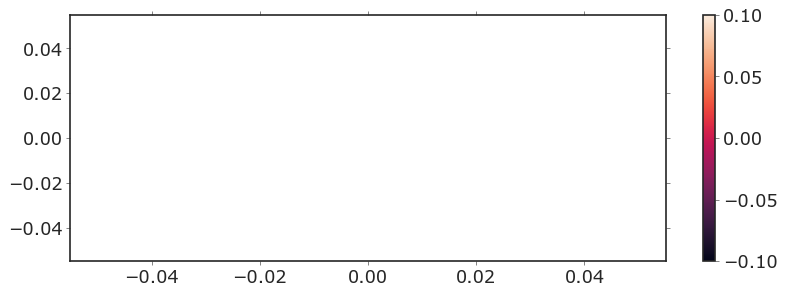

In [17]:
fig, ax=plt.subplots(figsize=(12, 4))

im=ax.scatter(np.vstack(combined_colors_df['LSST_RandLSST_Z'].values)[:,0], 
          (np.vstack(combined_colors_df['LSST_GandLSST_R'].values)[:,0]),
          c=combined_colors_df['numspt'].values)
plt.colorbar(im)

In [18]:
#lepine_color_df['LSST_GandSDSS_R']
data=[ zhang_color_df, kesseli_color_df]

labels=[ 'Zhang', 'Kesseli']

colors=[ '#FF4136', '#111111']

In [19]:
#FITS= {'colors_spt':{'subdwarfs':{}, 'dwarfs': {}},
#       'colors_teff':{'subdwarfs':{}, 'dwarfs': {}},
#       'absmags_spt':{'subdwarfs':{}, 'dwarfs': {}},
#       'absmags_teff':{'subdwarfs':{}, 'dwarfs': {}}}
FITS= np.load('/Volumes/LaCie/popsimsdata//abs_mag_relations.npy', allow_pickle=True)[0]

In [20]:
def get_sd_models(model='line2021'):
    #ADD models
    sdmodels=np.load('/Volumes/LaCie/popsimsdata/subdwarfs_models_{}.npy'.format(model), allow_pickle=True)[0]
    additional_keys=['SDSS_G', 'SDSS_R', 'SDSS_I', 'SDSS_Z', '2MASS J', '2MASS H', '2MASS K']
    all_keys= np.concatenate([additional_keys, np.unique(np.concatenate([x.split('and') for x in COLOR_TERMS]))])
    model_vals=dict(zip(all_keys, []))


    #compute values from filtermags
    #ADD ADDITIONAL FITS FOR SLOAN AND 2 MASS TO TAKE ADAVTANGE OF METAL-POOR MODELS
    
    for k in all_keys:
        mags= np.vstack([filterMag(x, k) for x in sdmodels['spectra']])
        model_vals[k]=mags[:,0] 
        model_vals[k+'_er']= 0.#(mags[:,1]**2+ np.nanmedian(df_sd_dwarfs[k+'_er'])**2)**0.5#add a fudicial 0.1 scatter

    sdmodel_df=pd.DataFrame(model_vals)
    sdmodel_df['spt']=[ teff_to_spt(x, sd=True) for x in sdmodels['teff']]
    sdmodel_df['spt']= np.array(sdmodel_df['spt'])
    sdmodel_df['teff']= sdmodels['teff']
    sdmodel_df['z']= sdmodels['z']
    return sdmodel_df

In [21]:
#sdmodel_df_drift0= get_sd_models(model='drift')
sdmodel_df_line= get_sd_models(model='line2021')
sdmodel_df_cond= get_sd_models(model='cond')


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter LSST_I

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter LSST_R

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter LSST_Z

SPLAT does not contain the filter


SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter LSST_G

SPLAT does not contain the filter

In [22]:
sdmodel_df_cond

SDSS_G  SDSS_G_er     SDSS_R  SDSS_R_er     SDSS_I  SDSS_I_er  \
0          NaN        0.0        NaN        0.0        NaN        0.0   
1          NaN        0.0        NaN        0.0        NaN        0.0   
2          NaN        0.0        NaN        0.0        NaN        0.0   
3          NaN        0.0        NaN        0.0        NaN        0.0   
4          NaN        0.0        NaN        0.0        NaN        0.0   
..         ...        ...        ...        ...        ...        ...   
148  25.671797        0.0  23.273894        0.0  20.316374        0.0   
149        NaN        0.0        NaN        0.0        NaN        0.0   
150  22.072172        0.0  19.099218        0.0  16.795064        0.0   
151        NaN        0.0        NaN        0.0        NaN        0.0   
152        NaN        0.0        NaN        0.0        NaN        0.0   

        SDSS_Z  SDSS_Z_er    2MASS J  2MASS J_er  ...  PANSTARRS_I_er  \
0          NaN        0.0        NaN         0.0  ...             0.0   
1          NaN        0.0        NaN         0.0  ...             0.0   
2          NaN        0.0        NaN         0.0  ...             0.0   
3          NaN        0.0        NaN         0.0  ...             0.0   
4          NaN        0.0        NaN         0.0  ...             0.0   
..         ...        ...        ...         ...  ...             ...   
148  16.302578        0.0  13.020466         0.0  ...             0.0   
149        NaN        0.0        NaN         0.0  ...             0.0   
150  14.322828        0.0  11.525258         0.0  ...             0.0   
151        NaN        0.0        NaN         0.0  ...             0.0   
152        NaN        0.0        NaN         0.0  ...             0.0   

     PANSTARRS_R  PANSTARRS_R_er  PANSTARRS_Y  PANSTARRS_Y_er  PANSTARRS_Z  \
0            NaN             0.0          NaN             0.0          NaN   
1            NaN             0.0          NaN             0.0          NaN   
2            NaN             0.0          NaN             0.0          NaN   
3            NaN             0.0          NaN             0.0          NaN   
4            NaN             0.0          NaN             0.0          NaN   
..           ...             ...          ...             ...          ...   
148    22.791644             0.0    15.355237             0.0    17.029408   
149          NaN             0.0          NaN             0.0          NaN   
150    18.972709             0.0    13.575039             0.0    14.721521   
151          NaN             0.0          NaN             0.0          NaN   
152          NaN             0.0          NaN             0.0          NaN   

     PANSTARRS_Z_er        spt    teff    z  
0               0.0        NaN  3300.0 -0.0  
1               0.0        NaN  3000.0  0.5  
2               0.0        NaN  3500.0  0.3  
3               0.0        NaN  3300.0 -1.5  
4               0.0        NaN  3000.0 -4.0  
..              ...        ...     ...  ...  
148             0.0  25.900000  1500.0 -0.0  
149             0.0        NaN  3300.0 -1.0  
150             0.0  23.854701  2100.0 -0.0  
151             0.0        NaN  3100.0 -3.5  
152             0.0        NaN  3100.0 -0.5  

[153 rows x 39 columns]

In [23]:
k

'LSST_IandLSST_Z'

In [24]:
#(sdmodel_df_line[k.split('and')[1]])[mask_model]-(sdmodel_df_line[k.split('and')[0]])[mask_model],

In [25]:
#

In [26]:
from scipy.interpolate import UnivariateSpline

In [27]:
#for lepine spectra, we can only use r and i bands 

In [28]:
def bin_by_spt_bin(grid, xvals, yvals, yvalserr):
    #bin on a uniformly-spaced grid
    res=[]
    dx= grid[1]-grid[0]
    for x in grid:
        mask= np.logical_and(xvals>=x, xvals<x+dx)
        yx=np.nanmedian(yvals[mask])
        yxerr=(np.nanstd(yvals[mask])**2+np.nanmedian(yvalserr[mask])**2)**0.5
        
        res.append([yx, yxerr])
        
    return res
    

In [29]:
grid=np.arange(10, 40)
                    

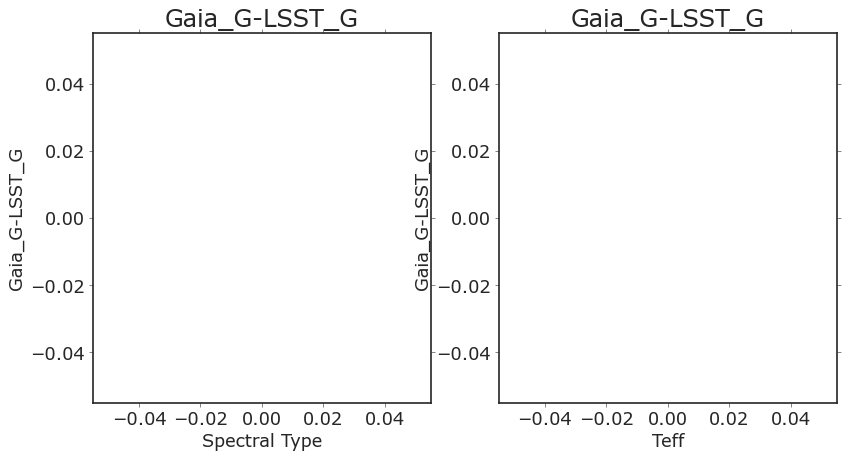

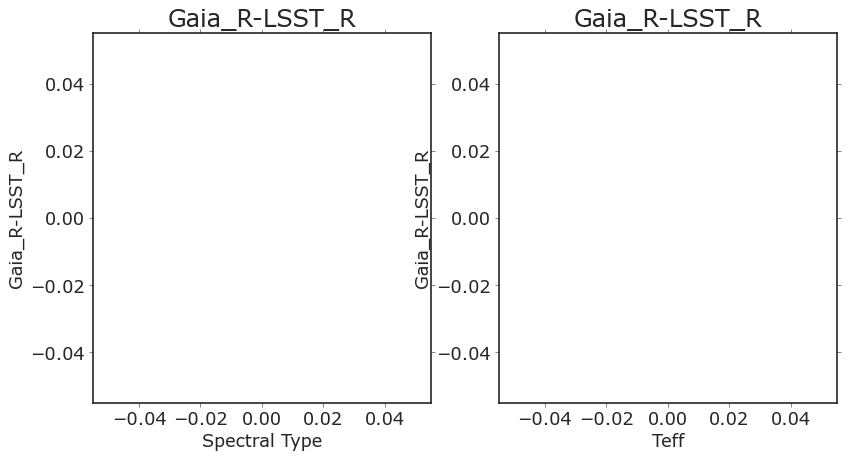

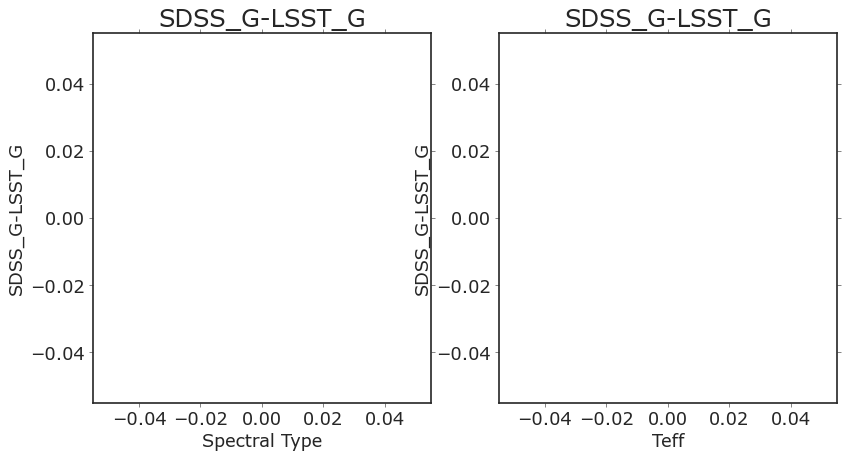

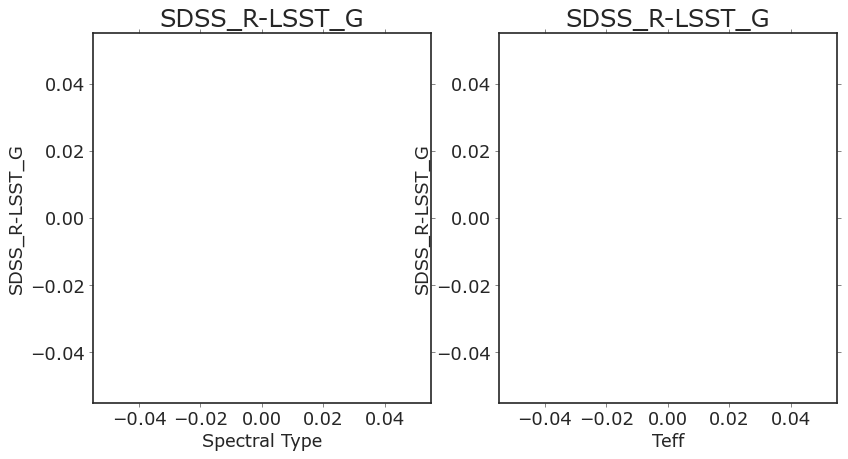

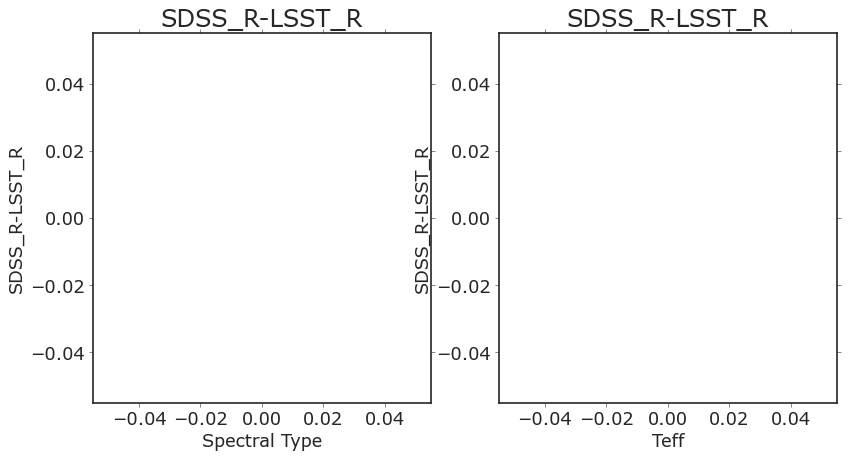

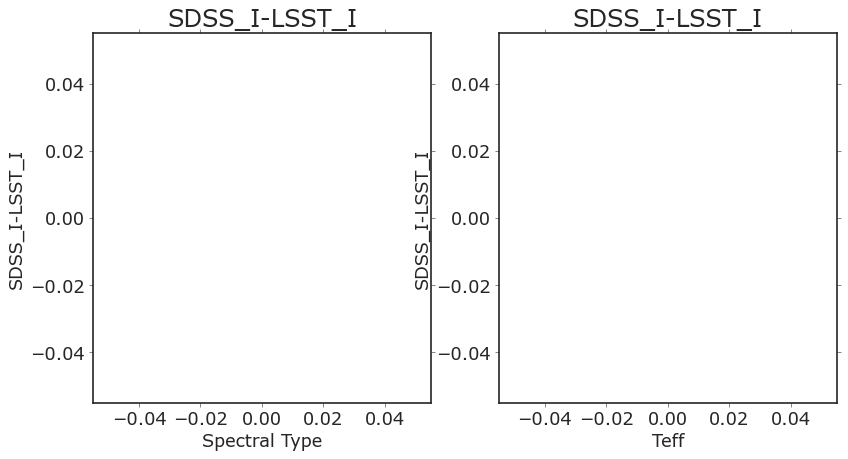

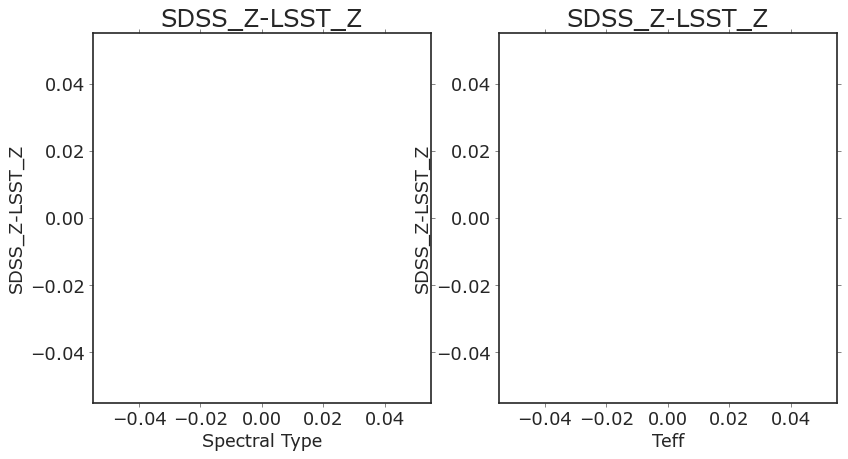

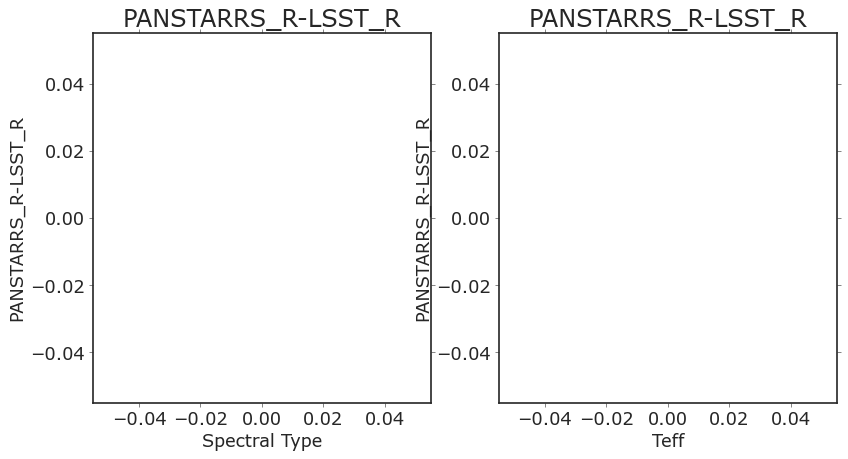

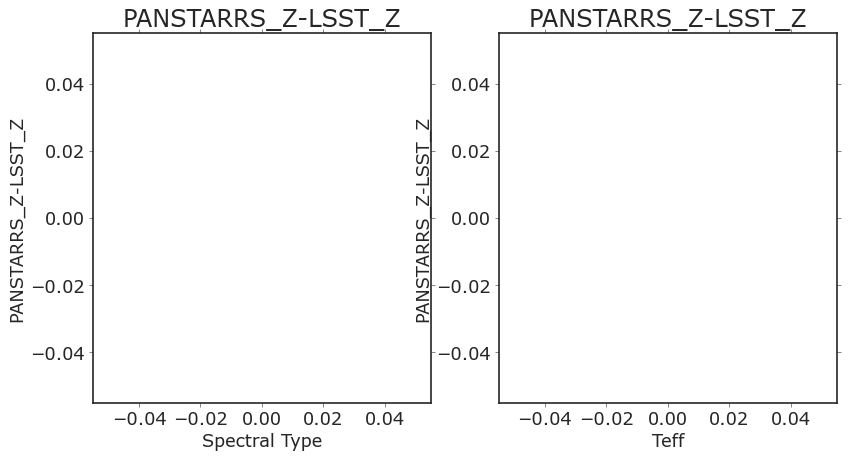

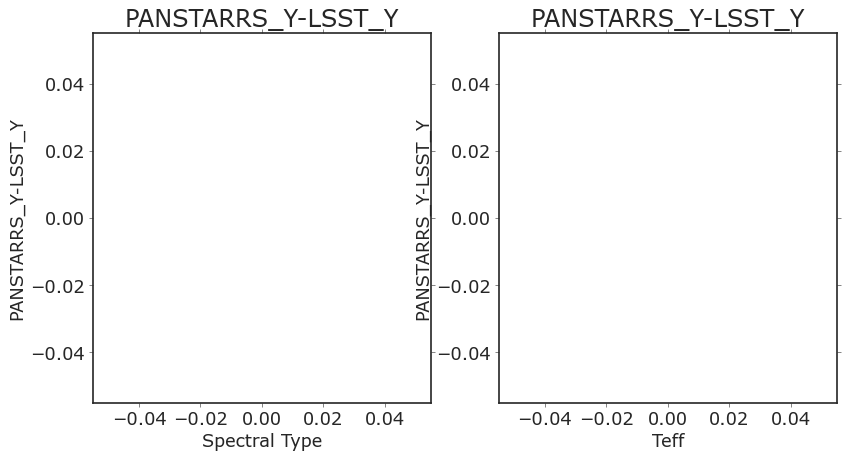

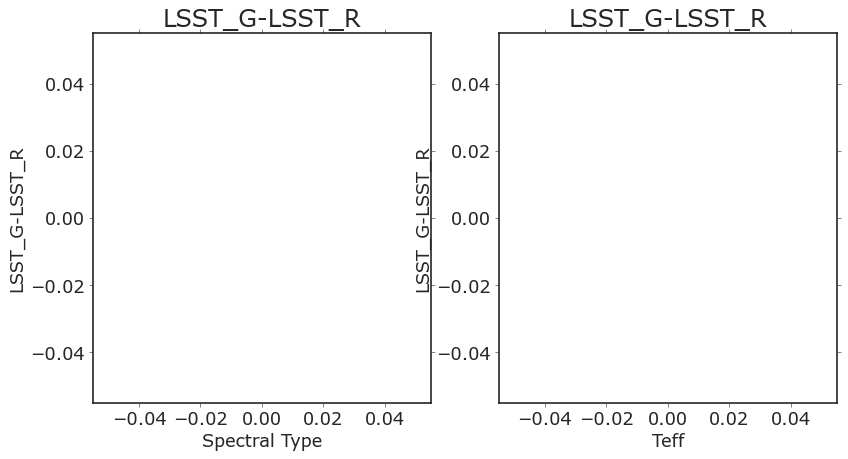

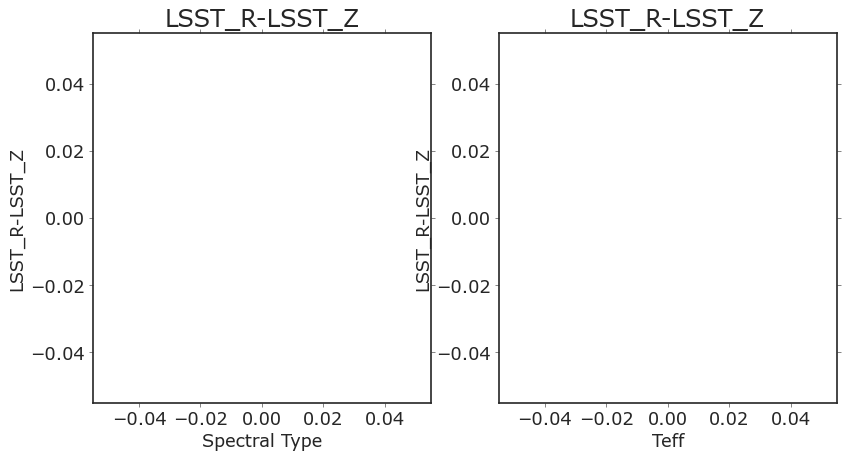

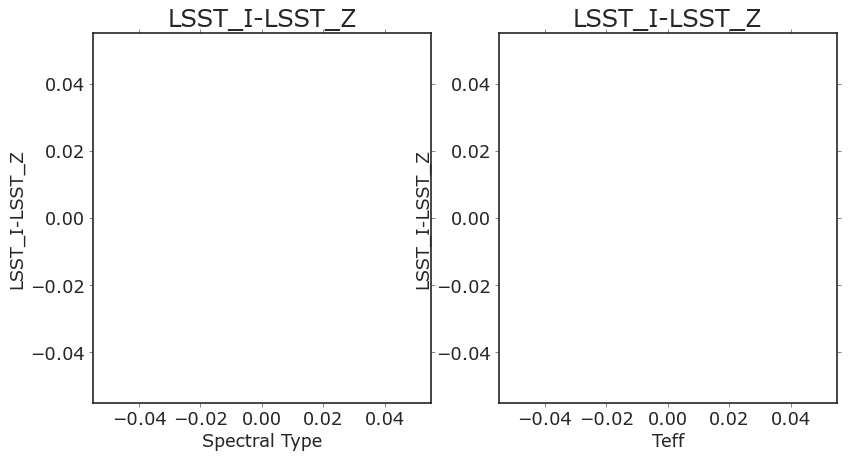

In [30]:
for k in  COLOR_TERMS:
    fig, (ax, ax1)=plt.subplots(figsize=(12, 6), ncols=2)
    try:
        for idx  in range(len(data)):
            #plot dwarfs

            mask= np.logical_and(np.vstack(data[idx][k])[:,0]>0, data[idx].subdwarf_type=='sd')
            
            grid=np.arange(10, 40)
            xvyv=bin_by_spt_bin(grid, data[idx].numspt.values[mask], \
                    np.vstack(data[idx][k])[:,0][mask],
                    np.vstack(data[idx][k])[:,1][mask])
            ax.errorbar(grid, np.array(  xvyv)[:,0], fmt='s',\
                        alpha=0.5, label=labels[idx]+' sd', c=colors[idx])
            
            grid=np.arange(500, 3000, 150)
            xvyv=bin_by_spt_bin(grid, data[idx].teff.values[mask], \
                    np.vstack(data[idx][k])[:,0][mask],
                    np.vstack(data[idx][k])[:,1][mask])
            ax1.errorbar(grid, np.array(  xvyv)[:,0], fmt='s',\
                         alpha=0.5, label=labels[idx]+' sd', c=colors[idx])

            #plot usd and esd
            mask= np.logical_and(np.vstack(data[idx][k])[:,0]>0, data[idx].subdwarf_type !='sd')
            ax.errorbar(data[idx].numspt[mask], np.vstack(data[idx][k])[:,0][mask], \
                        yerr=np.vstack(data[idx][k])[:,1][mask], fmt='+',\
                        alpha=0.5, label=labels[idx]+' esd & usd', c=colors[idx])
            ax1.errorbar(data[idx].teff[mask],  np.vstack(data[idx][k])[:,0][mask], \
                        yerr=np.vstack(data[idx][k])[:,1][mask], fmt='+',\
                         alpha=0.5, label=labels[idx]+' esd & usd', c=colors[idx])



        ax1.set(title=k.replace('and', '-'), xlabel='Teff', ylabel=k.replace('and', '-'))
        ax.set(title=k.replace('and', '-'), xlabel='Spectral Type', ylabel=k.replace('and', '-'))



        mask_model=sdmodel_df_line.z==-1.5

        ax.errorbar(sdmodel_df_line.spt[mask_model], \
                    (sdmodel_df_line[k.split('and')[0]])[mask_model]-(sdmodel_df_line[k.split('and')[1]])[mask_model], \
                    fmt='s', alpha=0.5, label='LowZ=-1.5', c='#2ECC40')
        ax1.errorbar(sdmodel_df_line.teff[mask_model], 
                     (sdmodel_df_line[k.split('and')[0]])[mask_model]-(sdmodel_df_line[k.split('and')[1]])[mask_model], \
                     fmt='s', alpha=0.5, label='LowZ=-1.5', c='#2ECC40')

        mask_model=sdmodel_df_line.z==-2.0
        ax.errorbar(sdmodel_df_line.spt[mask_model],
                    (sdmodel_df_line[k.split('and')[0]])[mask_model]-(sdmodel_df_line[k.split('and')[1]])[mask_model], \
                    fmt='+', alpha=0.5, label='LowZ=-2.0', c='#2ECC40')
        ax1.errorbar(sdmodel_df_line.teff[mask_model], 
                     (sdmodel_df_line[k.split('and')[0]])[mask_model]-(sdmodel_df_line[k.split('and')[1]])[mask_model],
                     fmt='+', alpha=0.5, label='LowZ=-2.0', c='#2ECC40')
        
        #mask for sds 
        zhangmask= np.logical_and(np.vstack(zhang_color_df[k])[:,0]>0, zhang_color_df.subdwarf_type=='sd')
        kesselimask= np.logical_and(np.vstack(kesseli_color_df[k])[:,0]>0, kesseli_color_df.subdwarf_type=='sd')
        mask_model=sdmodel_df_line.z==-1.5


        tall= np.concatenate([zhang_color_df.teff[zhangmask],\
                          kesseli_color_df.teff[kesselimask],\
                           sdmodel_df_line.teff[mask_model]])
    
        xall=np.concatenate([zhang_color_df.numspt[zhangmask],\
                          kesseli_color_df.numspt[kesselimask],\
                           sdmodel_df_line.spt[mask_model]])

        yall= np.concatenate([ np.vstack(zhang_color_df[k])[:,0][zhangmask],\
                             np.vstack(kesseli_color_df[k])[:,0][kesselimask],\
        (sdmodel_df_line[k.split('and')[0]])[mask_model]-(sdmodel_df_line[k.split('and')[1]])[mask_model]])

        
        yerrall= 0.1*np.ones_like(yall)

        
        t= np.arange(500, 3000, 150)
        
        x=np.arange(14, 40)
        
        y=np.array(bin_by_spt_bin(x,xall, yall, yerrall))[:,0]
        yerr=np.array(bin_by_spt_bin(x,xall, yall, yerrall))[:,1]
        

        mask= np.logical_or.reduce([np.isnan(x), np.isnan(y), np.isnan(yerr)])

        _, fit= fit_with_nsigma_clipping(x[~mask], y[~mask], yerr[~mask], 5, sigma=5)
        #fit=UnivariateSpline(x[~mask][np.argsort(x[~mask])], y[~mask][np.argsort(x[~mask])])
        m=np.nanmedian(yerr)

       
        
         
        t= np.arange(500, 3000, 150)

        y=np.array(bin_by_spt_bin(t,tall, yall, yerrall))[:,0]
        
        yerr=np.array(bin_by_spt_bin(t,tall, yall, yerrall))[:,1]
        
        mask2= np.logical_or.reduce([np.isnan(t), np.isnan(y), np.isnan(yerr)])
        
        _, fit2= fit_with_nsigma_clipping(t[~mask2], y[~mask2], yerr[~mask2], 5, sigma=5)
        #fit2=UnivariateSpline(t[~mask2][np.argsort(t[~mask2])], y[~mask2][np.argsort(t[~mask2])])
        m2= np.nanmedian(yerr)

        xgrid=np.linspace(np.nanmin(x[~mask]),np.nanmax(x[~mask]), 20) 
        tgrid=np.linspace(np.nanmin(t[~mask2]),np.nanmax(t[~mask2]), 20) 


        ax.plot(x, fit(x), c='k')
        
        ax1.plot(t, fit2(t), c='k')
        
        #save fits
        scatter= np.nanmedian(yerr)
        scatter2= np.nanmedian(yerr)
        


        FITS['colors_spt']['subdwarfs'].update({k: {'x': 'spt',
                                              'y': k,
                                              'fit':list(fit.coeffs),\
                                              'scatter': scatter, \
                                              'method': 'polynomial',\
                                              'range':  (np.nanmin(x[~mask]),\
                                                         np.nanmax(x[~mask])), \
                                             'x0':0.}})

        FITS['colors_teff']['subdwarfs'].update({k: {'x': 'teff',
                                              'y': k,
                                              'fit':list(fit2.coeffs),\
                                              'scatter': scatter, \
                                              'method': 'polynomial',\
                                              'range':  (np.nanmin(t[~mask2]),\
                                                         np.nanmax(t[~mask2])), \
                                             'x0':0.}})

        plt.tight_layout()
        ax.minorticks_on()
        ax1.minorticks_on()
        ax.legend(fontsize=12)
        
        
    except:
        pass

    
        
    

    plt.savefig('../figures/color_relations_sd{}.jpeg'.format(k), bbox_inches='tight')

      

In [31]:
#load in cross-matched tables
zhang_abs_mags_tables=ascii.read('/volumes/LaCie/zhang_subdwarfs_gaia_ps1_sdss.csv').to_pandas()
zhang_abs_mags_tables['numspt']=zhang_abs_mags_tables.sptype.apply(splat.typeToNum).values
zhang_abs_mags_tables['subdwarf_type']=[get_sd_type(x) for x in zhang_abs_mags_tables.sptype]

simbad_abs_mags_tables=ascii.read('/volumes/LaCie/simbad_subdwarfs_gaia_ps1_sdss.csv').to_pandas()
simbad_abs_mags_tables['numspt']=simbad_abs_mags_tables.simbad_type.apply(splat.typeToNum).values
simbad_abs_mags_tables['subdwarf_type']=[get_sd_type(x) for x in simbad_abs_mags_tables.simbad_type]


abs_mags_tables=pd.concat([zhang_abs_mags_tables, simbad_abs_mags_tables] )
abs_mags_tables['teff']=[ spt_to_teff(x, sd=True) for x in abs_mags_tables['numspt']]

In [32]:
#zhang_abs_mags_tables.columns

In [33]:
def get_abs_mags(m, merr, p, perr):
    ds= 1000/np.random.normal(p, perr, 1000)
    ms= np.random.normal(m, merr, 1000)
    res= ms-5*np.log10(ds/10.0)
    return np.nanmedian(res), np.nanstd(res)

In [34]:
#first compute SDSS_ABS_MAGS
for k in 'ugrizy':
    for sur in ['SDSS', 'PS1_PSF']:
        m=abs_mags_tables['{}_{}'.format(sur, k)].values.astype(float)
        merr=abs_mags_tables['{}_{}_er'.format(sur, k)].values.astype(float)
        p=abs_mags_tables['parallax (mas)'].values.astype(float)
        perr=abs_mags_tables[ 'parallax_er (mas)'].values.astype(float)
        vs=[get_abs_mags(mx, merrx, px, perrx) for mx, merrx, px, perrx in zip(m, merr, p, perr)]
        absm=np.vstack(vs)[:,0]
        absmerr=np.vstack(vs)[:,1]

        abs_mags_tables['abs_{}_{}'.format(sur, k)]= absm
        abs_mags_tables['abs_{}_{}_er'.format(sur, k)]= absmerr

In [35]:
#let's just focus on r i z
fig, ax=plt.subplots()
#ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_i)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_g)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_g)

In [36]:
#let's just focus on r i z
fig, ax=plt.subplots()
#ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_i)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_r)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_r)
#ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_z)

In [37]:
fig, ax=plt.subplots()
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_i)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_i)

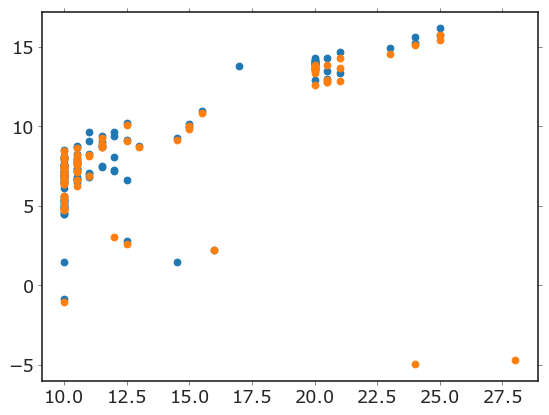

In [38]:
fig, ax=plt.subplots()
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_z)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_z)

In [39]:
#let's just focus on r i z
fig, ax=plt.subplots()
#ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_i)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_y)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_y)

In [40]:
#compute r z and i
corr_r=np.poly1d(FITS['colors_spt']['subdwarfs']['SDSS_RandLSST_R']['fit'])(abs_mags_tables.numspt)
corr_i=np.poly1d(FITS['colors_spt']['subdwarfs']['SDSS_IandLSST_I']['fit'])(abs_mags_tables.numspt)
corr_z=np.poly1d(FITS['colors_spt']['subdwarfs']['SDSS_ZandLSST_Z']['fit'])(abs_mags_tables.numspt)

In [41]:
abs_mags_tables['abs_LSST_R']=abs_mags_tables.abs_SDSS_r.values-corr_r
abs_mags_tables['abs_LSST_I']=abs_mags_tables.abs_SDSS_i.values-corr_i
abs_mags_tables['abs_LSST_Z']=abs_mags_tables.abs_SDSS_z.values-corr_z

abs_mags_tables['abs_LSST_R_er']=abs_mags_tables.abs_SDSS_r_er
abs_mags_tables['abs_LSST_I_er']=abs_mags_tables.abs_SDSS_i_er
abs_mags_tables['abs_LSST_Z_er']=abs_mags_tables.abs_SDSS_z_er

In [42]:
#SCALE THE MODELS
mask_data= np.logical_and.reduce([abs_mags_tables.subdwarf_type.values=='sd',
                                   abs_mags_tables.abs_LSST_I.values > 0.,
                                  abs_mags_tables.numspt >=24.])
                                  
                                 
sdmodel_df_line_mask= np.logical_and.reduce([ sdmodel_df_line.spt.between(24, 26), 
                       sdmodel_df_line.z==-1.5])

model_scale= np.nanmedian(abs_mags_tables.abs_LSST_I.values[mask_data])\
- np.nanmedian(sdmodel_df_line.LSST_I[sdmodel_df_line_mask])


In [43]:
model_scale

nan

In [44]:
#scale models
fig, ax=plt.subplots(figsize=(12,8))
mask= np.logical_and(abs_mags_tables.subdwarf_type.values=='sd', abs_mags_tables.abs_LSST_I>2.5 )

ax.scatter(abs_mags_tables.numspt[mask], abs_mags_tables.abs_LSST_I[mask],  s=10)
ax.scatter(abs_mags_tables.numspt[mask_data], abs_mags_tables.abs_LSST_I[mask_data],  s=50)
ax.scatter(sdmodel_df_line.spt, sdmodel_df_line.LSST_I+model_scale, marker='^')

In [45]:
ABS_MAG_USED={}

R
I
Z


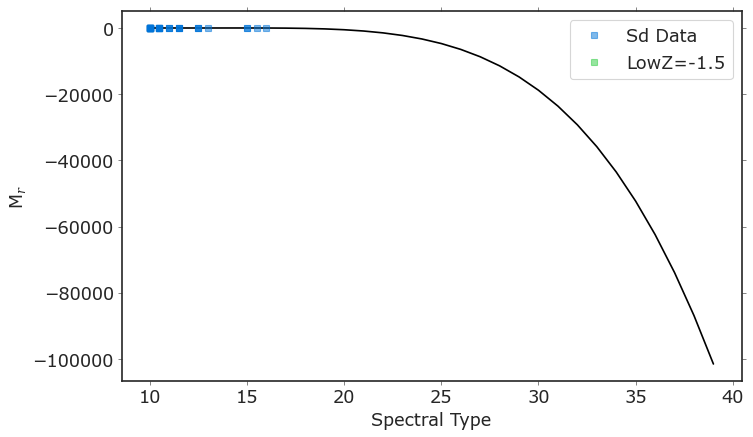

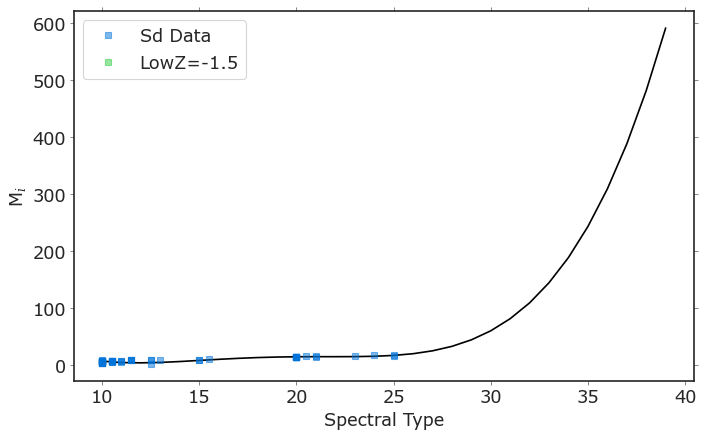

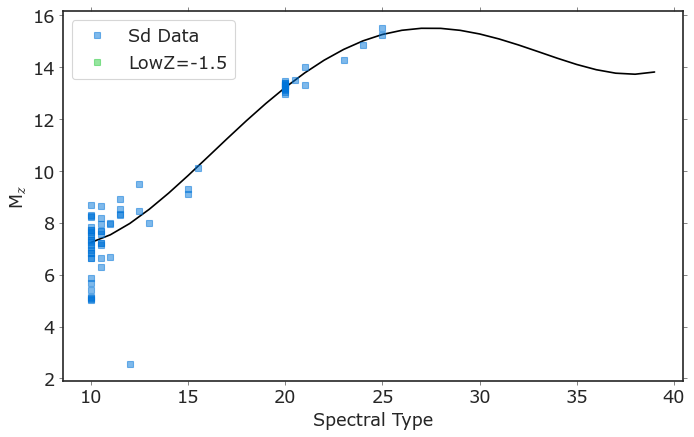

In [46]:
for k in 'riz':
    print (k.upper())

    fig, ax=plt.subplots(figsize=(10, 6))
    
    mask_data=np.logical_and(abs_mags_tables.subdwarf_type.values=='sd',
                             abs_mags_tables['abs_LSST_{}'.format(k.upper())] >2.5)
    
    mask_model= np.logical_and.reduce([sdmodel_df_line.z==-1.5])
    
    xall= np.concatenate([abs_mags_tables.numspt[mask_data],
                         sdmodel_df_line.spt[mask_model]])
    
    yall= np.concatenate([abs_mags_tables['abs_LSST_{}'.format(k.upper())][mask_data],
                          sdmodel_df_line['LSST_{}'.format(k.upper())][mask_model]+model_scale])
    
    median_error=np.nanmedian(abs_mags_tables['abs_LSST_{}_er'.format(k.upper())][mask_data])
    
    yerrall= np.concatenate([abs_mags_tables['abs_LSST_{}_er'.format(k.upper())][mask_data],
                             median_error*np.ones_like( sdmodel_df_line.spt[mask_model])])
                             
                             

    mask= np.logical_or.reduce([np.isnan(xall),np.isnan(yall),np.isnan(yerrall)])
    #print (mask)
    m, fit= fit_with_nsigma_clipping(xall[~mask], yall[~mask], yerrall[~mask], 4, sigma=2)
    #fit=UnivariateSpline(xall[~mask][np.argsort(xall[~mask])], yall[~mask][np.argsort(xall[~mask])])

    xgrid=np.arange(10, 40)
    ax.plot(xgrid, fit(xgrid), c='k')

    ax.errorbar(abs_mags_tables.numspt[mask_data], abs_mags_tables['abs_LSST_{}'.format(k.upper())][mask_data],  
                fmt='s', alpha=0.5, label='Sd Data', c='#0074D9')
    ax.errorbar(sdmodel_df_line.spt[mask_model], sdmodel_df_line['LSST_{}'.format(k.upper())][mask_model]+model_scale, \
                fmt='s', alpha=0.5, label='LowZ=-1.5', c='#2ECC40')
    #print (fit(25))
    #l;''
    ax.set(xlabel='Spectral Type', ylabel=r'M$_{}$'.format(k))
    ax.legend()
    
    
        #save fits
    scatter= (np.nanmedian(yerrall[~mask])**2+ np.nanmedian((yall[~mask]-fit(xall[~mask]))**2))**0.5

    FITS['absmags_spt']['subdwarfs'].update({'LSST_{}'.format(k.upper()): {'x': 'spt',
                                          'y': k,
                                          'fit':list(fit.coeffs),\
                                          'scatter': scatter, \
                                          'method': 'polynomial',\
                                          'range':  (np.nanmin(xall[~mask]),\
                                                     np.nanmax(xall[~mask])), \
                                         'x0':0.}})
    
    ABS_MAG_USED.update({'LSST_{}'.format(k.upper()): {'x': xall[~mask], 
                                                      'y':yall[~mask], 
                                                      'yerr':yerrall[~mask],
                                                     }})
    
    
    plt.savefig('../figures/absmag_relations_sd_LSST{}.jpeg'.format(k.upper()), bbox_inches='tight')
    


In [47]:
bins=np.arange(10, 40)
df=pd.DataFrame()
df['spt']=['sd'+splat.typeToNum(x) for x in bins]
for k in ABS_MAG_USED.keys():
    x=ABS_MAG_USED[k]['x']
    y=ABS_MAG_USED[k]['y']
    yerr=ABS_MAG_USED[k]['yerr']
    vls= np.vstack(bin_by_spt_bin(bins, x, y, yerr))
    
    df[k]=['{:.1f}+/-{:.1f}'.format(x[0], x[1]) for x in vls]
    
df.replace('nan+/-nan', '').to_latex('/users/caganze/research/popsimsdata/lsst_subdwarfs.tex', index=False)
df.replace('nan+/-nan', '')

spt      LSST_R      LSST_I      LSST_Z
0   sdM0.0   7.7+/-1.7   7.2+/-1.2   7.3+/-1.0
1   sdM1.0   9.7+/-0.9   8.8+/-0.8   8.3+/-0.7
2   sdM2.0  10.6+/-3.3   9.3+/-3.4   8.5+/-3.1
3   sdM3.0  10.1+/-0.1   8.8+/-0.1   8.0+/-0.1
4   sdM4.0                                    
5   sdM5.0  12.1+/-0.5  10.4+/-0.5   9.3+/-0.5
6   sdM6.0   2.6+/-2.0                        
7   sdM7.0                                    
8   sdM8.0                                    
9   sdM9.0                                    
10  sdL0.0              15.2+/-0.4  13.3+/-0.3
11  sdL1.0              15.4+/-0.5  13.6+/-0.4
12  sdL2.0                                    
13  sdL3.0              16.3+/-0.3  14.3+/-0.2
14  sdL4.0              17.5+/-0.4  14.9+/-0.2
15  sdL5.0              17.5+/-0.4  15.4+/-0.3
16  sdL6.0                                    
17  sdL7.0                                    
18  sdL8.0                                    
19  sdL9.0                                    
20  sdT0.0                                    
21  sdT1.0                                    
22  sdT2.0                                    
23  sdT3.0                                    
24  sdT4.0                                    
25  sdT5.0                                    
26  sdT6.0                                    
27  sdT7.0                                    
28  sdT8.0                                    
29  sdT9.0

In [48]:
np.save('/Volumes/LaCie/popsimsdata/abs_mag_relations.npy', [FITS], allow_pickle=True) 
np.save('/users/caganze/research/popsimsdata/abs_mag_relations.npy', [FITS], allow_pickle=True) 

In [49]:
FITS

{'colors_spt': {'subdwarfs': {'Gaia_GandLSST_G': {'x': 'spt',
    'y': 'Gaia_GandLSST_G',
    'fit': [1.2324054871792959e-05,
     -0.0018271673269642458,
     0.1083966479362216,
     -3.2164223162723675,
     47.62205936377559,
     -287.535125693462],
    'scatter': 0.22070027817237287,
    'method': 'polynomial',
    'range': (25, 39),
    'x0': 0.0},
   'SDSS_GandLSST_G': {'x': 'spt',
    'y': 'SDSS_GandLSST_G',
    'fit': [2.488840938176517e-05,
     -0.003787845191741443,
     0.22742653101134427,
     -6.720794565677689,
     97.51881456330098,
     -554.3343943437307],
    'scatter': 0.10003308763232047,
    'method': 'polynomial',
    'range': (19, 39),
    'x0': 0.0},
   'SDSS_RandLSST_G': {'x': 'spt',
    'y': 'SDSS_RandLSST_G',
    'fit': [-0.00034341567594013797,
     0.05388072922414567,
     -3.357434166103655,
     103.89817638939853,
     -1597.2128835920746,
     9757.571026021424],
    'scatter': 0.3137649280712076,
    'method': 'polynomial',
    'range': (25, 39),